# DBLP Anomalies

Before conducting the following analysis, we preprocessed the DBLP data set to compute the number of articles and coauthors by year, and the cummulative sum of distinct coauthors up to each year. Besides, we compute the number of articles the authors published on each venue by year, as well as the author-article graph. We also masked the authors' names.

## Definitions

In [1]:
library(stringr)
library(data.table)
library(ggplot2)
library(gridExtra)
library(rjson)
library(dtwclust)
library(factoextra)
library(cluster)
library(abodOutlier)
library(corrplot)
library(igraph)
library(birankr)
library(IRdisplay)
library(xtable)
library(matrixStats)
library(dplyr)
library(data.table)

Loading required package: proxy


Attaching package: ‘proxy’


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loading required package: dtw

Loaded dtw v1.22-3. See ?dtw for help, citation("dtw") for use in publication.


dtwclust:
Setting random number generator to L'Ecuyer-CMRG (see RNGkind()).
To read the included vignettes type: browseVignettes("dtwclust").
See news(package = "dtwclust") after package updates.

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.84 loaded


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: Matrix


Attaching package: ‘xtable’


The following object is masked from ‘package:IRdisplay’:

    display



Attaching package: ‘dplyr’


The following object is mask

In [2]:
# for STEP in {1..23}; do 
# awk -F";" '{print $1";"$2";"$3";"$7";"$8}' tip_decomposition-model-4-step-$STEP-partition-1 > /tmp/file.tmp && mv /tmp/file.tmp tip_decomposition-model-4-step-$STEP-partition-1;
# done

In [3]:
# for STEP in {1..23}; do 
#  sed -i 's/Degree/articles/g' tip_decomposition-model-4-step-$STEP-partition-1
#  sed -i 's/Neighbors/coauthors/g' tip_decomposition-model-4-step-$STEP-partition-1
# done

In [4]:
# for STEP in {1..23}; do 
#  mv tip_decomposition-model-4-step-$STEP-partition-1 authors_year_$STEP
# done

In [5]:
options(scipen = 999)

In [6]:
read.author.index <- function(f.name) {
  df <- read.csv2(f.name, header = T, sep = ";", stringsAsFactors = F)
  rownames(df) <- as.character(df$id)
  df$author.first.name <- sapply(str_split(df$author, " "), function(a) {a[1]})
  df$author.first.name <- paste(df$author.first.name)#, " (", df$id ,")", sep = "")
  df
}

read.nodes <- function(f.name) {
  df <- read.csv2(f.name, header = T, sep = ";", stringsAsFactors = F)
  df$Time <- df$Time - 1
  df$articles <- as.numeric(df$articles)
  df
}

read.graph.author.venue.one.step <- function(f.name) {
    df <- read.csv2(f.name, header = T, sep = ";", stringsAsFactors = F)
    df <- df %>% 
        group_by(author, venue) %>% 
        summarise(weight = n())
    df
}

VENUE.SHIFT <- 10000000

read.graph.author.venue.all.steps.by.year <- function(dir.name, window.begin, window.end) {
    window.begin <- window.begin - 2000 + 1
    window.end <- window.end - 2000 + 1
    all.steps <- list.files(
        dir.name, 
        pattern = "graph-\\d+$"
    )
    
    # Sort by step  
    tmp.sort <- str_match(all.steps, "graph-(\\d+)")
    all.steps <- all.steps[order(as.integer(tmp.sort[, 2]))]
    all.steps <- all.steps[window.begin:window.end]
    
    all.files <- paste(dir.name, "/", all.steps, sep = "")
    all.graphs <- lapply(all.files, function(f.name) {
        tmp <- read.graph.author.venue.one.step(f.name)
        tmp$time <- as.integer(str_match(f.name, "graph-(\\d+)")[, 2])
        tmp
    })
    all.graphs <- do.call(rbind, all.graphs)
    
    # Shift venue ids
    all.graphs$venue <- all.graphs$venue + VENUE.SHIFT
    
    all.graphs %>%
        group_by(author, venue, time) %>%
        summarise (weight = sum(weight))
}

read.graph.author.venue.all.steps <- function(dir.name, window.begin, window.end) {
    window.begin <- window.begin - 2000 + 1
    window.end <- window.end - 2000 + 1
    all.steps <- list.files(
        dir.name, 
        pattern = "graph-\\d+$"
    )
    
    # Sort by step  
    tmp.sort <- str_match(all.steps, "graph-(\\d+)")
    all.steps <- all.steps[order(as.integer(tmp.sort[, 2]))]
    all.steps <- all.steps[window.begin:window.end]
    
    
    all.files <- paste(dir.name, "/", all.steps, sep = "")
    all.graphs <- lapply(all.files, function(f.name) {
        read.graph.author.venue.one.step(f.name)
    })
    all.graphs <- do.call(rbind, all.graphs)
    
    # Shift venue ids
    all.graphs$venue <- all.graphs$venue + VENUE.SHIFT
    
    all.graphs %>%
        group_by(author, venue) %>%
        summarise (weight = sum(weight))
}


read.graph.author.publication.one.step <- function(f.name) {
    df <- read.csv2(f.name, header = T, sep = ";", stringsAsFactors = F)
    df
}


read.graph.author.publication.all.steps <- function(dir.name, window.begin, window.end) {
    window.begin <- window.begin - 2000 + 1
    window.end <- window.end - 2000 + 1
    all.steps <- list.files(
        dir.name, 
        pattern = "graph-\\d+$"
    )
    
    # Sort by step  
    tmp.sort <- str_match(all.steps, "graph-(\\d+)")
    all.steps <- all.steps[order(as.integer(tmp.sort[, 2]))]
    all.steps <- all.steps[window.begin:window.end]
    
    all.files <- paste(dir.name, "/", all.steps, sep = "")
    all.graphs <- lapply(all.files, function(f.name) {
        read.graph.author.publication.one.step(f.name)
    })
    all.graphs <- do.call(rbind, all.graphs)
    
    all.graphs
}

read.graph.author.venue.all.steps.weighted.incidence <- function(dir.name, window.begin, window.end) {
    window.begin <- window.begin - 2000 + 1
    window.end <- window.end - 2000 + 1
    all.steps <- list.files(
        dir.name, 
        pattern = "graph-\\d+$"
    )
    
    # Sort by step  
    tmp.sort <- str_match(all.steps, "graph-(\\d+)")
    all.steps <- all.steps[order(as.integer(tmp.sort[, 2]))]
    all.steps <- all.steps[window.begin:window.end]
    
    all.files <- paste(dir.name, "/", all.steps, sep = "")
    all.graphs <- lapply(all.files, function(f.name) {
        read.graph.author.venue.one.step(f.name)
    })
    all.graphs <- do.call(rbind, all.graphs)
    
    # Shift venue ids
    all.graphs$venue <- all.graphs$venue + VENUE.SHIFT
    
    # Weight is the summation of the incident edges.
    # Reincident edges are increasewd by one each time.
    # Computed as an aritmetic sequence increased by 1.
    all.graphs %>%
        group_by(author, venue) %>%
        summarise (
            weight = n()*(1 + sum(weight)) / 2
        )
}

read.graph.author.venue.all.steps.weighted.incidence.normalized.by.venue <- function(dir.name, window.begin, window.end) {
    window.begin <- window.begin - 2000 + 1
    window.end <- window.end - 2000 + 1
    all.steps <- list.files(
        dir.name, 
        pattern = "graph-\\d+$"
    )
    
    # Sort by step  
    tmp.sort <- str_match(all.steps, "graph-(\\d+)")
    all.steps <- all.steps[order(as.integer(tmp.sort[, 2]))]
    all.steps <- all.steps[window.begin:window.end]

    
    
    all.files <- paste(dir.name, "/", all.steps, sep = "")
    all.graphs <- lapply(all.files, function(f.name) {
        read.graph.author.venue.one.step(f.name)
    })
    all.graphs <- do.call(rbind, all.graphs)
    
    # Shift venue ids
    all.graphs$venue <- all.graphs$venue + VENUE.SHIFT
    
    # Weight is proportion of articles publised by the author in each venue
    all.graphs <- all.graphs %>%
        group_by(author, venue) %>%
        summarise (
            weight = n()
        )
    
    all.graphs %>%
        group_by(venue) %>%
        mutate (
            weight = weight / sum(weight)
        )
}

read.venue.index <- function(venue.index.file) {
    df <- read.csv2(venue.index.file, header = T, sep = ";", stringsAsFactors = F)
    df$id <- df$id + VENUE.SHIFT
    df
}

read.graph.author.venue.as.matrix <- function(dir.name) {
    weighted.edge.list <- read.graph.author.venue.all.steps(dir.name)
    birankr::sparsematrix_from_edgelist(
      data = weighted.edge.list,
      sender_name = "author",
      receiver_name = "venue",
      weight_name = "weight",
      is_bipartite = T
    )

}

read.coauthors.cumsum.over.time <- function(processed.dir) {
  cumsum.file <- paste0(processed.dir, "/coauthors-cumulative-sum.csv", sep="")
  coauthors.by.year.cumsum <- read.csv(cumsum.file, header = T, sep=";")
  coauthors.by.year.cumsum$coauthor.cumsum <- coauthors.by.year.cumsum$cumsum
  coauthors.by.year.cumsum$cumsum <- NULL
  coauthors.by.year.cumsum
}

read.all.tip.files <- function(tipness.files.names, filter.nodes=F, anoms=NULL, control=NULL) {
  all.t <- NULL
  for (i in 1:length(tipness.files.names)) {
    dir.name.t <- tipness.files.names[i]
    
    nodes.t <- read.nodes(dir.name.t)
    
    if (filter.nodes) {
      nodes.t <- nodes.t %>% filter(Node %in% c(anoms, control))
    }
    
    if (is.null(all.t)) {
      all.t <- nodes.t
    } else {
      all.t <- rbind(all.t, nodes.t)
    }
  }
  all.t$Node <- as.factor(all.t$Node)
  all.t
}

read.coauthors.cumsum.over.time <- function(processed.dir) {
  cumsum.file <- paste0(processed.dir, "/coauthors-cumulative-sum.csv", sep="")
  coauthors.by.year.cumsum <- read.csv(cumsum.file, header = T, sep=";")
  coauthors.by.year.cumsum$coauthor.cumsum <- coauthors.by.year.cumsum$cumsum
  coauthors.by.year.cumsum$cumsum <- NULL
  coauthors.by.year.cumsum
}

In [7]:
compute.academic.birth <- function(all.t) {
    all.t %>% 
        group_by(Node) %>%
        summarize(
            academic.birth = min(Time)
        )
}

In [8]:
compute.derivatives.in.time <- function(all.t, min.publications) {

    window.lag.computation <- function(value.vector, multiple) {
    
        ifelse(
                seq_along(value.vector) == multiple,
                value.vector[multiple],
                ifelse(
                    seq_along(value.vector) %% multiple == 0, 
                    value.vector - lag(value.vector, multiple),
                    0
                )
        )
    }
    
    # diff is used to denote speed
    
    all.t <- all.t %>%
            tidyr::complete(Node,Time) %>%
            group_by(Node) %>% 
            arrange(Node, Time) %>% 
            mutate(
              all.articles = sum(articles, na.rm = T),
              cumulative.articles = cumsum(ifelse(is.na(articles), 0, articles)), 
              cumulative.coauthors = max(coauthor.cumsum, na.rm=T)
            ) %>%
            filter(cumulative.articles > 0) %>% # Remove extra lines before authors' start publishing
            mutate(
              first.time.all.articles = (Time[cumulative.articles == all.articles])[1],
                
              diff.articles = articles,
              diff.cumulative.coauthors = coauthor.cumsum - lag(coauthor.cumsum),
              diff.coauthors = coauthors,

              diff.articles.2.years = window.lag.computation(cumulative.articles, 2),
              diff.cumulative.coauthors.2.years = window.lag.computation(coauthor.cumsum, 2),

              diff.articles.3.years = window.lag.computation(cumulative.articles, 3),
              diff.cumulative.coauthors.3.years = window.lag.computation(coauthor.cumsum, 3),

              diff.articles.4.years = window.lag.computation(cumulative.articles, 4),
              diff.cumulative.coauthors.4.years = window.lag.computation(coauthor.cumsum, 4),

              diff.articles.5.years = window.lag.computation(cumulative.articles, 5),
              diff.cumulative.coauthors.5.years = window.lag.computation(coauthor.cumsum, 5)
           )   
            
    col.names.not.na <- colnames(all.t)
  
    for (col in col.names.not.na) {
        if (sum(is.na(all.t[,col])) > 0) {
          all.t[is.na(all.t[,col]),col] <- 0
        }
    }
    

    # diff.2 corresponds to the acceleration

    all.t <- all.t %>%
        group_by(Node) %>% 
        arrange(Node, Time) %>% 
        mutate(    
              diff.2.articles = diff.articles - lag(diff.articles),
              diff.2.coauthors = diff.coauthors - lag(diff.coauthors),
              diff.2.cumulative.coauthors = diff.cumulative.coauthors - lag(diff.cumulative.coauthors),

              diff.2.articles.2.years = window.lag.computation(diff.articles.2.years, 2),
              diff.2.cumulative.coauthors.2.years = window.lag.computation(diff.cumulative.coauthors.2.years, 2),

              diff.2.articles.3.years = window.lag.computation(diff.articles.3.years, 3),
              diff.2.cumulative.coauthors.3.years = window.lag.computation(diff.cumulative.coauthors.3.years, 3),

              diff.2.articles.4.years = window.lag.computation(diff.articles.4.years, 4),
              diff.2.cumulative.coauthors.4.years = window.lag.computation(diff.cumulative.coauthors.4.years, 4),
                
              diff.2.articles.5.years = window.lag.computation(diff.articles.5.years, 5),
              diff.2.cumulative.coauthors.5.years = window.lag.computation(diff.cumulative.coauthors.5.years, 5),
            ) 
    
    # Remove extra lines after of authors' publication end
    all.t <- all.t %>% 
        group_by(Node, Time) %>%
        filter(
            (cumulative.articles != all.articles)
            |
            (Time == first.time.all.articles)
        )

    col.names.not.na <- colnames(all.t)
  
    for (col in col.names.not.na) {
        if (sum(is.na(all.t[,col])) > 0) {
          all.t[is.na(all.t[,col]),col] <- 0
        }
    }

  
  all.t
}

In [9]:
read.authors.features <- function(processed.dir, models, min.publications, window.begin=2000, window.end=2022) {
  window.begin <- window.begin - 2000 + 1
  window.end <- window.end - 2000 + 1
  tips.for.all.models  <- data.frame(matrix(ncol = 2, nrow = 0))
  colnames(tips.for.all.models ) <- c("Node", "Time")
  for (model in models) {
      print(paste0("Reading model ", model))
      tipness.files.names <- list.files(processed.dir, pattern = paste0("authors_year_\\d+$"))
  
      # Sort by step  
      tmp.sort <- str_match(tipness.files.names, "authors_year_(\\d+)")
      tipness.files.names <- tipness.files.names[order(as.integer(tmp.sort[, 2]))]
  
      # Include from window.start to window.end (includes extremes)
      # Exclude 2021, 2022
      
      tipness.files.names <- tipness.files.names[window.begin:window.end]
      tipness.files.names <- paste(processed.dir, "/",tipness.files.names, sep="")
  
      # Tip value
      all.t <- read.all.tip.files(tipness.files.names)
      all.t$Node <- as.integer(as.character(all.t$Node))
      colnames(all.t) <- c(
          "Time",
          "Node",
          "articles",
          "coauthors",
          paste0("Entropy.model.", model, sep="")
      )
      tips.for.all.models <- merge(tips.for.all.models, all.t, by = c("Node", "Time"), all = T)
  }
  
  # Coauthors over time
  coauthors.t <- read.coauthors.cumsum.over.time(processed.dir)
  
  #print(tips.for.all.models[1:5,c("Node", "Time")])
  #print(coauthors.t[1:5,c("author", "time")])
    
  tips.for.all.models <- merge(tips.for.all.models, coauthors.t, by.x = c("Node", "Time"), by.y = c("author", "time"))
    
  #print(tips.for.all.models[1:5,c("Node", "Time")])
  
  tips.for.all.models <- tips.for.all.models %>%
    group_by(Node) %>%
    mutate(all.publications = sum(articles, na.rm=T)) %>%
    ungroup() %>%
    as.data.frame()
    
  # At least min.publications in the time frame
  tips.for.all.models <- tips.for.all.models[
      tips.for.all.models$all.publications >= min.publications,
  ]
    
  tips.for.all.models$all.publications <- NULL
    
  tips.for.all.models
}

In [10]:
save.plot <- function(
    p, 
    file, 
    p.dir="/tmp/articles/scientometrics/",
    h = 900
){
    f.name <- paste0(p.dir,file,".png")
    print(f.name)
    png(
        file=f.name, 
        units="px", 
        width=1700, 
        height=h, 
        res=300)
    plot(p)
    dev.off()
}

In [11]:
plot.authors.behavior <- function(cl, all.publications.years, title=NULL) {
    
    cluster.pubs <- all.publications.years[all.publications.years$Node %in% cl,]
    cluster.pubs$Node <- as.factor(cluster.pubs$Node)
    
    all.publications.years <- all.publications.years[all.publications.years$Node %in% cl, ]
    all.publications.years$Node <- as.factor(all.publications.years$Node)
    
    breaks <- seq(
        min(all.publications.years$Time),
        max(all.publications.years$Time),
        1
    )

    p1 <- ggplot(cluster.pubs, aes(x = Time, y = cumulative.articles, group=Node)) +
           geom_line(aes(colour=Node), size=1) +
           scale_x_continuous(breaks=breaks) +
           theme(
               legend.position = "none", 
               text = element_text(size=15),
           )+
           ylab("Articles") +
           xlab("Year")


    p3 <- ggplot(cluster.pubs, aes(x = Time, y = coauthor.cumsum, group=Node)) +
           geom_line(aes(colour=Node), size = 1) +
           scale_x_continuous(breaks=breaks) +
           theme(
               legend.position = "none", 
               text = element_text(size=15),
           )+
           ylab("Cummulative coauthors") +
           xlab("Year")
    
      
    p4 <- ggplot(all.publications.years, aes(x = Time, y = diff.articles, group=Node)) +
           geom_line(aes(colour=Node), size = 1) +
           scale_x_continuous(breaks=breaks) +
           theme(
               legend.position = "none", 
               text = element_text(size=15),
           )+
           ylab("RAGS") +
           xlab("Year")
    
    p5 <- ggplot(all.publications.years, aes(x = Time, y = diff.cumulative.coauthors, group=Node)) +
           geom_line(aes(colour=Node), size = 1) +
           scale_x_continuous(breaks=breaks) +
           theme(
               legend.position = "none", 
               text = element_text(size=15),
           )+
           ylab("RCGS") +
           xlab("Year")
    
    p6 <- ggplot(all.publications.years, aes(x = Time, y = diff.butterflies, group=Node)) +
           geom_line(aes(colour=Node), size = 1) +
           scale_x_continuous(breaks=breaks) +
           theme(
               legend.position = "none", 
               text = element_text(size=15),
           )+
           ylab("Difference") +
           xlab("Year")
    
  
    p7 <- ggplot(
                all.publications.years[
                    ,
                ], 
                aes(x = Time, y = diff.2.articles, group=Node)
           ) +
           geom_line(aes(colour=Node), size = 1) +
           scale_x_continuous(breaks=breaks) +
           theme(
               legend.position = "none", 
               text = element_text(size=15),
           )+
           ylab("RAGA") +
           xlab("Year")
    
    p8 <- ggplot(
               all.publications.years[
                   ,
               ], aes(x = Time, y = diff.2.cumulative.coauthors, group=Node)
           ) +
           geom_line(aes(colour=Node), size = 1) +
           scale_x_continuous(breaks=breaks) +
           theme(
               legend.position = "none", 
               text = element_text(size=15),
           )+
           ylab("RCGA") +
           xlab("Year")
    
    p9 <- ggplot(all.publications.years, aes(x = Time, y = diff.2.butterflies, group=Node)) +
           geom_line(aes(colour=Node), size = 1) +
           scale_x_continuous(breaks=breaks) +
           theme(
               legend.position = "none", 
               text = element_text(size=15),
           )+
           ylab("Acceleration") +
           xlab("Time")
    
    save.plot(p1, paste0(title, ".cummulative.publications"))
    plot(p1)
    save.plot(p3, paste0(title, ".cummulative.coauthors"))
    plot(p3)
    save.plot(p4, paste0(title, ".publications.speed"))
    plot(p4)
    save.plot(p5, paste0(title, ".coauthors.speed"))
    plot(p5)
    save.plot(p7, paste0(title, ".publications.acceleration"))
    plot(p7)
    save.plot(p8, paste0(title, ".coauthors.acceleration"))
    plot(p8)
    
}

In [12]:
plot.author.behavior.2 <- function(
    cl, 
    baseline.authors,
    all.publications.years, 
    features.names, 
    friendly.features.names, 
    author.set.for.reference.1=NULL,
    author.set.for.reference.2=NULL) {
    
    cluster.pubs <- all.publications.years[all.publications.years$Node %in% cl,]
    cluster.pubs$Node <- as.factor(cluster.pubs$Node)
    

    x <- lapply(features.names, function(f.name) {
        mean.feature <- all.publications.years[,c("Node", "Time", f.name)]
        mean.feature$Node <- -1
        names(mean.feature) <- c("Node", "Time", "feature")
        
        mean.feature <- mean.feature %>%
          filter(feature >= 0) %>%
          group_by(Node, Time) %>%
          summarize(
              feature = mean(feature)
          ) %>%
          ungroup() %>%
          as.data.frame()
        
        mean.feature$Node <- as.factor(-1)
        
        
        sel.pubs <- cluster.pubs[
            ,
            c("Node", "Time", f.name)
        ]
        names(sel.pubs) <- c("Node", "Time", "feature")
        
        plot.features <- bind_rows(mean.feature, sel.pubs)
        
        if (!is.null(author.set.for.reference.1)) {
            mean.feature.ref <- all.publications.years[
                all.publications.years$Node %in% author.set.for.reference.1,
                c("Node", "Time", f.name)
            ]
            names(mean.feature.ref) <- c("Node", "Time", "feature")
            mean.feature.ref <- mean.feature.ref %>%
              filter(feature >= 0) %>%
              group_by(Time) %>%
              summarize(
                  feature = mean(feature)
              ) %>%
              ungroup() %>%
              as.data.frame()
        
            mean.feature.ref$Node <- as.factor(-2)
            
            plot.features <- bind_rows(plot.features, mean.feature.ref)
        }
        
        if (!is.null(author.set.for.reference.2)) {
            mean.feature.ref <- all.publications.years[
                all.publications.years$Node %in% author.set.for.reference.2,
                c("Node", "Time", f.name)
            ]
            names(mean.feature.ref) <- c("Node", "Time", "feature")
            mean.feature.ref <- mean.feature.ref %>%
              filter(feature >= 0) %>%
              group_by(Time) %>%
              summarize(
                  feature = mean(feature)
              ) %>%
              ungroup() %>%
              as.data.frame()
        
            mean.feature.ref$Node <- as.factor(-3)
            
            plot.features <- bind_rows(plot.features, mean.feature.ref)
        }
        
        plot.features <- split(plot.features, plot.features$Node)
        
        colors <- c(
            "black",
            "skyBlue",
            "orange",
            "yellow"
        )
        
        linetypes <- c(
            "solid", 
            "dashed", 
            "dotdash",
            "longdash"
        )
        
        nm.nodes <- names(plot.features) 
        p1 <- ggplot(plot.features[[nm.nodes[1]]], aes_string(x = "Time", y = "feature")) +
           geom_line(colour=colors[1], linetype=linetypes[1], size=1)
        
        i <- 2
        for (nm in nm.nodes[2:length(nm.nodes)]) {
            p1 <- p1 +
               geom_line(
                   data=plot.features[[nm]], 
                   aes_string(
                       x = "Time", 
                       y = "feature"
                   ), 
                   colour=colors[i], 
                
                   linetype=linetypes[i], 
                   size=1
               )
             i <- i + 1
         }
         p1 <- p1 +
           theme(
               text = element_text(size=15),
           )+
           ylab(friendly.features.names[[f.name]]) +
           xlab("Year") +
           scale_x_continuous(
               breaks=seq(2010,2020,1)
           )
        save.plot(p1, paste("comparative.behavior.",cl,".",f.name, collapse=".", sep=""))
        plot(p1)
    })
    
}

In [13]:
plot.author.behavior.3 <- function(
    cl, 
    baseline.authors,
    all.publications.years, 
    features.names, 
    friendly.features.names
    ) {
    
    cluster.pubs <- all.publications.years[all.publications.years$Node %in% cl,]
    cluster.pubs$Node <- as.factor(cluster.pubs$Node)
    baseline.pubs <- all.publications.years[all.publications.years$Node %in% baseline.authors,]
    baseline.pubs$Node <- as.factor(baseline.pubs$Node)
        
    x <- lapply(features.names, function(f.name) {
        plot.features <- all.publications.years[
            c(cl, baseline.authors),
            c("Node", "Time", f.name)
        ]
        p1 <- ggplot(plot.features, aes_string(x = "Time", y = f.name, group="Node")) +
           geom_line(
               data = cluster.pubs,
               aes(color = Node),
               linetype="solid", 
               size=1
           ) +
           geom_line(
               data = baseline.pubs,
               linetype="dashed", 
               size=1,
               colour="#6F7378"
           )
        p1 <- p1 +
           theme(
               legend.position = "none", 
               text = element_text(size=15),
           )+
           ylab(friendly.features.names[[f.name]]) +
           xlab("Year") +
           scale_x_continuous(
               breaks=seq(2010,2020,1)
           )
        save.plot(p1, paste("anomalous.midrank.behavior.",f.name, collapse=".", sep=""))
        plot(p1)
    })
}

In [14]:
compute.author.entropy <- function(weighted.graph) {
   
    compute.entropy <- function(weights) {
        p <- weights / sum(weights)
        log.p <- log2(p)
        e <- sum(-p * log.p)
        e <- e / log2(sum(weights))
        1 - e
    }
    
    entropy <- weighted.graph %>% 
        group_by(author) %>%
        summarize(
            entropy.opposite = compute.entropy(weight)
        )
    as.data.frame(entropy)
}

In [15]:
compute.author.venue.engagement.summary <- function(
    author.venue.engagement.year, 
    min.publications.venue.year=5,
    min.sd=0
    ) {
    
    author.venue.engagement.year <- author.venue.engagement.year[author.minus.venue.context.zscore > 0,]
    
    author.venue.engagement.year <- author.venue.engagement.year %>%
        filter(
            weight >= min.publications.venue.year & 
            author.minus.venue.context.zscore > min.sd
        ) %>%
        group_by(author, time) %>%
        summarize(
            mean.author.minus.venue.context.zscore = mean(author.minus.venue.context.zscore),
            max.author.minus.venue.context.zscore = max(author.minus.venue.context.zscore)
        )
    
    author.mean.zscore <- author.venue.engagement.year %>%
        group_by(author) %>%
        summarize(
            mean.author.minus.venue.context.zscore = mean(mean.author.minus.venue.context.zscore),
            max.author.minus.venue.context.zscore = max(max.author.minus.venue.context.zscore),
            count.author.minus.venue.context.zscore.gte.sd.ref = n()
        )

    author.mean.zscore
}

In [16]:
compute.author.venue.engagement.no.summary <- function(author.venue.year) {

    setDT(author.venue.year)
    
    author.venue.year[
        , 
        venue.pubs.sum := sum(weight), 
        by = .(time, venue)
    ]
    
    author.venue.year[
        , 
        author.pubs.sum := sum(weight), 
        by = .(time, author)
    ]
    
    mean.pubs.year <- mean(author.venue.year$author.pubs.sum)
    
    print(mean.pubs.year)
    
    author.venue.year[
        , 
        venue.context.pubs.sum := sum(venue.pubs.sum), 
        by = .(time, author)
    ]
    
        
    author.venue.year[
        , 
        c(
            "venue.context.zscore",
            "author.weight.zscore"
        ) := list(
            (venue.pubs.sum - mean(venue.pubs.sum)) / sd(venue.pubs.sum),
            (weight - mean(weight)) / sd(weight)
        ),
        by = .(time, author)
    ]
    
    author.venue.year[
        , 
        c(
            "author.minus.venue.context.zscore"
        ) := list(
            author.weight.zscore - venue.context.zscore
        )
    ]
    
    author.venue.year[
        is.na(author.minus.venue.context.zscore), 
        author.minus.venue.context.zscore := 0
    ]
    
    author.venue.year[
        , 
        venue.share := (venue.pubs.sum / venue.context.pubs.sum)
    ]
    
    author.venue.year[
        , 
        author.share := (weight / venue.pubs.sum)
    ]
    
    author.venue.year[
        , 
        author.share.over.venue.share := (author.share / venue.share)
    ]
    
    author.venue.year
    
}

In [17]:
compute.author.venue.engagement <- function(
    author.venue.year,
    min.publications.venue.year=5,
    min.sd=3
) {

    setDT(author.venue.year)
    
    author.venue.year[
        , 
        venue.pubs.sum := sum(weight), 
        by = .(time, venue)
    ]
    
    author.venue.year[
        , 
        author.pubs.sum := sum(weight), 
        by = .(time, author)
    ]
    
    mean.pubs.year <- mean(author.venue.year$author.pubs.sum)
    
    print(mean.pubs.year)
    
    author.venue.year[
        , 
        venue.context.pubs.sum := sum(venue.pubs.sum), 
        by = .(time, author)
    ]
    
        
    author.venue.year[
        , 
        c(
            "venue.context.zscore",
            "author.weight.zscore"
        ) := list(
            (venue.pubs.sum - mean(venue.pubs.sum)) / sd(venue.pubs.sum),
            (weight - mean(weight)) / sd(weight)
        ),
        by = .(time, author)
    ]
    
    author.venue.year[
        , 
        c(
            "author.minus.venue.context.zscore"
        ) := list(
            author.weight.zscore - venue.context.zscore
        )
    ]
    
    author.venue.year[
        is.na(author.minus.venue.context.zscore), 
        author.minus.venue.context.zscore := 0
    ]
    
    author.venue.year[
        , 
        venue.share := (venue.pubs.sum / venue.context.pubs.sum)
    ]
    
    author.venue.year[
        , 
        author.share := (weight / venue.pubs.sum)
    ]
    
    author.venue.year[
        , 
        author.share.over.venue.share := (author.share / venue.share)
    ]
    
    compute.author.venue.engagement.summary(
        author.venue.year,
        min.publications.venue.year,
        min.sd
    )
    
}

In [18]:
normalize.values <- function(all.t) {
  # Normalize/standardize all columns
  normalize.cols <- c(
    "all.publications",
    "all.coauthors",
    "mean.diff.2.articles.up",
    "var.diff.2.articles.up",
    "mean.diff.2.articles.abs",
    "var.diff.2.articles.abs",
    "mean.diff.2.coauthors.up",
    "var.diff.2.coauthors.up",
    "mean.diff.2.coauthors.abs",
    "var.diff.2.coauthors.abs",
    "mean.diff.2.cumulative.coauthors.up",
    "var.diff.2.cumulative.coauthors.up",
    "mean.diff.2.cumulative.coauthors.abs",
    "var.diff.2.cumulative.coauthors.abs",
    
    "mean.diff.2.articles.2.years.up",
    "var.diff.2.articles.2.years.up",
    "mean.diff.2.articles.2.years.abs",
    "var.diff.2.articles.2.years.abs",
    "mean.diff.2.cumulative.coauthors.2.years.up",
    "var.diff.2.cumulative.coauthors.2.years.up",
    "mean.diff.2.cumulative.coauthors.2.years.abs",
    "var.diff.2.cumulative.coauthors.2.years.abs",
    
    "mean.diff.2.articles.3.years.up",
    "var.diff.2.articles.3.years.up",
    "mean.diff.2.articles.3.years.abs",
    "var.diff.2.articles.3.years.abs",
    "mean.diff.2.cumulative.coauthors.3.years.up",
    "var.diff.2.cumulative.coauthors.3.years.up",
    "mean.diff.2.cumulative.coauthors.3.years.abs",
    "var.diff.2.cumulative.coauthors.3.years.abs",
    
    "mean.diff.2.articles.4.years.up",
    "var.diff.2.articles.4.years.up",
    "mean.diff.2.articles.4.years.abs",
    "var.diff.2.articles.4.years.abs",
    "mean.diff.2.cumulative.coauthors.4.years.up",
    "var.diff.2.cumulative.coauthors.4.years.up",
    "mean.diff.2.cumulative.coauthors.4.years.abs",
    "var.diff.2.cumulative.coauthors.4.years.abs",
    
    "mean.diff.2.articles.5.years.up",
    "var.diff.2.articles.5.years.up",
    "mean.diff.2.articles.5.years.abs",
    "var.diff.2.articles.5.years.abs",
    "mean.diff.2.cumulative.coauthors.5.years.up",
    "var.diff.2.cumulative.coauthors.5.years.up",
    "mean.diff.2.cumulative.coauthors.5.years.abs",
    "var.diff.2.cumulative.coauthors.5.years.abs",
    
    
    "mean.diff.articles",
    "var.diff.articles",
    "mean.diff.coauthors",
    "var.diff.coauthors",
    "mean.diff.cumulative.coauthors",
    "var.diff.cumulative.coauthors",
    "mean.diff.articles.2.years",
    "var.diff.articles.2.years",
    "mean.diff.cumulative.coauthors.2.years",
    "var.diff.cumulative.coauthors.2.years",
    "mean.diff.articles.3.years",
    "var.diff.articles.3.years",
    "mean.diff.cumulative.coauthors.3.years",
    "var.diff.cumulative.coauthors.3.years",
    "mean.diff.articles.4.years",
    "var.diff.articles.4.years",
    "mean.diff.cumulative.coauthors.4.years",
    "var.diff.cumulative.coauthors.4.years",
    "mean.diff.articles.5.years",
    "var.diff.articles.5.years",
    "mean.diff.cumulative.coauthors.5.years",
    "var.diff.cumulative.coauthors.5.years"
    
  )
  
  # Standardize
  for (col in normalize.cols) {
    new.col.name <- paste0("standardized.", col, sep="")
    all.t[, new.col.name] <- scale(all.t[, col])
    
    # Set NaN's as 0
    all.t[, new.col.name] <- sapply(all.t[, new.col.name], function(val) {
      if (is.nan(val)) {
        val <- 0
      }
      val
    })
  }
  all.t
}

In [19]:
compute.author.features.vector.gt.mean <- function(
    all.t, 
    author.index = NULL, 
    min.publications, 
    weighted.graph, 
    author.venue.year,
    min.publications.venue.year = 5,
    min.sd = 3
) {

  window.mean <- function(data, multiple) {
    if (length(data) >= multiple) {
        return(mean(data[seq(multiple, length(data), multiple)]))
    } else {
        return(0)
    }
  }
    
  window.var <- function(data, multiple) {
    if (length(data) >= 2*multiple) {
        return(var(data[seq(multiple, length(data), multiple)]))
    } else {
        return(0)
    }
  }
    
  window.mean.abs <- function(data, multiple) {
    if (length(data) >= multiple) {
        return(mean(abs(data[seq(multiple, length(data), multiple)])))
    } else {
        return(0)
    }
  }
    
  window.var.abs <- function(data, multiple) {
    if (length(data) >= 2*multiple) {
        return(var(abs(data[seq(multiple, length(data), multiple)])))
    } else {
        return(0)
    }
  }
        

  window.mean.up <- function(data, multiple) {
    if (length(data) >= multiple) {
        indices <- seq(multiple, length(data), multiple)
        data.indices <- data[indices]
        return(
            mean(
                data[indices[data.indices >= 0]]
            )
        )
    } else {
        return(0)
    }
  }
    
  window.var.up <- function(data, multiple) {
        if (length(data) >= 2*multiple) {
            indices <- seq(multiple, length(data), multiple)
            data.indices <- data[indices]
            data <- data[indices[data.indices >= 0]]
            if (length(data) > 1) {
                return(
                    var(
                        data
                    )
                )
            } else {
                return (0)
            }
        } else {
            return(0)
        }
    }
       

  all.t <- compute.derivatives.in.time(all.t, min.publications)

  if (!is.null(author.index)) {
    all.t$Node.name <- author.index[as.character(all.t$Node),]$author
  } else {
    all.t$Node.name <- as.factor(all.t$Node)
  }
    
  academic.birth <- compute.academic.birth(all.t)
  
  columns.names.diff.1 <- c(
      "diff.articles",
      "diff.coauthors", 
      "diff.cumulative.coauthors",
      
      "diff.articles.2.years", 
      "diff.coauthors.2.years", 
      "diff.cumulative.coauthors.2.years",
      
      "diff.articles.3.years", 
      "diff.coauthors.3.years", 
      "diff.cumulative.coauthors.3.years",
      
      "diff.articles.4.years", 
      "diff.coauthors.4.years", 
      "diff.cumulative.coauthors.4.years",
      
      "diff.articles.5.years", 
      "diff.coauthors.5.years", 
      "diff.cumulative.coauthors.5.years"
  )
  columns.names.diff.2 <- c(
      "diff.2.articles", 
      "diff.2.coauthors", 
      "diff.2.cumulative.coauthors",
      
      "diff.2.articles.2.years", 
      "diff.2.cumulative.coauthors.2.years",
      
      "diff.2.articles.3.years", 
      "diff.2.cumulative.coauthors.3.years",
      
      "diff.2.articles.4.years", 
      "diff.2.cumulative.coauthors.4.years",
      
      "diff.2.articles.5.years", 
      "diff.2.cumulative.coauthors.5.years"
      
  )

  abs.columns.names.diff.2 <- sapply(columns.names.diff.2, function(val) {
      paste0("abs.", val, sep="")
  })
  
  columns.names <- c("Node", "Node.name", columns.names.diff.1, columns.names.diff.2)

  # Absolute values for 2nd derivative
  for (col in columns.names.diff.2) {
    all.t[,paste0("abs.",col, sep="")] <- abs(all.t[,col])
  }
    
  all.t <- all.t %>% 
    group_by(Node, Node.name) %>% 
    arrange(Node, Node.name, Time, .by_group=TRUE) %>%
    summarise(
      all.publications = max(cumulative.articles),
      all.coauthors = max(coauthor.cumsum),
      
      mean.diff.2.articles.up = mean(diff.2.articles[diff.2.articles >= 0]),
      var.diff.2.articles.up = var(diff.2.articles[diff.2.articles >= 0]),

      mean.diff.2.articles.abs = mean(abs.diff.2.articles),
      var.diff.2.articles.abs = var(abs.diff.2.articles),
      
      mean.diff.2.coauthors.up = mean(diff.2.coauthors[diff.2.coauthors >= 0]),
      var.diff.2.coauthors.up = var(diff.2.coauthors[diff.2.coauthors >= 0]),
      
      mean.diff.2.coauthors.abs = mean(abs.diff.2.coauthors),
      var.diff.2.coauthors.abs = var(abs.diff.2.coauthors),
      
      mean.diff.2.cumulative.coauthors.up = mean(diff.2.cumulative.coauthors[diff.2.cumulative.coauthors >= 0]),
      var.diff.2.cumulative.coauthors.up = var(diff.2.cumulative.coauthors[diff.2.cumulative.coauthors >= 0]),  
        
      mean.diff.2.cumulative.coauthors.abs = mean(abs.diff.2.cumulative.coauthors),
      var.diff.2.cumulative.coauthors.abs = var(abs.diff.2.cumulative.coauthors),
      
      
      
      
      
      
      
      
      mean.diff.2.articles.2.years.up = window.mean.up(diff.2.articles.2.years, 2),
      var.diff.2.articles.2.years.up = window.var.up(diff.2.articles.2.years, 2),
        
      mean.diff.2.articles.2.years.abs = window.mean.abs(abs.diff.2.articles.2.years, 2),
      var.diff.2.articles.2.years.abs = window.var.abs(abs.diff.2.articles.2.years, 2),
      
      mean.diff.2.cumulative.coauthors.2.years.up = window.mean.up(diff.2.cumulative.coauthors.2.years, 2),
      var.diff.2.cumulative.coauthors.2.years.up = window.var.up(diff.2.cumulative.coauthors.2.years, 2),  
        
      mean.diff.2.cumulative.coauthors.2.years.abs = window.mean.abs(abs.diff.2.cumulative.coauthors.2.years, 2),
      var.diff.2.cumulative.coauthors.2.years.abs = window.var.abs(abs.diff.2.cumulative.coauthors.2.years, 2),
      
      
      
      
      
      mean.diff.2.articles.3.years.up = window.mean.up(diff.2.articles.3.years, 3),
      var.diff.2.articles.3.years.up = window.var.up(diff.2.articles.3.years, 3),
        
      mean.diff.2.articles.3.years.abs = window.mean.abs(abs.diff.2.articles.3.years, 3),
      var.diff.2.articles.3.years.abs = window.var.abs(abs.diff.2.articles.3.years, 3),
      
      mean.diff.2.cumulative.coauthors.3.years.up = window.mean.up(diff.2.cumulative.coauthors.3.years, 3),
      var.diff.2.cumulative.coauthors.3.years.up = window.var.up(diff.2.cumulative.coauthors.3.years, 3),  
        
      mean.diff.2.cumulative.coauthors.3.years.abs = window.mean.abs(abs.diff.2.cumulative.coauthors.3.years, 3),
      var.diff.2.cumulative.coauthors.3.years.abs = window.var.abs(abs.diff.2.cumulative.coauthors.3.years, 3),
      
      
      
      mean.diff.2.articles.4.years.up = window.mean.up(diff.2.articles.4.years, 4),
      var.diff.2.articles.4.years.up = window.var.up(diff.2.articles.4.years, 4),
        
      mean.diff.2.articles.4.years.abs = window.mean.abs(abs.diff.2.articles.4.years, 4),
      var.diff.2.articles.4.years.abs = window.var.abs(abs.diff.2.articles.4.years, 4),
      
      mean.diff.2.cumulative.coauthors.4.years.up = window.mean.up(diff.2.cumulative.coauthors.4.years, 4),
      var.diff.2.cumulative.coauthors.4.years.up = window.var.up(diff.2.cumulative.coauthors.4.years, 4),  
        
      mean.diff.2.cumulative.coauthors.4.years.abs = window.mean.abs(abs.diff.2.cumulative.coauthors.4.years, 4),
      var.diff.2.cumulative.coauthors.4.years.abs = window.var.abs(abs.diff.2.cumulative.coauthors.4.years, 4),
      
      
      
      mean.diff.2.articles.5.years.up = window.mean.up(diff.2.articles.5.years, 5),
      var.diff.2.articles.5.years.up = window.var.up(diff.2.articles.5.years, 5),
        
      mean.diff.2.articles.5.years.abs = window.mean.abs(abs.diff.2.articles.5.years, 5),
      var.diff.2.articles.5.years.abs = window.var.abs(abs.diff.2.articles.5.years, 5),
      
      mean.diff.2.cumulative.coauthors.5.years.up = window.mean.up(diff.2.cumulative.coauthors.5.years, 5),
      var.diff.2.cumulative.coauthors.5.years.up = window.var.up(diff.2.cumulative.coauthors.5.years, 5),  
        
      mean.diff.2.cumulative.coauthors.5.years.abs = window.mean.abs(abs.diff.2.cumulative.coauthors.5.years, 5),
      var.diff.2.cumulative.coauthors.5.years.abs = window.var.abs(abs.diff.2.cumulative.coauthors.5.years, 5),
      
      
      
      
      mean.diff.articles = mean(diff.articles),
      var.diff.articles = var(diff.articles),
      
      mean.diff.coauthors = mean(diff.coauthors),
      var.diff.coauthors = var(diff.coauthors),
      
      mean.diff.cumulative.coauthors = mean(diff.cumulative.coauthors),
      var.diff.cumulative.coauthors = mean(diff.cumulative.coauthors),


      mean.diff.articles.2.years = window.mean(diff.articles.2.years, 2),
      var.diff.articles.2.years = window.var(diff.articles.2.years, 2),
      
      mean.diff.cumulative.coauthors.2.years = window.mean(diff.cumulative.coauthors.2.years, 2),
      var.diff.cumulative.coauthors.2.years = window.var(diff.cumulative.coauthors.2.years, 2),

        
        
      mean.diff.articles.3.years = window.mean(diff.articles.3.years, 3),
      var.diff.articles.3.years = window.var(diff.articles.3.years, 3),
      
      mean.diff.cumulative.coauthors.3.years = window.mean(diff.cumulative.coauthors.3.years, 3),
      var.diff.cumulative.coauthors.3.years = window.var(diff.cumulative.coauthors.3.years, 3),
        
        
      
      mean.diff.articles.4.years = window.mean(diff.articles.4.years, 4),
      var.diff.articles.4.years = window.var(diff.articles.4.years, 4),
      
      mean.diff.cumulative.coauthors.4.years = window.mean(diff.cumulative.coauthors.4.years, 4),
      var.diff.cumulative.coauthors.4.years = window.var(diff.cumulative.coauthors.4.years, 4),
        
        
        
      
      mean.diff.articles.5.years = window.mean(diff.articles.5.years, 5),
      var.diff.articles.5.years = window.var(diff.articles.5.years, 5),
        
      mean.diff.cumulative.coauthors.5.years = window.mean(diff.cumulative.coauthors.5.years, 5),
      var.diff.cumulative.coauthors.5.years = window.var(diff.cumulative.coauthors.5.years, 5)

      
      
    ) %>%
    ungroup() %>% 
    as.data.frame()
  
  all.t <- all.t[all.t$all.publications > min.publications,]
  
  entropy <- compute.author.entropy(weighted.graph)
    
  author.venue.engagement <- compute.author.venue.engagement(
      author.venue.year,
      min.publications.venue.year,
      min.sd
  )
    
  all.t <- merge(all.t, entropy, by.x="Node", by.y="author", all.x=T)
    
  all.t <- merge(all.t, academic.birth, by.x="Node", by.y="Node", all.x=T)
    
  all.t <- merge(all.t, author.venue.engagement, by.x="Node", by.y="author", all.x=T)
    
  all.t[is.na(all.t$mean.author.minus.venue.context.zscore),]$mean.author.minus.venue.context.zscore <- 0
  
  all.t
}

In [20]:
corr.high <- function(data=df,sig=0.5,method="pearson"){
  #convert data to numeric in order to run correlations
  #convert to factor first to keep the integrity of the data - each value will become a number rather than turn into NA
  df_cor <- data %>% mutate_if(is.character, as.factor)
  df_cor <- df_cor %>% mutate_if(is.factor, as.numeric)  #run a correlation and drop the insignificant ones
  corr <- cor(df_cor, method=method)
  #prepare to drop duplicates and correlations of 1     
  corr[lower.tri(corr,diag=TRUE)] <- NA 
  #drop perfect correlations
  corr <- abs(corr)
  corr[corr == 1] <- NA   #turn into a 3-column table
  corr <- as.data.frame(as.table(corr))
  #remove the NA values from above 
  corr <- na.omit(corr)   #select significant values  
  corr <- subset(corr, abs(Freq) > sig) 
  #sort by highest correlation
  corr <- corr[order(-abs(corr$Freq)),]   #print table
  #print(corr)  #turn corr back into matrix in order to plot with corrplot
  mtx_corr <- reshape2::acast(corr, Var1~Var2, value.var="Freq")
  
  #plot correlations visually
  #corrplot(mtx_corr, is.corr=FALSE, tl.col="black", na.label=" ")
  corr
}

corr.low <- function(data=df,sig=0.5,method="pearson"){
  #convert data to numeric in order to run correlations
  #convert to factor first to keep the integrity of the data - each value will become a number rather than turn into NA
  df_cor <- data %>% mutate_if(is.character, as.factor)
  df_cor <- df_cor %>% mutate_if(is.factor, as.numeric)  #run a correlation and drop the insignificant ones
  corr <- cor(df_cor, method=method)
  #prepare to drop duplicates and correlations of 1     
  corr[lower.tri(corr,diag=TRUE)] <- NA 
  #drop perfect correlations
  corr <- abs(corr)
  corr[corr == 1] <- NA   #turn into a 3-column table
  corr <- as.data.frame(as.table(corr))
  #remove the NA values from above 
  corr <- na.omit(corr)   #select significant values  
  corr <- subset(corr, abs(Freq) < sig) 
  #sort by highest correlation
  corr <- corr[order(abs(corr$Freq)),]   #print table
  print(corr)  #turn corr back into matrix in order to plot with corrplot
  mtx_corr <- reshape2::acast(corr, Var1~Var2, value.var="Freq")
  
  #plot correlations visually
  #corrplot(mtx_corr, is.corr=FALSE, tl.col="black", na.label=" ")
  corr
}

In [21]:
library(repr)

## Journal Publication Analysis

### Code - Read data

In [22]:
venue.type <- "journal"

In [23]:
# base_data_dir <- "[your local repository base folder]"
base_data_dir <- "/home/edre/article-resources/scientometrics-resources/raise-of-hiperprolific/"
data.dir <- paste0(base_data_dir,"dblp/")
graphs.dir <- paste0(data.dir, venue.type)
processed.dir <- paste0(data.dir, "/authors_by_year")
min.publications <- 50
authors.file <- paste0(data.dir, "author-index")

window.begin <- 2010
window.end <- 2020

# Publications in one year only -> model = 4
# It depends on the precomputed data
models <- c(4)


In [24]:
author.index <- read.author.index(authors.file)

In [25]:
all.publications.years <- read.authors.features(processed.dir, models, min.publications, window.begin, window.end)
all.publications.years$Time <- all.publications.years$Time + 2000

[1] "Reading model 4"


#### Author - Venue by year

In [26]:
author.venue.files <- "author-venue/journal/"
author.venue.files <- paste0(data.dir, author.venue.files)
author.venue.year <- read.graph.author.venue.all.steps.by.year(author.venue.files, window.begin, window.end)
length(unique(author.venue.year$venue))

[1] 2835

#### Author - venue global

In [27]:
author.venue.weighted.edge.list <- read.graph.author.venue.all.steps(author.venue.files, window.begin, window.end)

### Features extraction

#### Code - features cmputation

In [28]:
all.t <- compute.derivatives.in.time(all.publications.years, min.publications)

In [29]:
write.csv(all.t, "/tmp/authors-features.csv")

In [30]:
gc(verbose=TRUE)

used     (Mb)  gc trigger (Mb)   max used  (Mb)  
Ncells 11859895 633.4  32210190  1720.3  32210190 1720.3
Vcells 61218674 467.1 113252302   864.1 117745971  898.4

In [31]:
total.pub.per.author.tmp <- author.venue.year %>%
    group_by(author) %>% 
    mutate(total.articles = sum(weight))
total.pub.per.author.tmp <- total.pub.per.author.tmp[
    total.pub.per.author.tmp$total.articles >= min.publications,
]

In [32]:
ecdf(total.pub.per.author.tmp$weight)(6)

[1] 0.9897033

In [33]:
features <- compute.author.features.vector.gt.mean(
    all.publications.years, 
    author.index = author.index, 
    min.publications = min.publications,
    weighted.graph = author.venue.weighted.edge.list,
    author.venue.year = author.venue.year,
    min.publications.venue.year=6,
    min.sd=0
)

[1] 2.690893


In [34]:
authors.articles.graph <- read.graph.author.publication.all.steps(graphs.dir, window.begin, window.end)

In [35]:
head(authors.articles.graph)

author paper  
1 7130   2763052
2 1266   2763052
3 7166   2763070
4 7167   2763070
5 7168   2763070
6 7169   2763070

In [36]:
authors.articles.graph <- authors.articles.graph[
    authors.articles.graph$author %in% features$Node,
]
print(length(unique(authors.articles.graph$author)))
print(length(unique(authors.articles.graph$articles)))
x <- author.venue.weighted.edge.list[
    author.venue.weighted.edge.list$author %in% features$Node,
]
print(length(unique(x$venue)))
y <- authors.articles.graph %>% 
    group_by(author) %>% 
    summarize(num.articles = length(unique(paper)))
print(mean(y$num.articles))

[1] 4225
[1] 0
[1] 1880
[1] 84.80994


In [37]:
y <- x %>% group_by(author) %>% summarize(num.venues = length(unique(venue)))
mean(y$num.venues)

[1] 27.80876

### Author count in our analysis

In [38]:
nrow(features)
nrow(all.publications.years)

[1] 4225

[1] 45241

### Distribution for each feature

In [39]:
features.author.article.up <- c(

    mean.diff.articles = "RAGS mean",
    var.diff.articles = "RAGS standard deviation",
    mean.diff.articles.2.years = "Mean",
    var.diff.articles.2.years = "Standard deviation",
    mean.diff.articles.3.years = "Mean",
    var.diff.articles.3.years = "Variance",
    mean.diff.articles.4.years = "Mean",
    var.diff.articles.4.years = "Variance",
    mean.diff.articles.5.years = "Mean",
    var.diff.articles.5.years = "Variance",

    mean.diff.cumulative.coauthors = "RCGS speed mean",
    var.diff.cumulative.coauthors = "RCGS standard deviation",
    mean.diff.cumulative.coauthors.2.years = "Mean",
    var.diff.cumulative.coauthors.2.years = "Standard deviation",
    mean.diff.cumulative.coauthors.3.years = "Mean",
    var.diff.cumulative.coauthors.3.years = "Variance",
    mean.diff.cumulative.coauthors.4.years = "Mean",
    var.diff.cumulative.coauthors.4.years = "Variance",
    mean.diff.cumulative.coauthors.5.years = "Mean",
    var.diff.cumulative.coauthors.5.years = "Variance",


    mean.diff.2.articles.up = "RAGA mean",
    var.diff.2.articles.up = "RAGA standard deviation",
    mean.diff.2.articles.2.years.up = "Mean",
    var.diff.2.articles.2.years.up = "Standard deviation",
    mean.diff.2.articles.3.years.up = "Mean",
    var.diff.2.articles.3.years.up = "Variance",
    mean.diff.2.articles.4.years.up = "Mean",
    var.diff.2.articles.4.years.up = "Variance",
    mean.diff.2.articles.5.years.up = "Mean",
    var.diff.2.articles.5.years.up = "Variance",


    mean.diff.2.cumulative.coauthors.up = "RCGA mean",
    var.diff.2.cumulative.coauthors.up = "RCGA standard deviation",
    mean.diff.2.cumulative.coauthors.2.years.up = "Mean",
    var.diff.2.cumulative.coauthors.2.years.up = "Variance",
    mean.diff.2.cumulative.coauthors.3.years.up = "Mean",
    var.diff.2.cumulative.coauthors.3.years.up = "Variance",
    mean.diff.2.cumulative.coauthors.4.years.up = "Mean",
    var.diff.2.cumulative.coauthors.4.years.up = "Variance",
    mean.diff.2.cumulative.coauthors.5.years.up = "Mean",
    var.diff.2.cumulative.coauthors.5.years.up = "Variance",
    
    entropy.opposite = "1 - entropy",
    mean.author.minus.venue.context.zscore = "SURPLUS"
)

In [40]:
selected.features <- names(features.author.article.up)

In [41]:
length(selected.features)

[1] 42

### Anomaly ranking computation

#### Code - ranking computation

In [42]:
compute.outlier.rank <- function (df) {
    rank(df, ties="min")
}

In [43]:
outlierness <- lapply(selected.features, function(feat){
    feature1 <- feat
    outlier.rank <- compute.outlier.rank(features[,feat])
    list(
        feature1 = feature1,
        outlier.rank = outlier.rank
    )
})

#### Plot for the top 10 anomalous authors regarding each individual feature

[1] "mean.diff.articles"
[1] "mean.diff.articles"
 [1]  3943 38901  3307 96125 43640 58620  5168 23277 43061 25158
[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.articles.cummulative.publications.png"
[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.articles.cummulative.coauthors.png"
[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.articles.publications.speed.png"


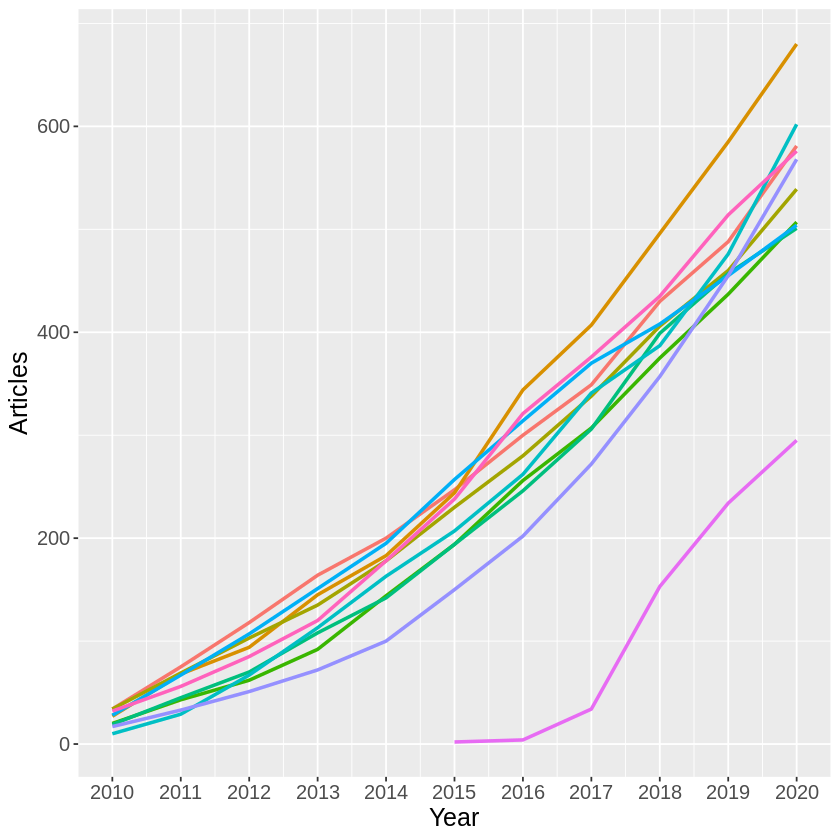

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.articles.coauthors.speed.png"


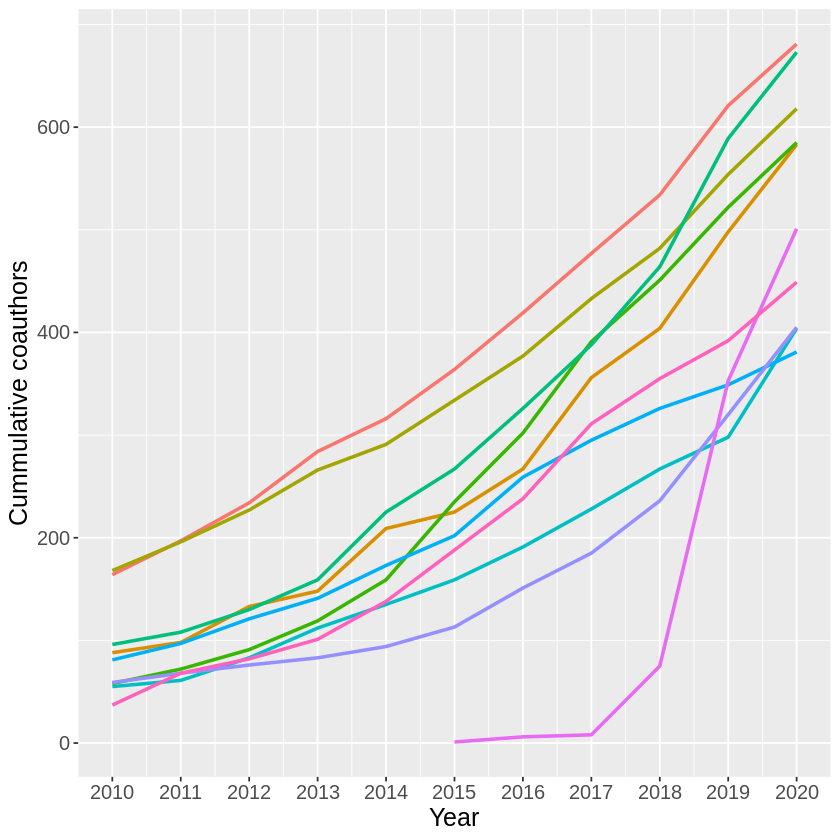

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.articles.publications.acceleration.png"


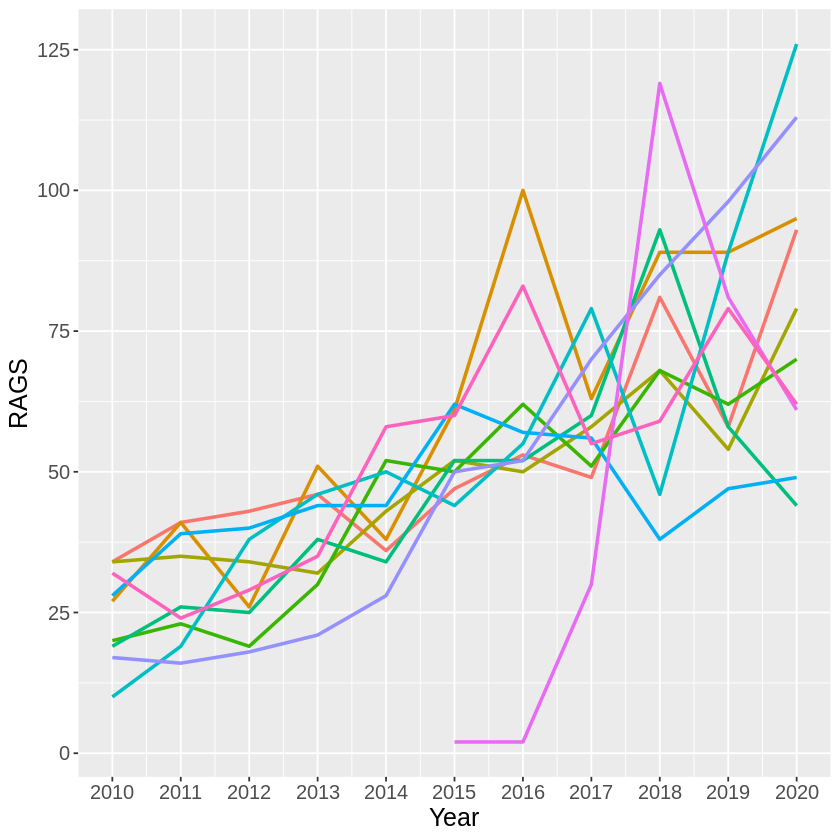

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.articles.coauthors.acceleration.png"


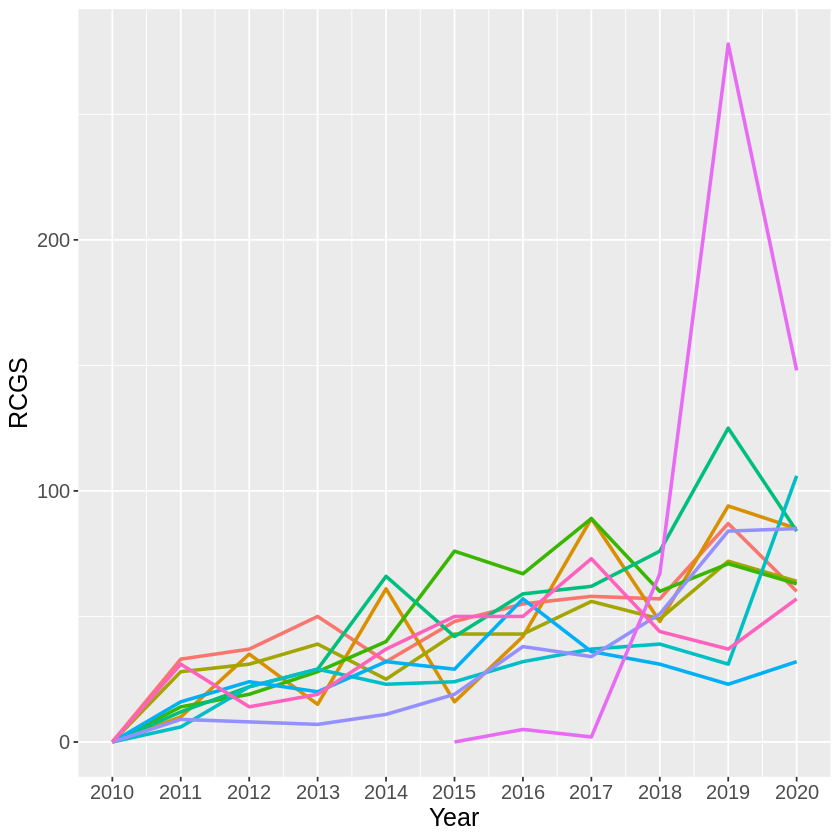

[1] "var.diff.articles"
[1] "mean.diff.articles.2.years"
[1] "var.diff.articles.2.years"
[1] "mean.diff.articles.3.years"
[1] "var.diff.articles.3.years"
[1] "mean.diff.articles.4.years"
[1] "var.diff.articles.4.years"
[1] "mean.diff.articles.5.years"
[1] "var.diff.articles.5.years"
[1] "mean.diff.cumulative.coauthors"
[1] "mean.diff.cumulative.coauthors"
 [1]  58620   1004 232142  40895 191362   8859   1675  25158  53641  23277
[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.cumulative.coauthors.cummulative.publications.png"


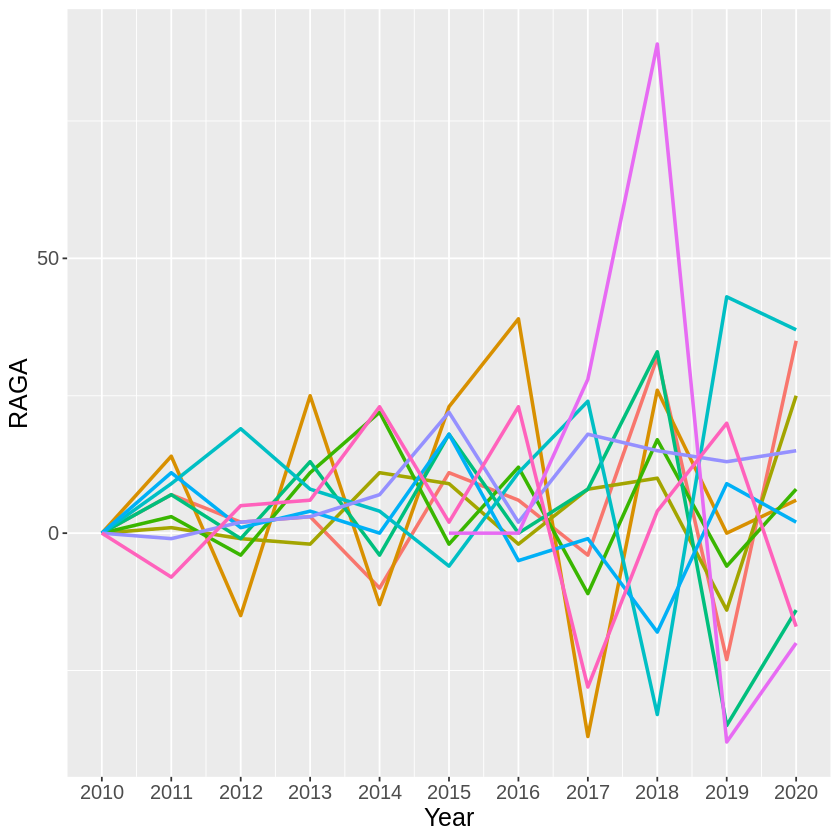

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.cumulative.coauthors.cummulative.coauthors.png"


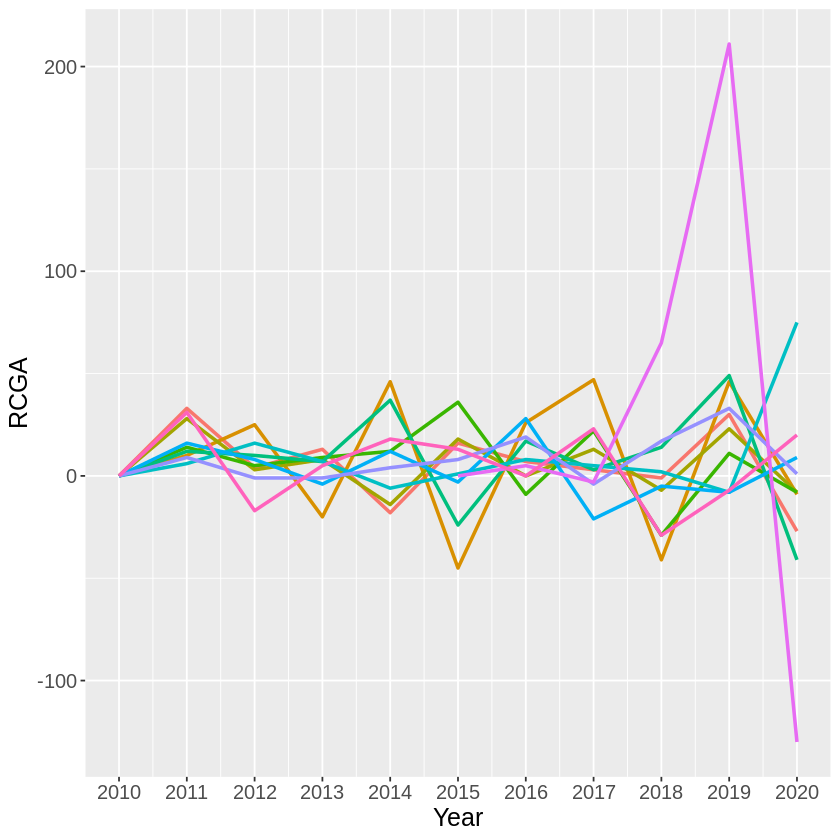

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.cumulative.coauthors.publications.speed.png"


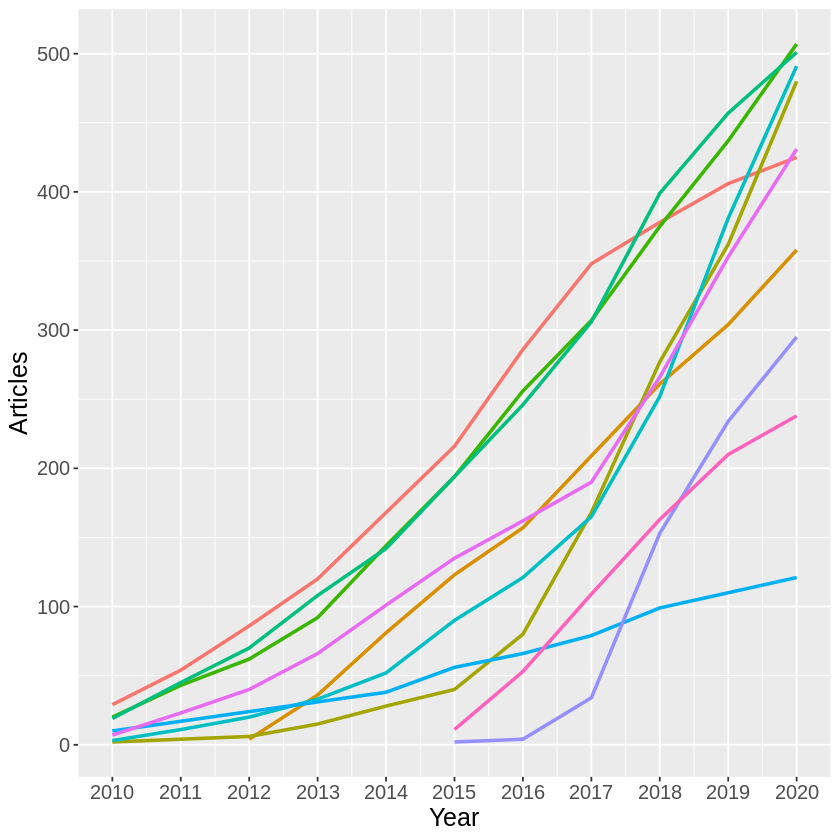

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.cumulative.coauthors.coauthors.speed.png"


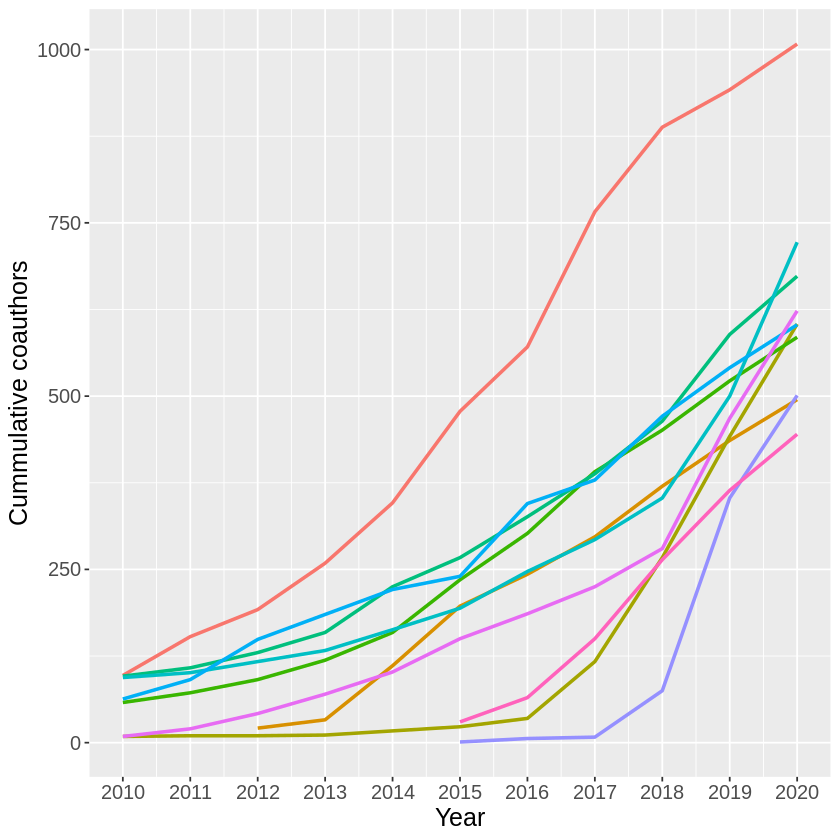

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.cumulative.coauthors.publications.acceleration.png"


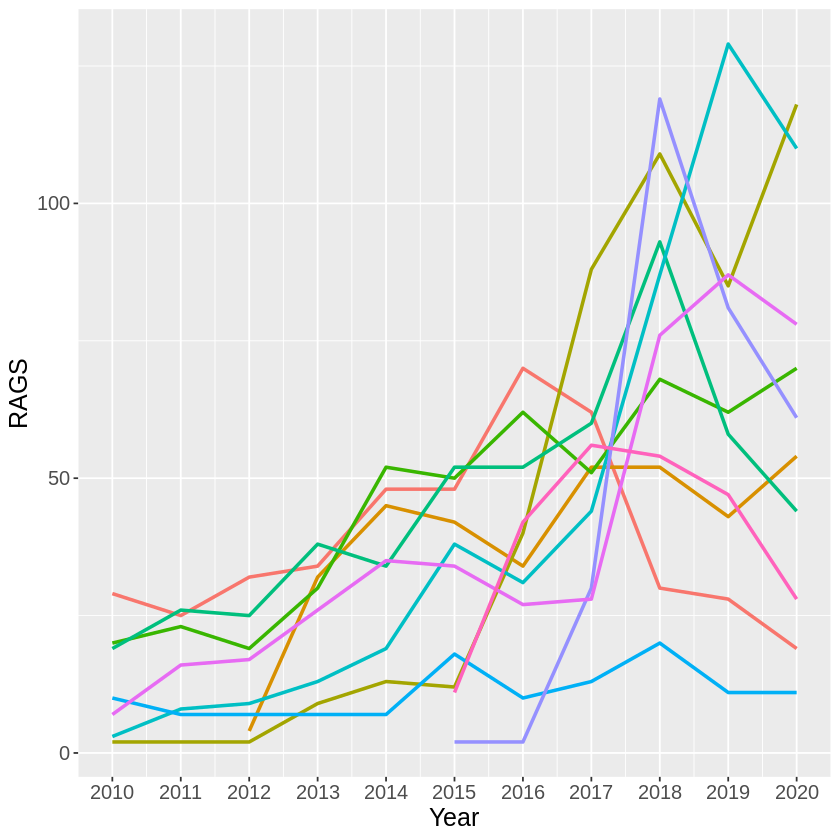

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.cumulative.coauthors.coauthors.acceleration.png"


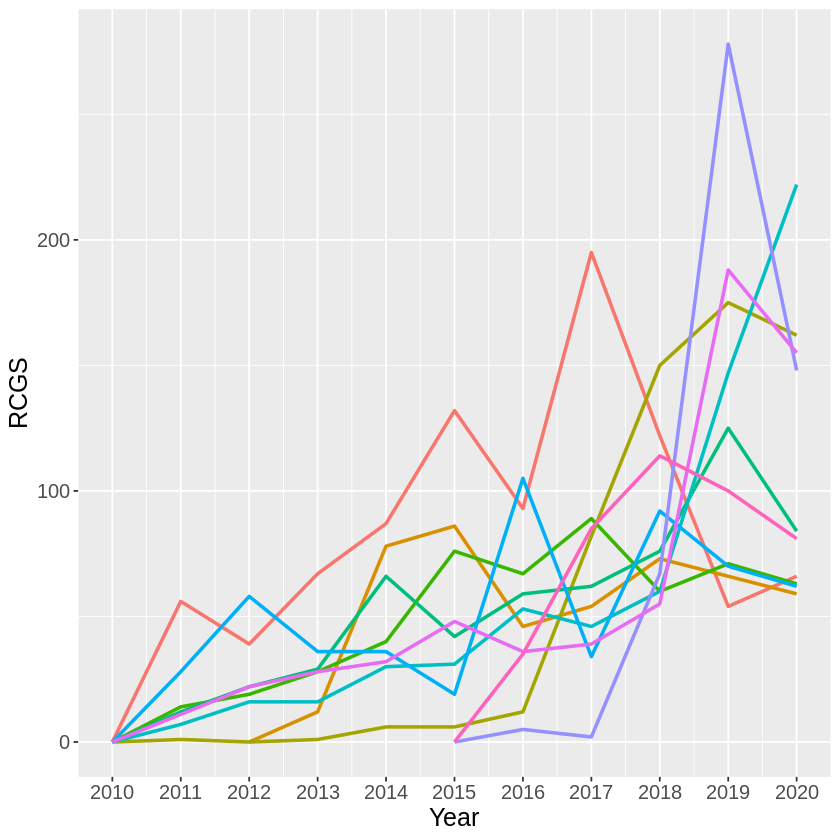

[1] "var.diff.cumulative.coauthors"
[1] "mean.diff.cumulative.coauthors.2.years"
[1] "var.diff.cumulative.coauthors.2.years"
[1] "mean.diff.cumulative.coauthors.3.years"
[1] "var.diff.cumulative.coauthors.3.years"
[1] "mean.diff.cumulative.coauthors.4.years"
[1] "var.diff.cumulative.coauthors.4.years"
[1] "mean.diff.cumulative.coauthors.5.years"
[1] "var.diff.cumulative.coauthors.5.years"
[1] "mean.diff.2.articles.up"
[1] "mean.diff.2.articles.up"
 [1]  58620  38901   3943   8859 232142  40895   1334  11188  41329   3307
[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.articles.up.cummulative.publications.png"


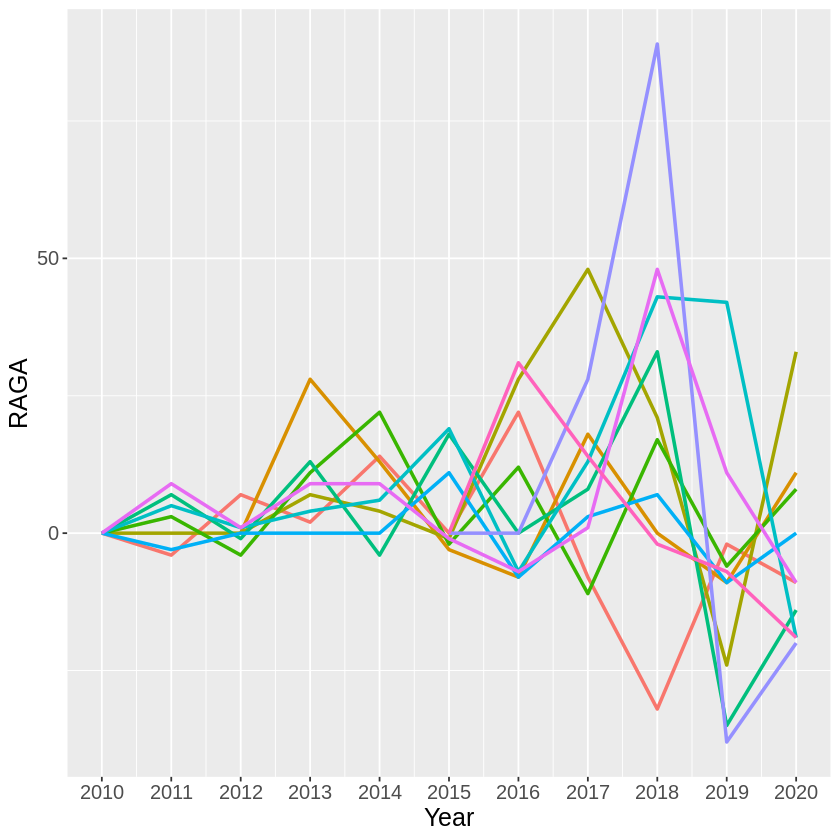

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.articles.up.cummulative.coauthors.png"


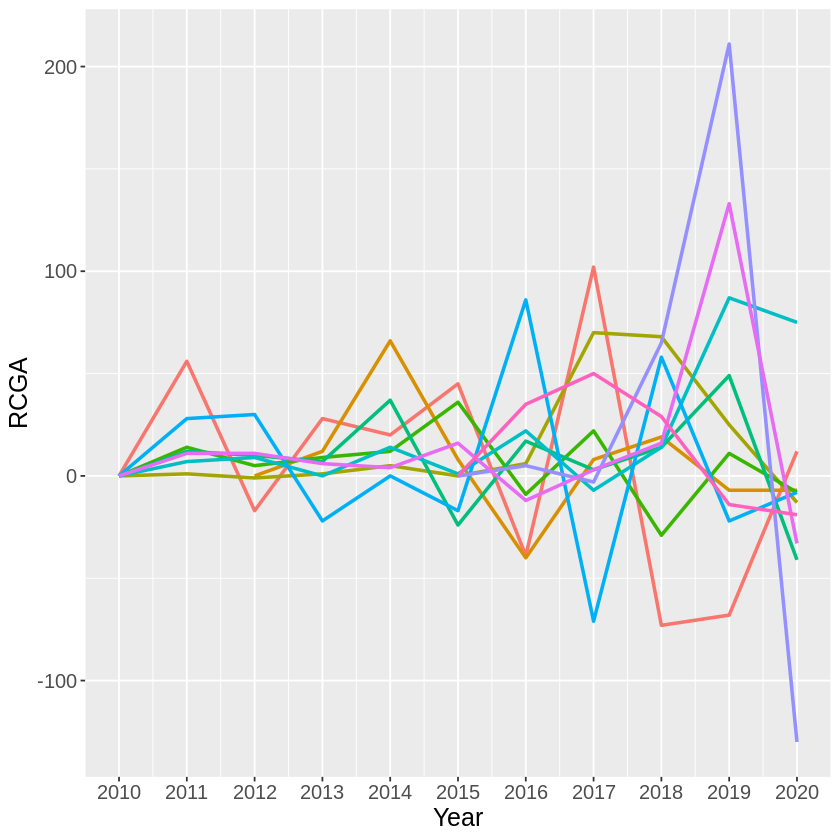

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.articles.up.publications.speed.png"


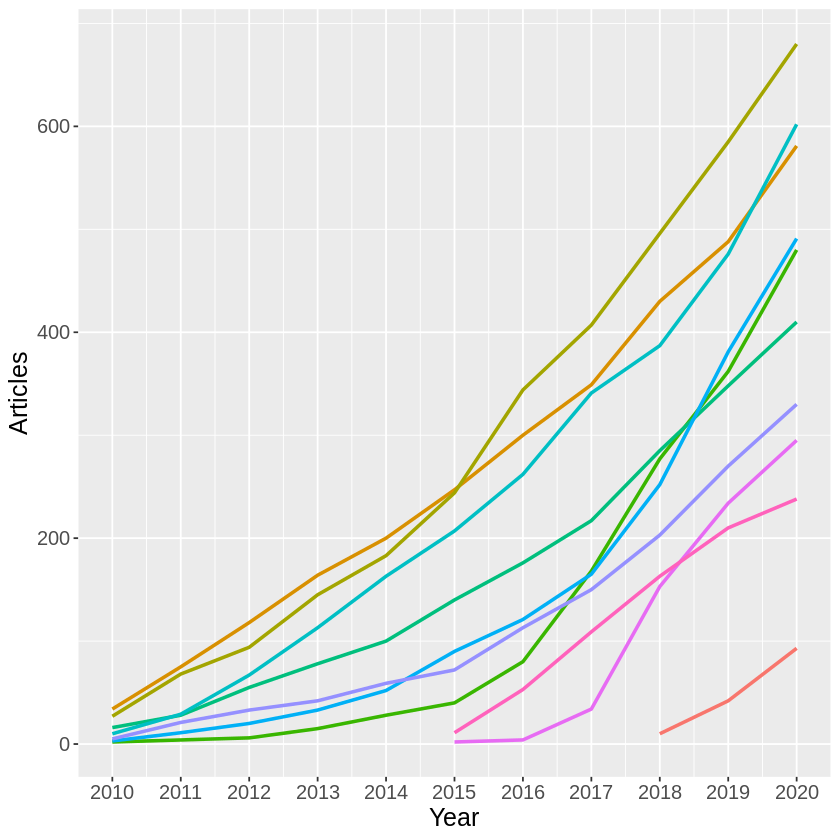

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.articles.up.coauthors.speed.png"


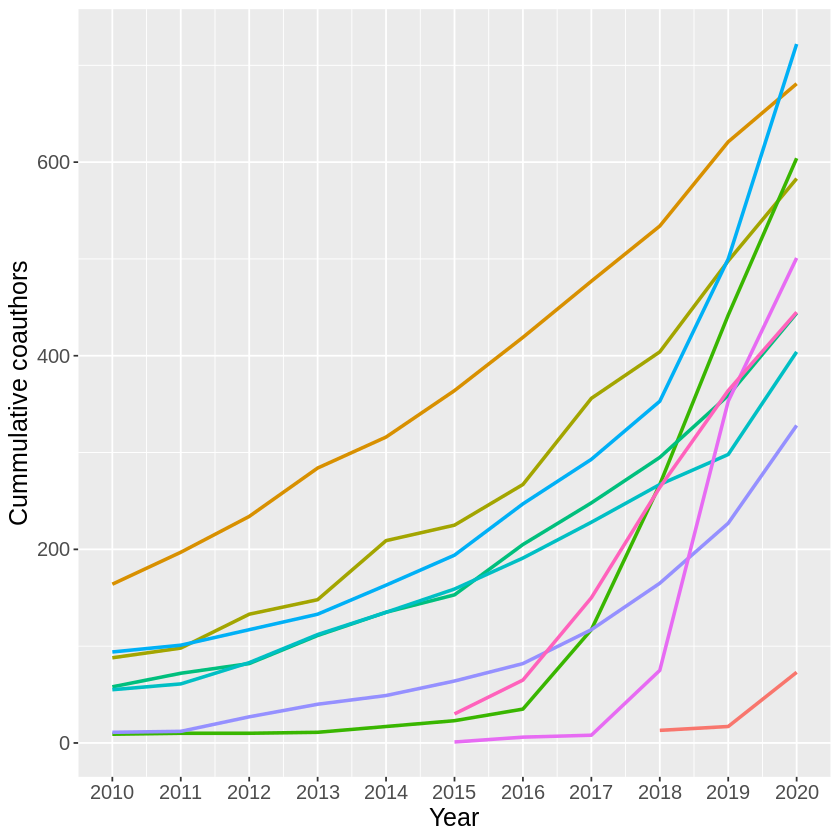

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.articles.up.publications.acceleration.png"


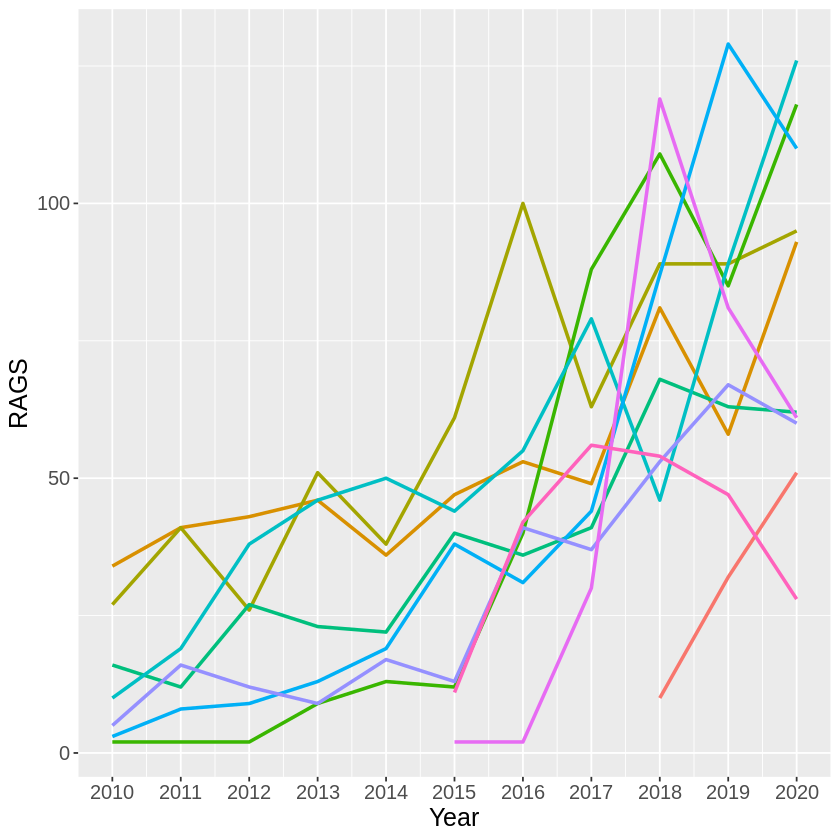

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.articles.up.coauthors.acceleration.png"


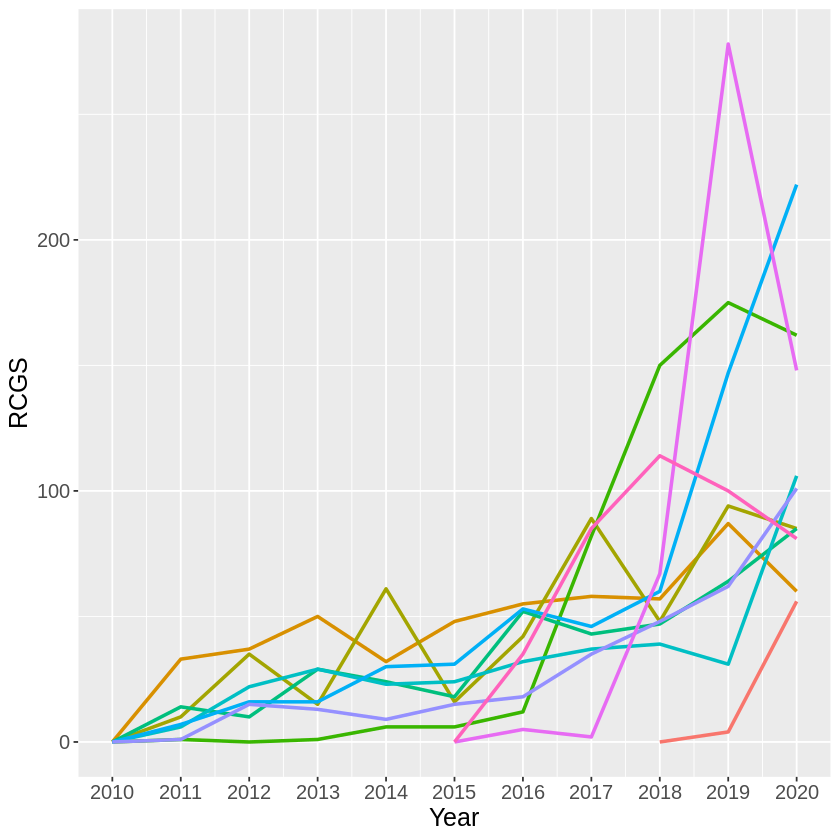

[1] "var.diff.2.articles.up"
[1] "mean.diff.2.articles.2.years.up"
[1] "var.diff.2.articles.2.years.up"
[1] "mean.diff.2.articles.3.years.up"
[1] "var.diff.2.articles.3.years.up"
[1] "mean.diff.2.articles.4.years.up"
[1] "var.diff.2.articles.4.years.up"
[1] "mean.diff.2.articles.5.years.up"
[1] "var.diff.2.articles.5.years.up"
[1] "mean.diff.2.cumulative.coauthors.up"
[1] "mean.diff.2.cumulative.coauthors.up"
 [1]  58620   1004  53641 376877 406843   2227   3943 232142  26965  16493
[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.cumulative.coauthors.up.cummulative.publications.png"


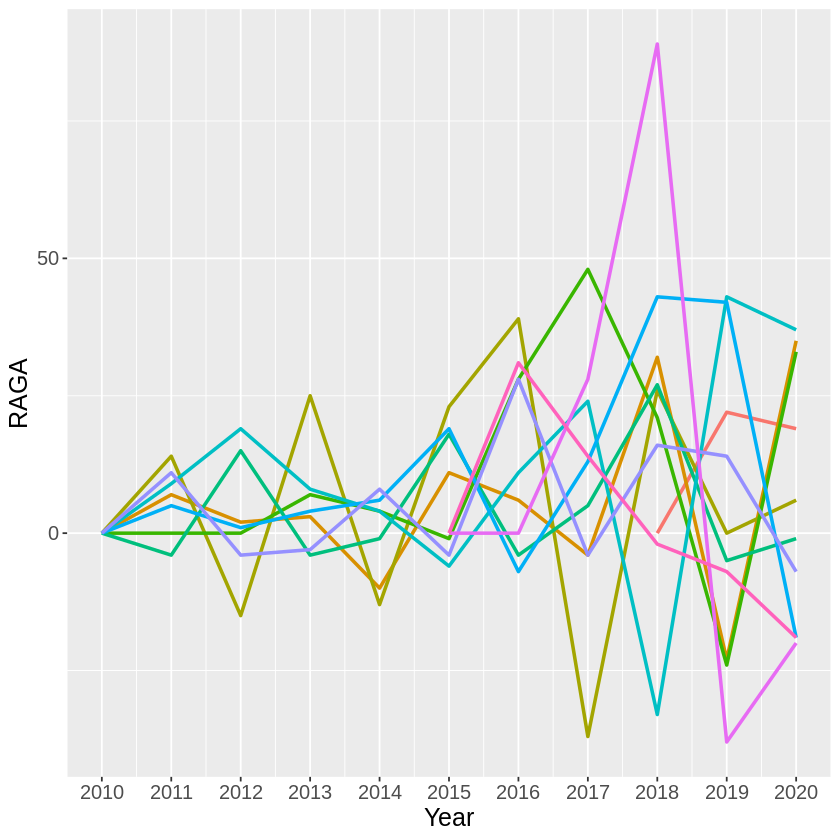

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.cumulative.coauthors.up.cummulative.coauthors.png"


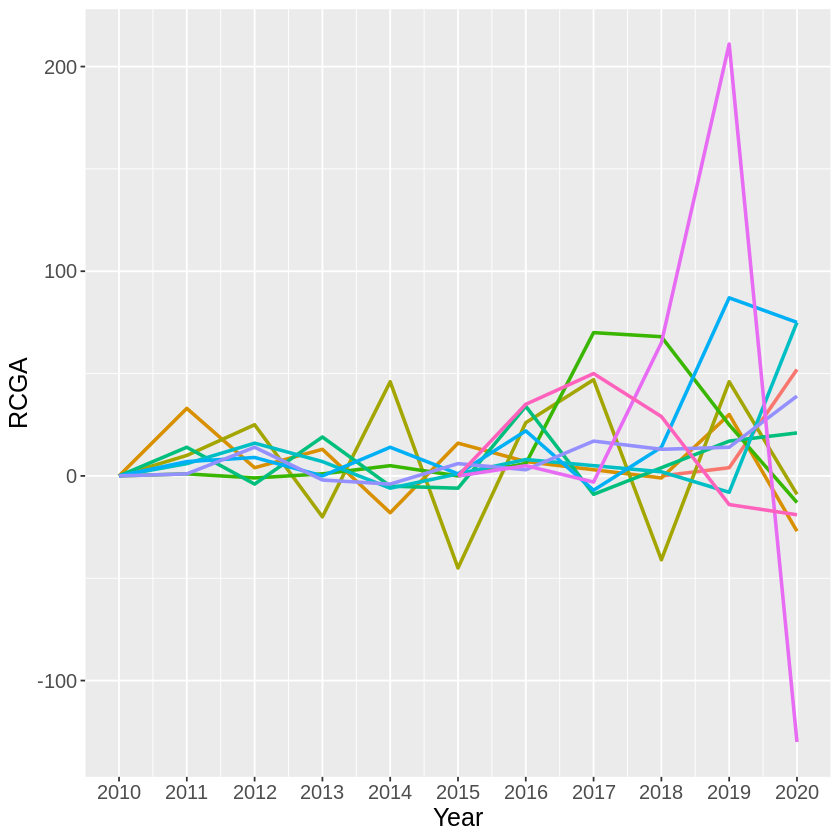

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.cumulative.coauthors.up.publications.speed.png"


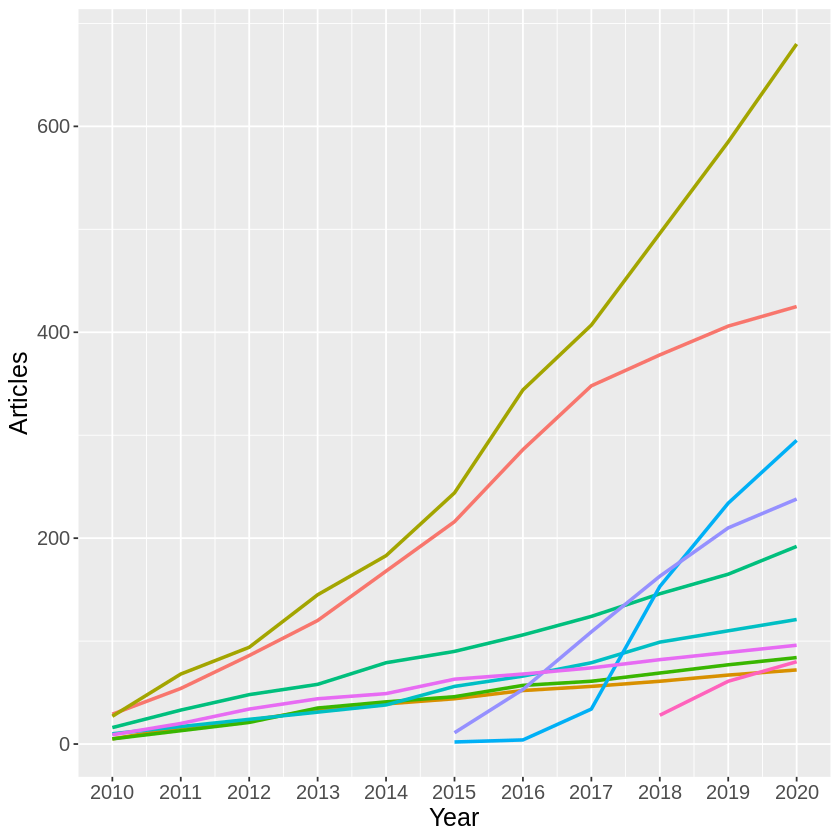

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.cumulative.coauthors.up.coauthors.speed.png"


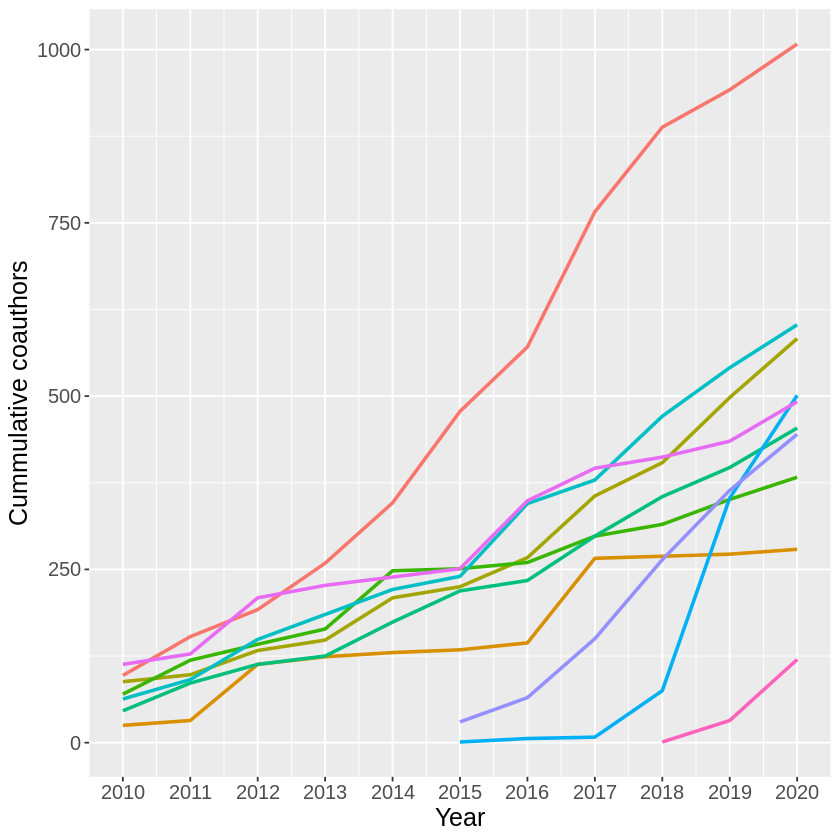

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.cumulative.coauthors.up.publications.acceleration.png"


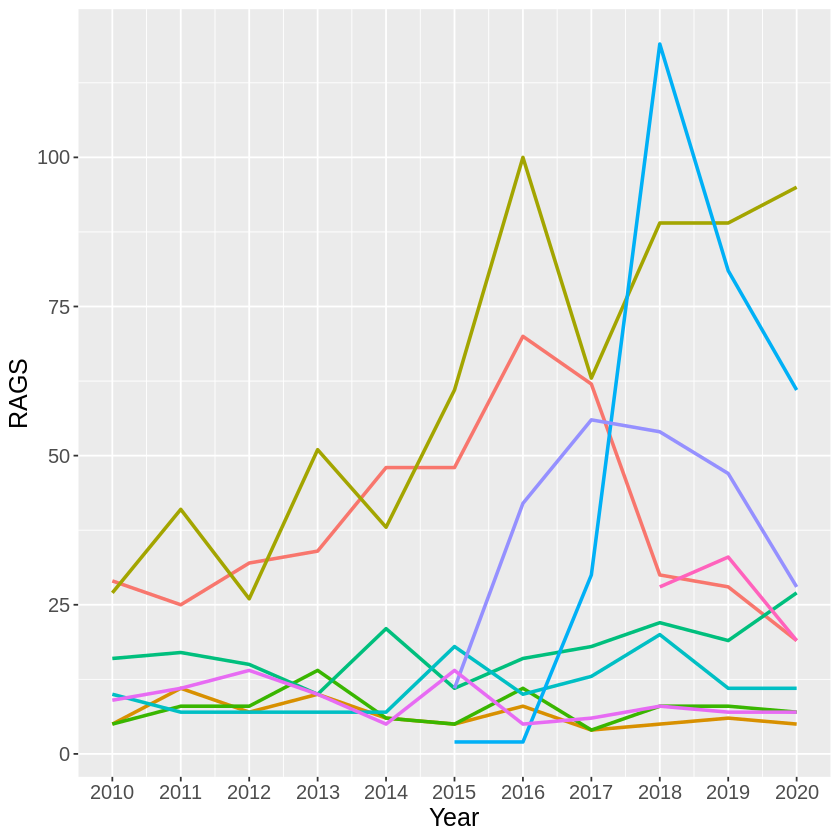

[1] "/tmp/articles/scientometrics/anomalous.for.feature.mean.diff.2.cumulative.coauthors.up.coauthors.acceleration.png"


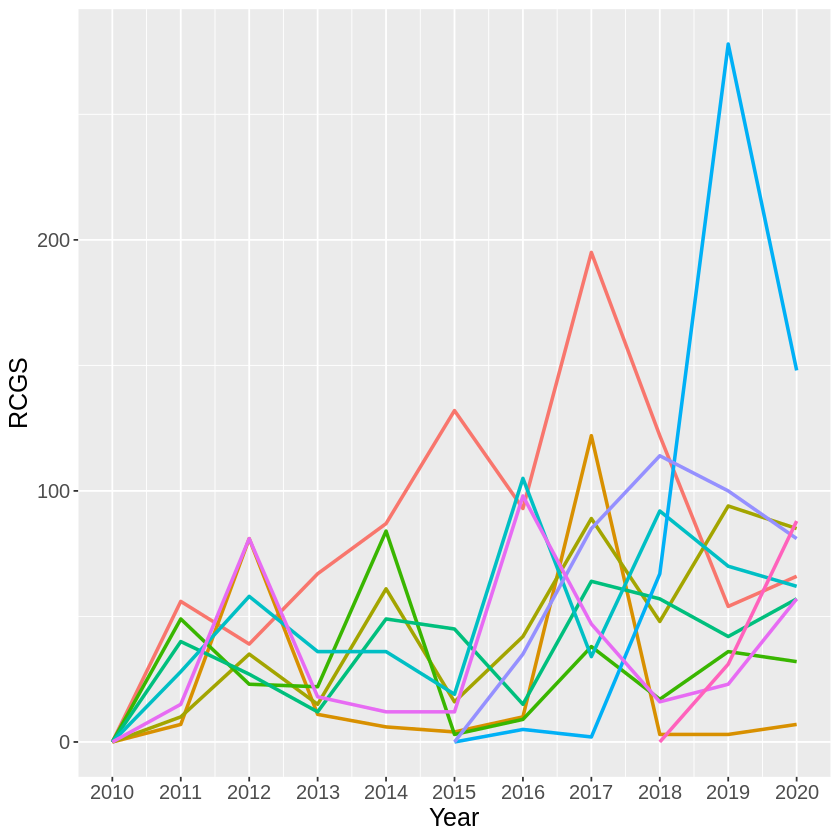

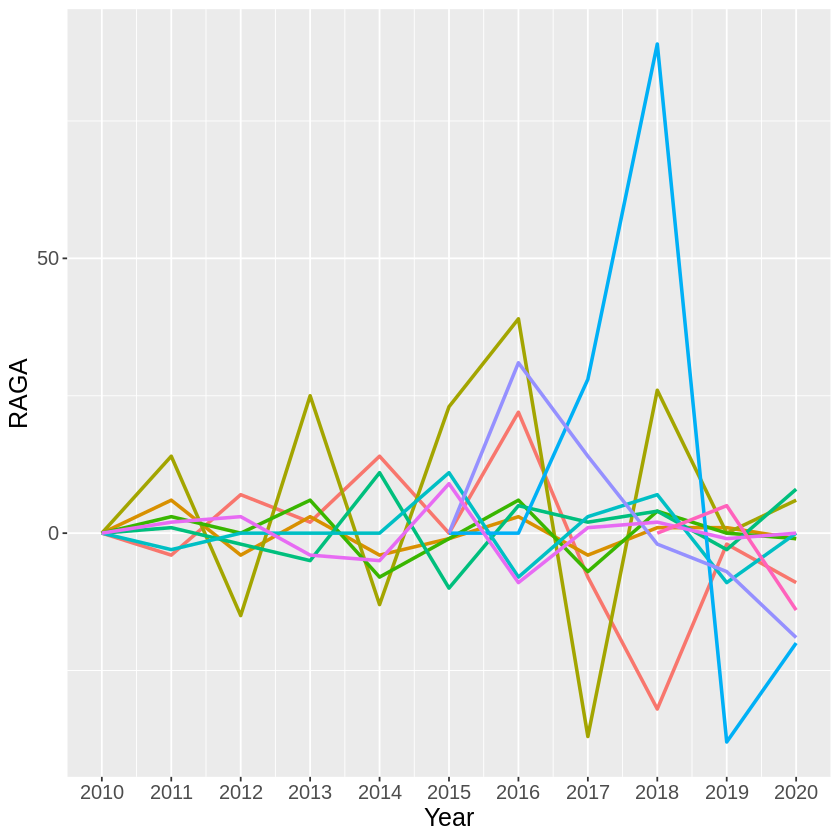

[1] "var.diff.2.cumulative.coauthors.up"
[1] "mean.diff.2.cumulative.coauthors.2.years.up"
[1] "var.diff.2.cumulative.coauthors.2.years.up"
[1] "mean.diff.2.cumulative.coauthors.3.years.up"
[1] "var.diff.2.cumulative.coauthors.3.years.up"
[1] "mean.diff.2.cumulative.coauthors.4.years.up"
[1] "var.diff.2.cumulative.coauthors.4.years.up"
[1] "mean.diff.2.cumulative.coauthors.5.years.up"
[1] "var.diff.2.cumulative.coauthors.5.years.up"
[1] "entropy.opposite"
[1] "mean.author.minus.venue.context.zscore"


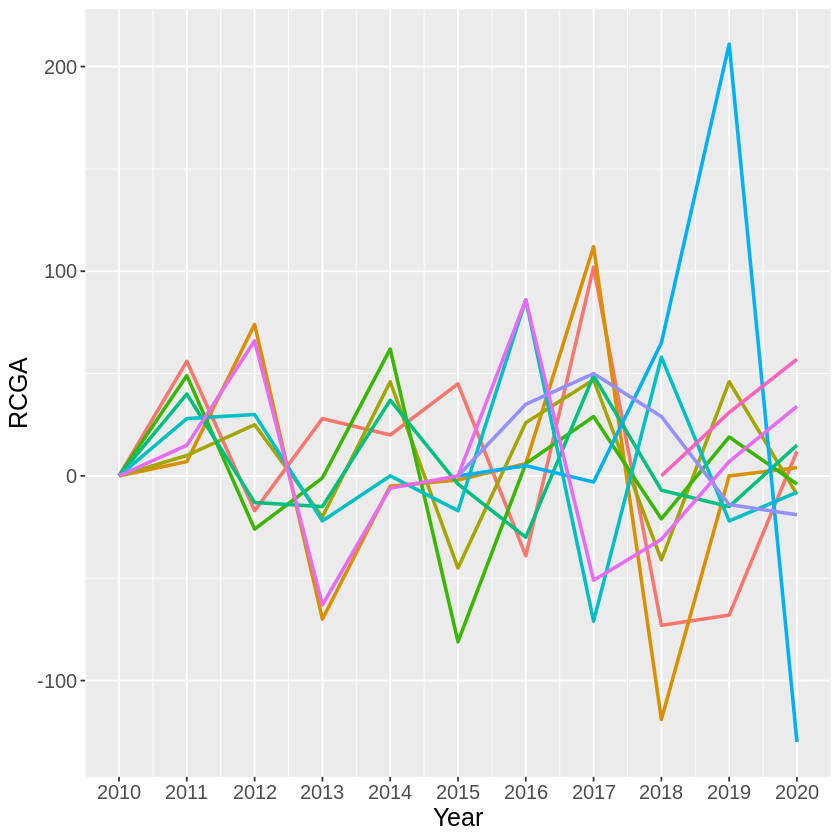

In [44]:
features.to.plot <- c(
    "diff.articles",
    "diff.2.articles",
    "diff.cumulative.coauthors",
    "diff.2.cumulative.coauthors"
)
x <- lapply(outlierness, function(anom) {
    print(anom$feature1)
    if (
        anom$feature1 %in% paste("mean.",features.to.plot, sep="") || 
        anom$feature1 %in% paste("mean.",features.to.plot,".up", sep="")
    ) {
        print(anom$feature1)
        print(features[order(-anom$outlier.rank),]$Node[1:10])
        plot.authors.behavior(
            features[order(-anom$outlier.rank),]$Node[1:10],
            all.t, 
            paste0("anomalous.for.feature.", anom$feature1))
    }
})

### Discriminative features

In [45]:
plots.dir <- "/tmp/articles/scientometrics/"

In [46]:
ecdfs <- list()
for (year in unique(all.publications.years$Time)) {
    df.year <- all.publications.years[all.publications.years$Time == year,]
    df.year.data <- df.year$articles
    df.year.data <- df.year.data[!is.na(df.year.data)]
    
    min.val <- min(df.year.data, na.rm=T)
    max.val <- max(df.year.data, na.rm=T)
    
    step <- 1#(max.val-min.val)/100
    
    slots <- seq(min.val, max.val+step, by=step)

    ecdf.data <- sapply(slots, function(slt) {
        sum(df.year.data <= slt) / length(df.year.data)
    })
    ecdfs[[as.character(year)]] <- data.frame(x=c(0,slots), y=c(0,ecdf.data))
}

[1] "year: 2010, 95%"
    x         y
13 12 0.9462139
[1] 36
[1] "year: 2010, 99%"
    x         y
20 19 0.9885817
[1] "year: 2010, author >= 19 articles"
[1] 0.9885817
[1] "year: 2020, 95%"
    x         y
27 26 0.9483156
[1] 126
[1] "year: 2020, 99%"
    x        y
45 44 0.989617
[1] "year: 2020, author >= 19 articles"
[1] 0.8929395
[1] "/tmp/articles/scientometrics/ecdf_2010_2020.png.png"


png 
  2

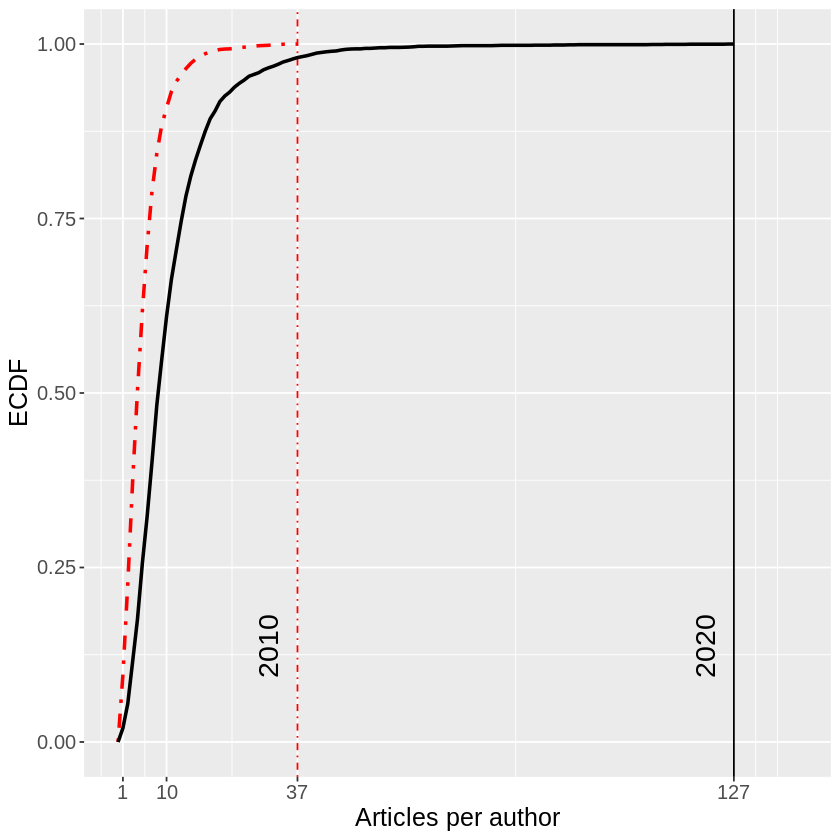

In [47]:
years <- sort(names(ecdfs))

colfunc <- colorRampPalette(c("red","black"))
linetype <- c("dotdash", "solid")
colors <- colfunc(length(names(ecdfs)))
names(colors) <- sort(names(ecdfs))

p <- ggplot()

years <- c("2010", "2020")

names(linetype) <- sort(years)

x.labels <- c()
min.99 <- list()

# Number of articles covering 99% of the population in 2010
NUM.PUBS.99.2010 <- 19

for (year in years) {
    df <- ecdfs[[year]]
    print(paste("year: ", year, ", 95%", sep=""))
    print(df[sum(df$y < 0.95),])
    print(
        max(
            all.publications.years[all.publications.years$Time == year,]$articles,
            na.rm=T
        )
    )
    print(paste("year: ", year, ", 99%", sep=""))
    print(df[sum(df$y < 0.99),])
        
    print(paste("year: ", year, ", author >= 19 articles", sep=""))
    print(df[df$x >= 19,]$y[1])
    
    min.99[[year]] <- df[sum(df$y < 0.99),]$x
    x.labels <- c(x.labels, max(ecdfs[[year]]$x))
    p <- p +
        geom_line(
            data=ecdfs[[year]], 
            aes(x=x, y=y), 
            color=colors[year], 
            linetype=linetype[year],
            size=1
        ) +
        geom_vline(
            xintercept=max(ecdfs[[year]]$x), 
            color=colors[year], 
            linetype=linetype[year]
        )
}
breaks <- c(1, 10, max(ecdfs[["2010"]]$x), max(ecdfs[["2020"]]$x))
p <- p +
    geom_text(
         data=data.frame(x=x.labels, label=years),
         mapping = aes(x = x,
                       y = 0,
                       angle = 90,
                       hjust = -1,
                       vjust = -1,
                       label=years
         ),
        size=6
    ) +
    scale_x_continuous(
       #trans="log10",
        limits=c(NA,140),
        breaks=breaks
    ) +
#    labs(
#        y="",
#        x="Articles"
#    ) +
    theme(
       #legend.position = "none", 
       text = element_text(size=15),
       #axis.title.x="Articles per athor",# element_blank(),
       #axis.title.y="ECDF",#element_blank(),
    ) +
    labs(
      x = "Articles per author",
      y = "ECDF"
    )
    save.plot(p, "ecdf_2010_2020.png")
p

#### Most prolific authors by 2010

In [48]:
df.2010 <- all.publications.years[all.publications.years$Time == 2010,]
df.2010 <- df.2010[!is.na(df.2010$articles),]
df.2010 <- df.2010[df.2010$articles > min.99[["2010"]],]

prolific.2010 <- df.2010$Node

In [49]:
length(prolific.2010)
nrow(all.publications.years[all.publications.years$Time == 2010,])
x <- all.publications.years %>% group_by(Node) %>% summarize(all.pubs = sum(articles))
head(x[order(x$all.pubs),])

[1] 38

[1] 3328

Node all.pubs
1  914 50      
2 1591 50      
3 1596 50      
4 1681 50      
5 1714 50      
6 1745 50

#### Most prolific authors by 2020

In [50]:
df.2020 <- all.publications.years[all.publications.years$Time == 2020,]
df.2020 <- df.2020[!is.na(df.2020$articles),]
df.2020.baseline <- df.2020[df.2020$articles > min.99[["2020"]],]

# Only top 100 authors
#df.2020 <- df.2020[order(-df.2020$articles) <= 100,]

#head(df.2020)

prolific.2020 <- df.2020$Node
prolific.2020.baseline <- df.2020.baseline$Node
length(prolific.2020.baseline)

[1] 45

In [51]:
names(df.2020[df.2020$articles > 120,])
df.2020[df.2020$articles > 120,c("coauthors", "coauthor.cumsum")]

[1] "Node"            "Time"            "articles"        "coauthors"      
[5] "Entropy.model.4" "coauthor.cumsum"

coauthors coauthor.cumsum
597534 69        404

In [52]:
nrow(df.2020)
print(
    length(
        unique(
            df.2020[
                df.2020$articles >= NUM.PUBS.99.2010,
            ]$Node
        )
    )
)

[1] 4334

[1] 540


#### Venues birth year

In [53]:
venue.birth <- author.venue.year %>%
    group_by(venue) %>%
    summarize(
        birth.year = min(time)
    )
venue.birth <- venue.birth[order(venue.birth$birth.year),]
venue.birth %>% group_by(birth.year) %>% summarize(count=n())

birth.year count
1  2010       1458 
2  2011        203 
3  2012        128 
4  2013        220 
5  2014        178 
6  2015        158 
7  2016        117 
8  2017         75 
9  2018        104 
10 2019         96 
11 2020         98

In [54]:
venue.time <- unique(author.venue.year[,c("venue", "time")])
venue.time <- venue.time %>% 
    group_by(time) %>%
    summarize(count = n())

#### Features plots for baseline and top ranked authors

In [55]:
baseline.authors <- prolific.2020.baseline

[1] "mean.diff.articles"
[1] "mean.diff.articles, 3943, , last: , 95, , max: , 100, , min: , 26"


Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


[1] "/tmp/articles/scientometrics/comparative.behavior.3943.diff.articles.png"
[1] "mean.diff.2.articles.up"
[1] "mean.diff.2.articles.up, 58620, , last: , -20, , max: , 89, , min: , -38"


Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


[1] "/tmp/articles/scientometrics/comparative.behavior.58620.diff.2.articles.png"
[1] "mean.diff.cumulative.coauthors"
[1] "mean.diff.cumulative.coauthors, 58620, , last: , 148, , max: , 278, , min: , 0"


Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


[1] "/tmp/articles/scientometrics/comparative.behavior.58620.diff.cumulative.coauthors.png"


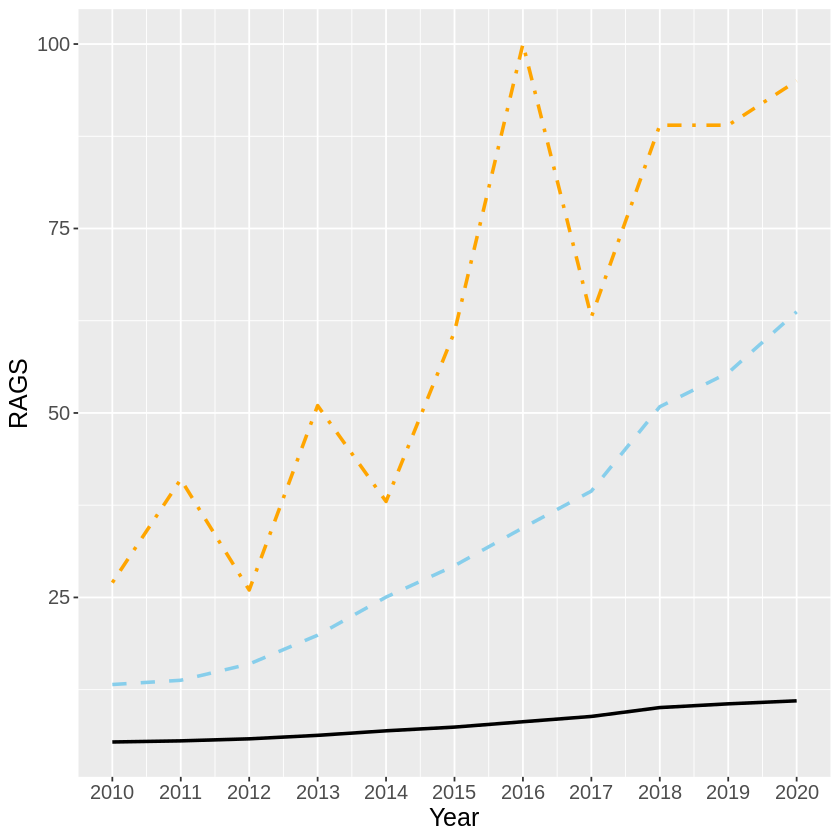

[1] "mean.diff.2.cumulative.coauthors.up"
[1] "mean.diff.2.cumulative.coauthors.up, 58620, , last: , -130, , max: , 211, , min: , -130"


Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


[1] "/tmp/articles/scientometrics/comparative.behavior.58620.diff.2.cumulative.coauthors.png"


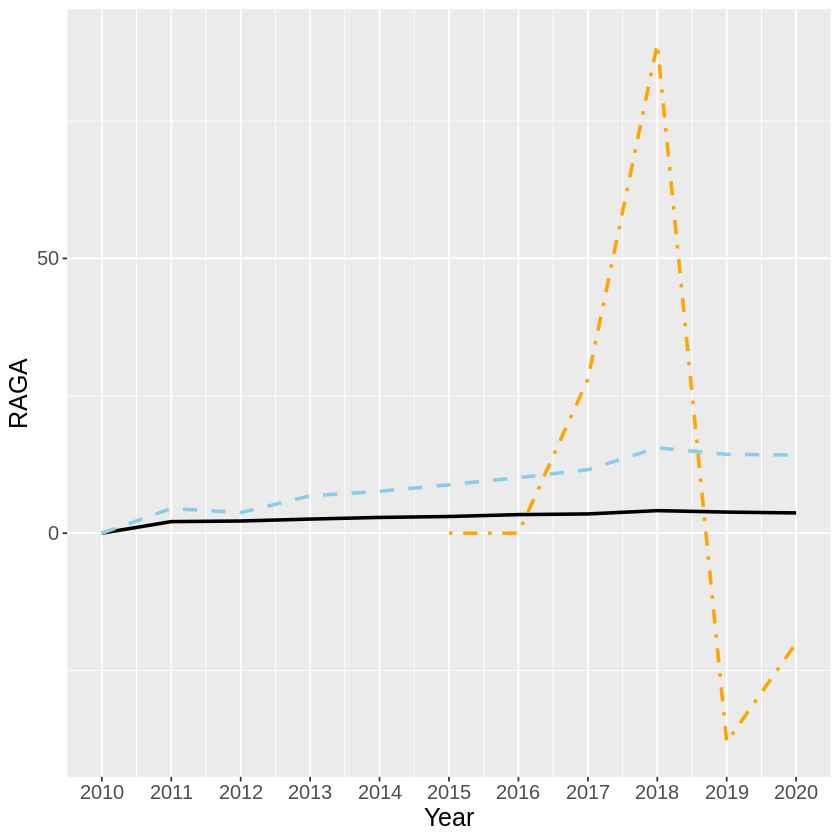

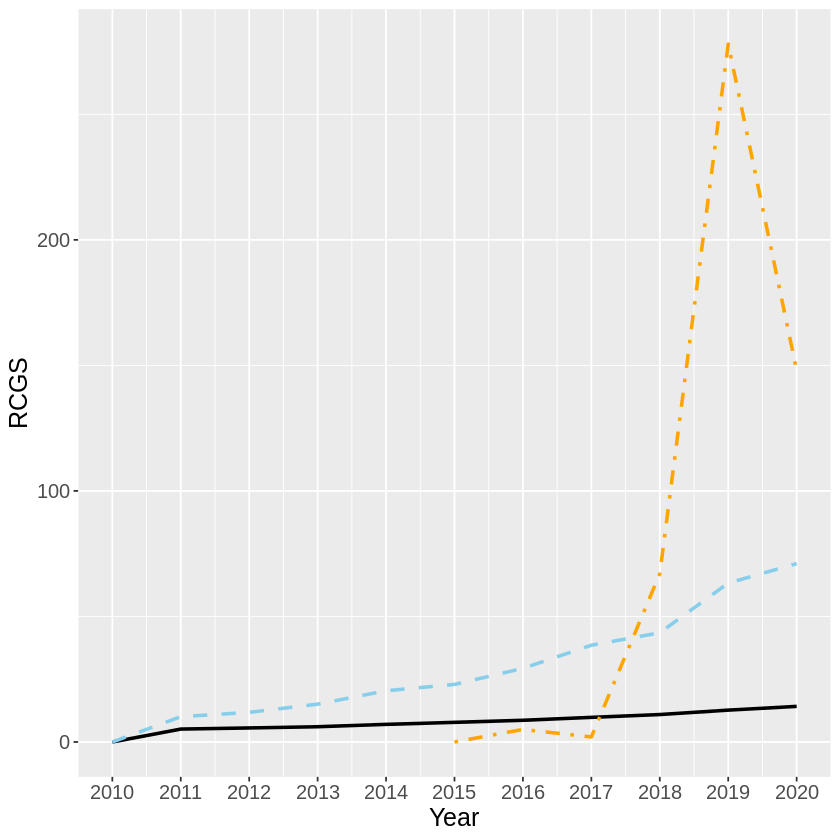

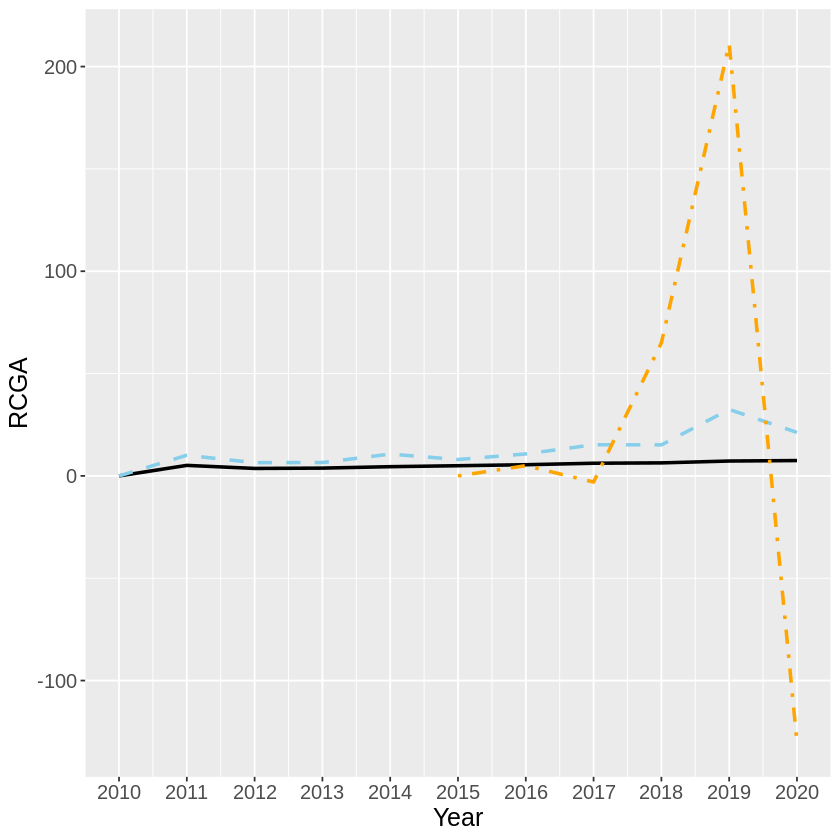

In [56]:
features.names.1 <- c(
        diff.articles = "RAGS",
        diff.2.articles = "RAGA",
        diff.cumulative.coauthors = "RCGS",
        diff.2.cumulative.coauthors = "RCGA" 
)

authors.feats <- lapply(names(features.names.1), function(col) {
    feature.name <- paste0("mean.", col)
    if (grepl("diff.2", feature.name, fixed = TRUE)) {
        feature.name <- paste0(feature.name, ".up")
    }
    print(feature.name)
    max.col <- which.max(features[,feature.name])
    author <- features[max.col, "Node"]
    feature <- all.t[all.t$Node == author & all.t$Time == 2020, col]
    
    max.feature <- max(all.t[all.t$Node == author, col])
    min.feature <- min(all.t[all.t$Node == author, col])
    
    print(paste(feature.name, author, ", last: ", feature, ", max: ", max.feature, ", min: ", min.feature, sep=", "))
    
    plot.author.behavior.2(
        author, 
        baseline.authors,
        all.t, 
        col, 
        features.names.1,
        baseline.authors
    )
})


features.names <- c(
        "mean.diff.articles",
        "var.diff.articles",
        "mean.diff.2.articles.up",
        "var.diff.2.articles.up",
        "entropy.opposite",
        "mean.diff.cumulative.coauthors",
        "var.diff.cumulative.coauthors",
        "mean.diff.2.cumulative.coauthors.up",
        "var.diff.2.cumulative.coauthors.up",
        "mean.author.minus.venue.context.zscore"
)

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


[1] "/tmp/articles/scientometrics/comparative.behavior.40895.diff.articles.png"


Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


[1] "/tmp/articles/scientometrics/comparative.behavior.40895.diff.2.articles.png"


Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


[1] "/tmp/articles/scientometrics/comparative.behavior.40895.diff.cumulative.coauthors.png"


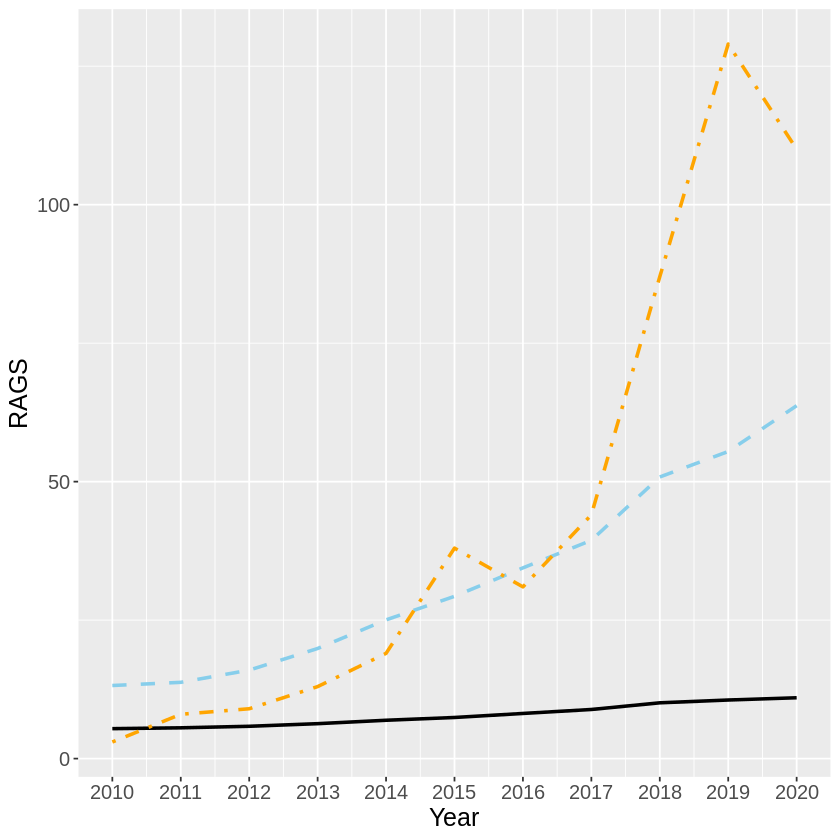

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


[1] "/tmp/articles/scientometrics/comparative.behavior.40895.diff.2.cumulative.coauthors.png"


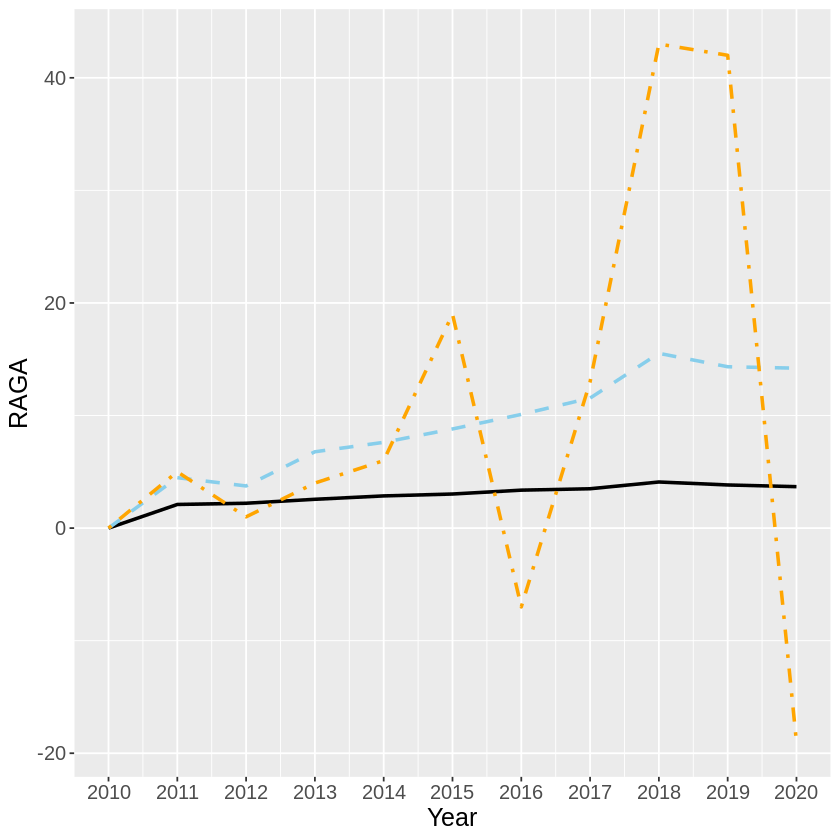

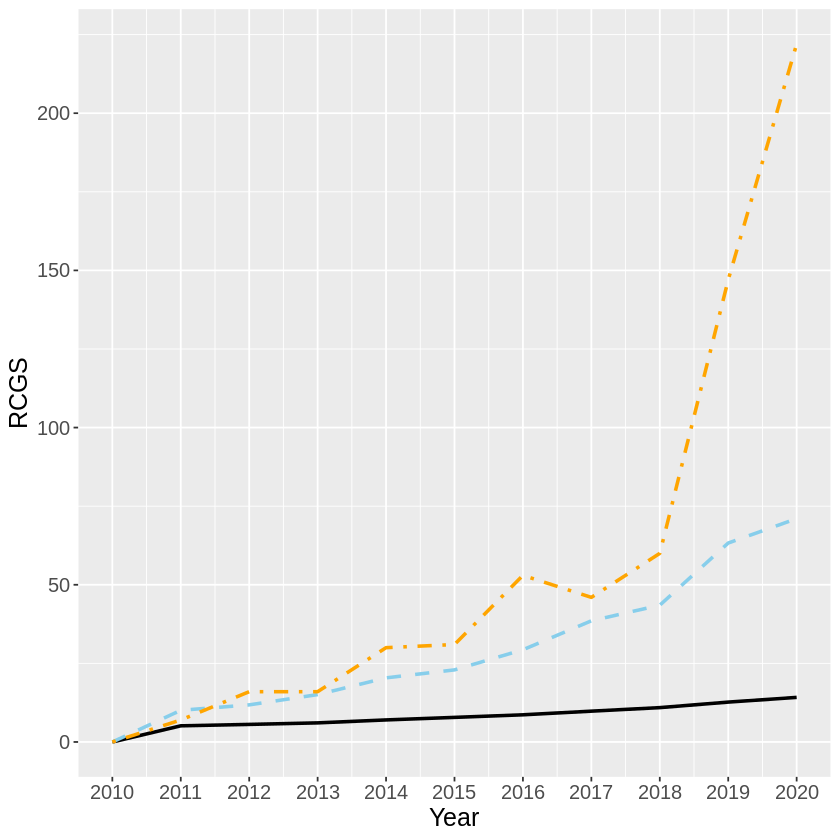

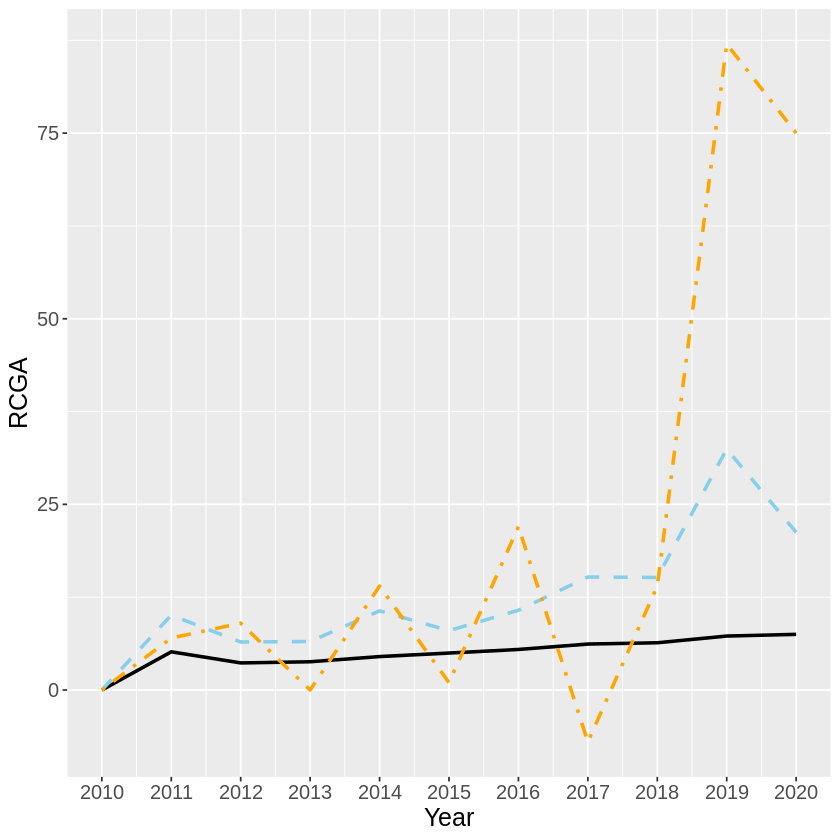

In [57]:
authors.list <- c("40895")
plot.author.behavior.2(
    authors.list, 
    baseline.authors,
    all.t, 
    names(features.names.1), 
    features.names.1,
    baseline.authors
)

Plot the ECDF for each feature

[1] "mean.diff.articles"
[1] "var.diff.articles"
[1] "mean.diff.cumulative.coauthors"
[1] "var.diff.cumulative.coauthors"
[1] "mean.diff.2.articles.up"
[1] "var.diff.2.articles.up"
[1] "mean.diff.2.cumulative.coauthors.up"
[1] "var.diff.2.cumulative.coauthors.up"
[1] "entropy.opposite"
[1] "mean.author.minus.venue.context.zscore"
[1] "mean.diff.articles"
[1] 4.636364
[1] 61.81818
[1] 4.636364
[1] 61.81818
[1] "val99:  25.7936363636364"
[1] "/tmp/articles/scientometrics/ecdf.mean.diff.articles.png"
[1] "var.diff.articles"
[1] 0.3015113
[1] 46.72745
[1] 0.3015113
[1] 46.72745
[1] "val99:  15.6220709665154"
[1] "/tmp/articles/scientometrics/ecdf.var.diff.articles.png"


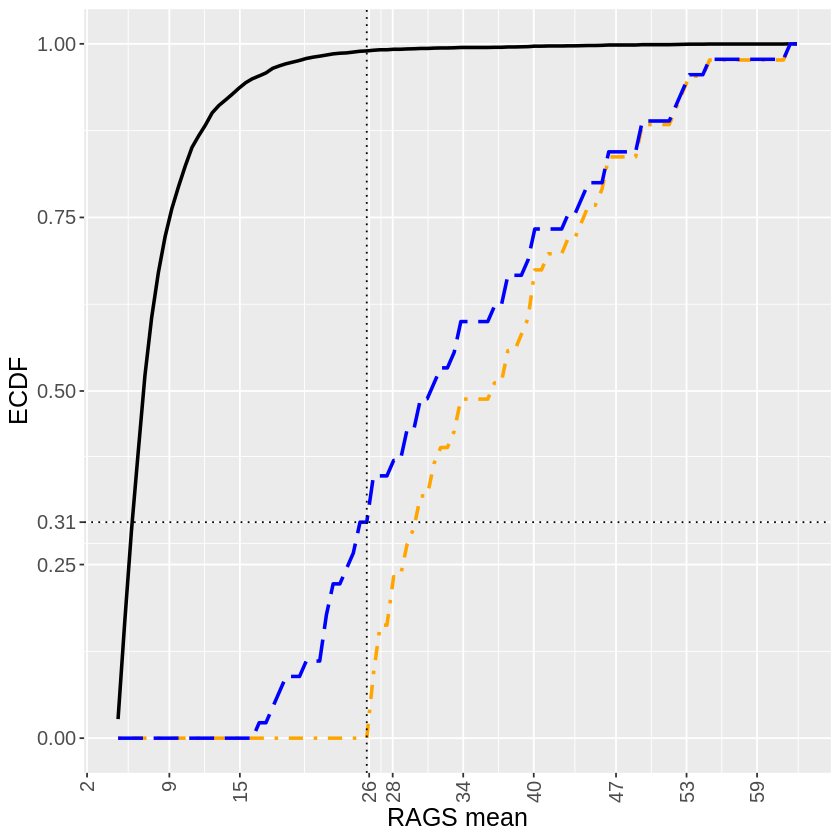

[1] "mean.diff.cumulative.coauthors"
[1] 0
[1] 83.33333
[1] 0
[1] 83.33333
[1] "val99:  29.1666666666667"
[1] "/tmp/articles/scientometrics/ecdf.mean.diff.cumulative.coauthors.png"


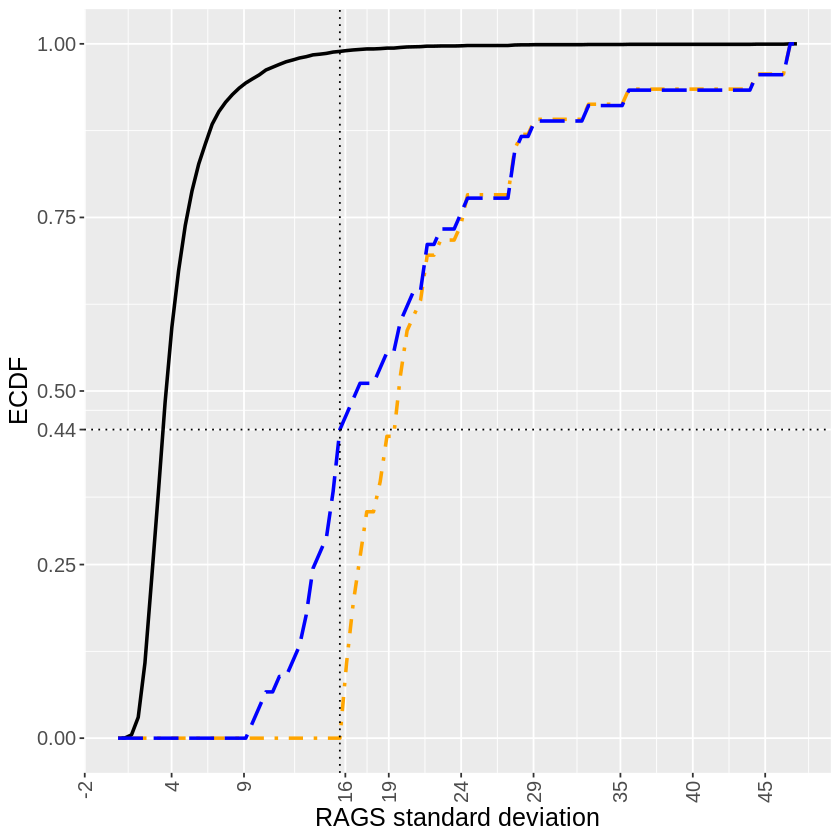

[1] "var.diff.cumulative.coauthors"
[1] 0
[1] 9.128709
[1] 0
[1] 9.128709
[1] "val99:  5.38593848213413"
[1] "/tmp/articles/scientometrics/ecdf.var.diff.cumulative.coauthors.png"


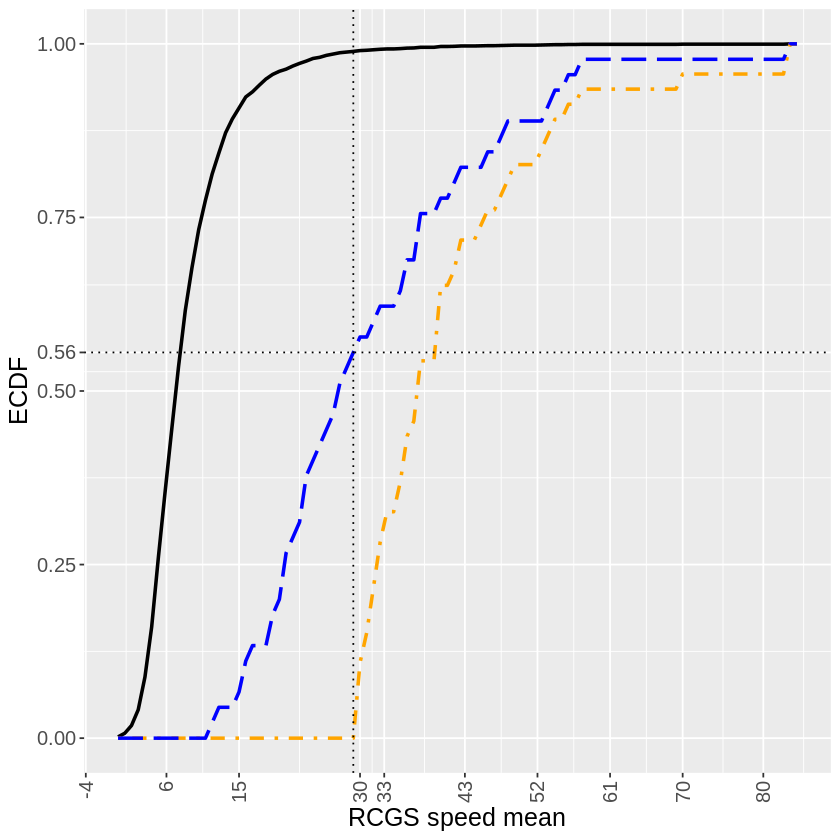

[1] "mean.diff.2.articles.up"
[1] 0
[1] 29.25
[1] 0
[1] 29.25
[1] "val99:  8.4825"
[1] "/tmp/articles/scientometrics/ecdf.mean.diff.2.articles.up.png"


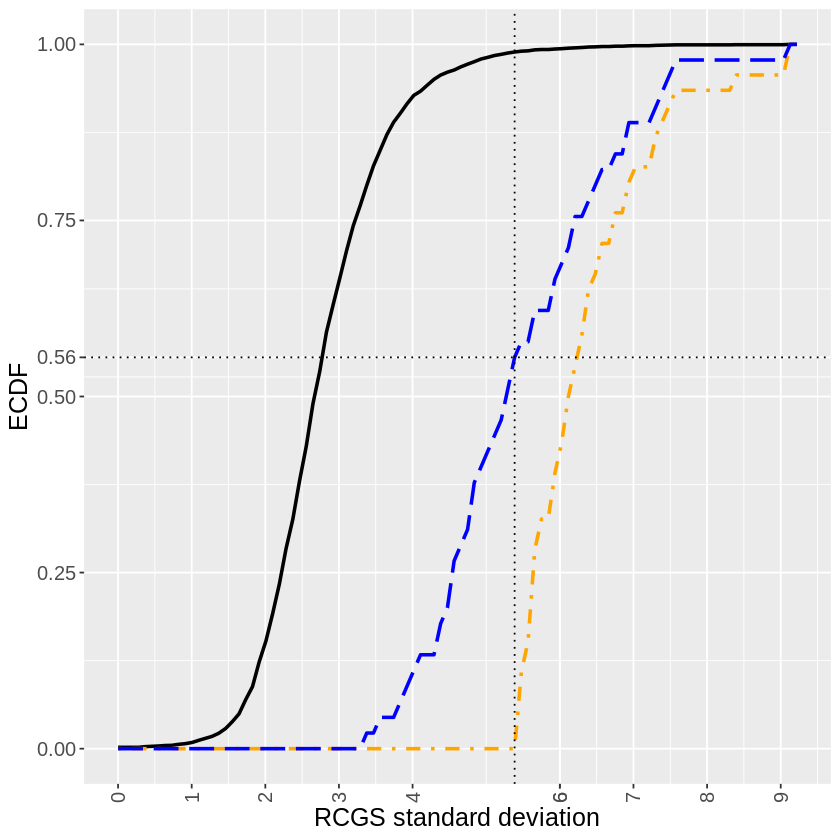

[1] "var.diff.2.articles.up"
[1] 0
[1] 41.96328
[1] 0
[1] 41.96328
[1] "val99:  9.23192107129749"
[1] "/tmp/articles/scientometrics/ecdf.var.diff.2.articles.up.png"


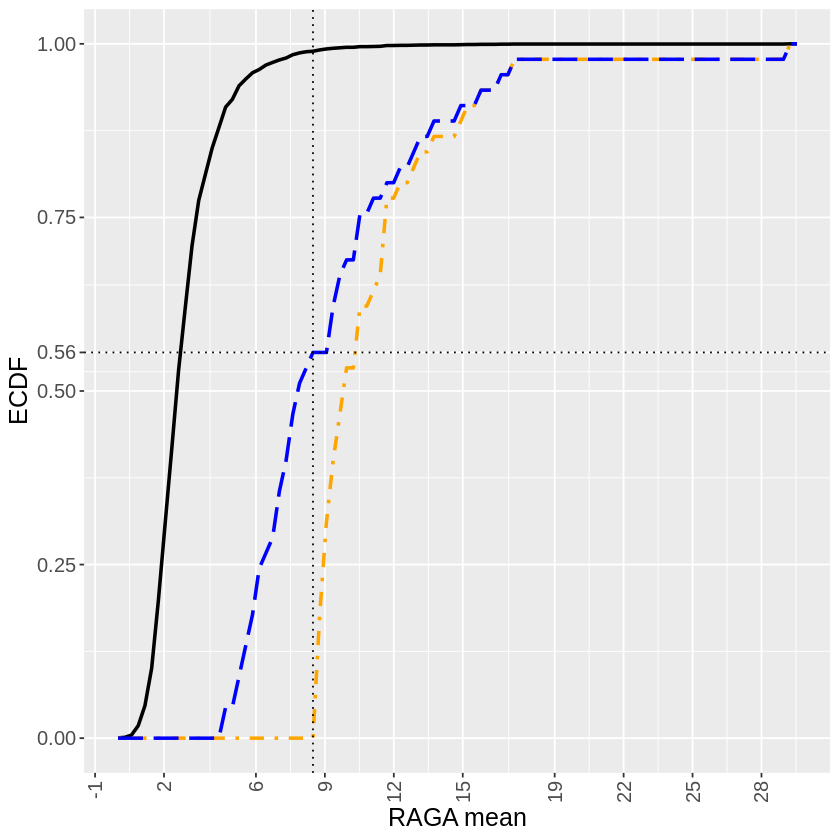

[1] "mean.diff.2.cumulative.coauthors.up"
[1] 0
[1] 70.25
[1] 0
[1] 70.25
[1] "val99:  16.86"
[1] "/tmp/articles/scientometrics/ecdf.mean.diff.2.cumulative.coauthors.up.png"


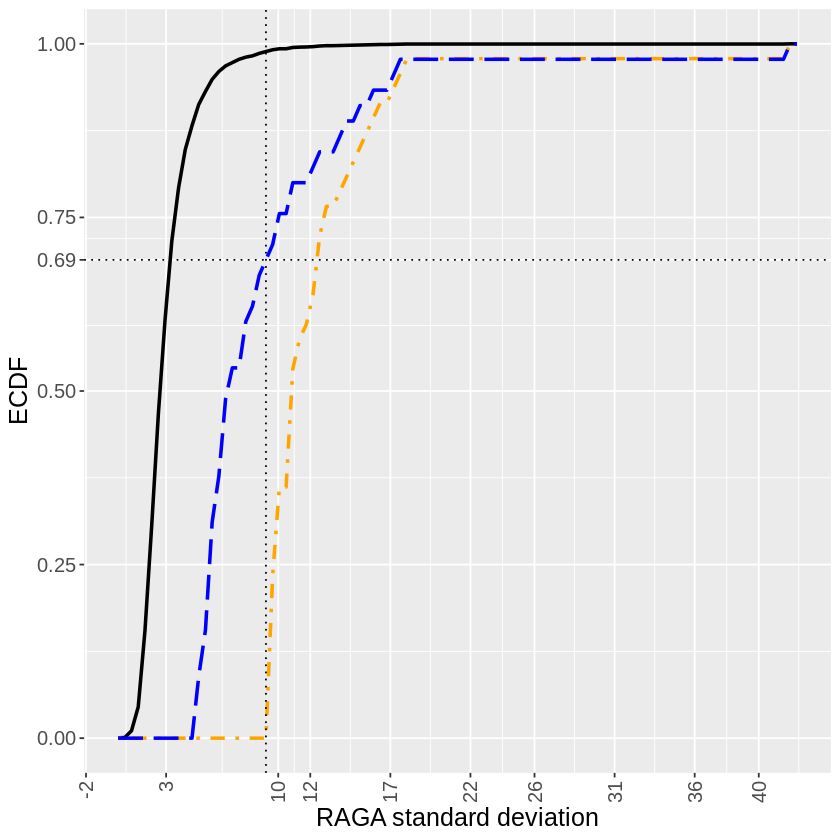

[1] "var.diff.2.cumulative.coauthors.up"
[1] 0
[1] 98.37132
[1] 0
[1] 98.37132
[1] "val99:  19.6742640692522"
[1] "/tmp/articles/scientometrics/ecdf.var.diff.2.cumulative.coauthors.up.png"


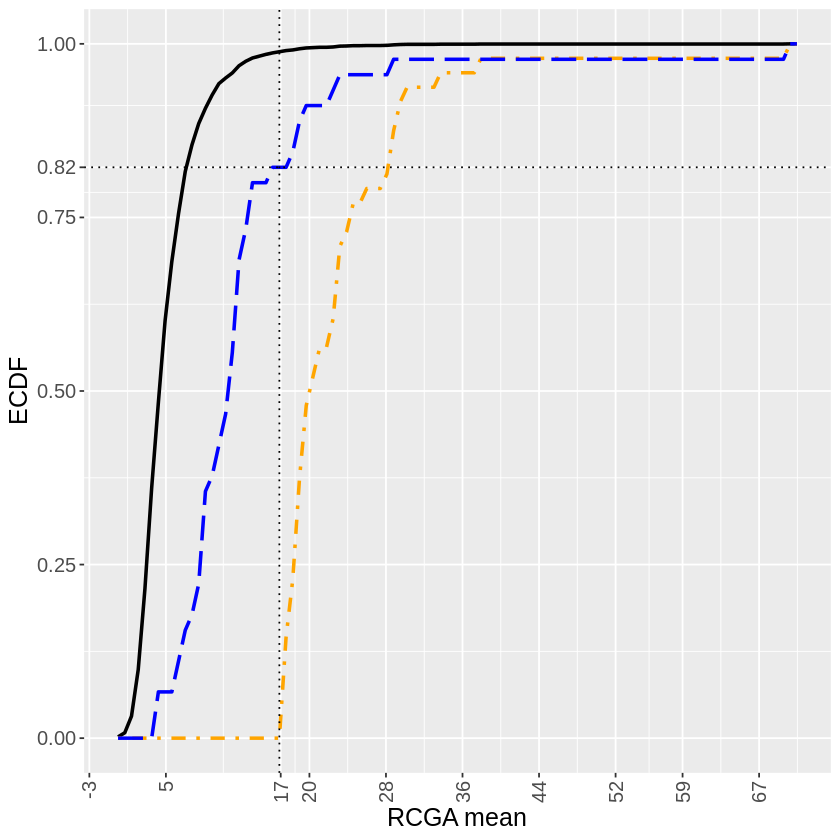

[1] "entropy.opposite"
[1] 0.06426573
[1] 1
[1] 0.06426573
[1] 1
[1] "val99:  0.897069229780553"
 [1] 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
[1] "/tmp/articles/scientometrics/ecdf.entropy.opposite.png"


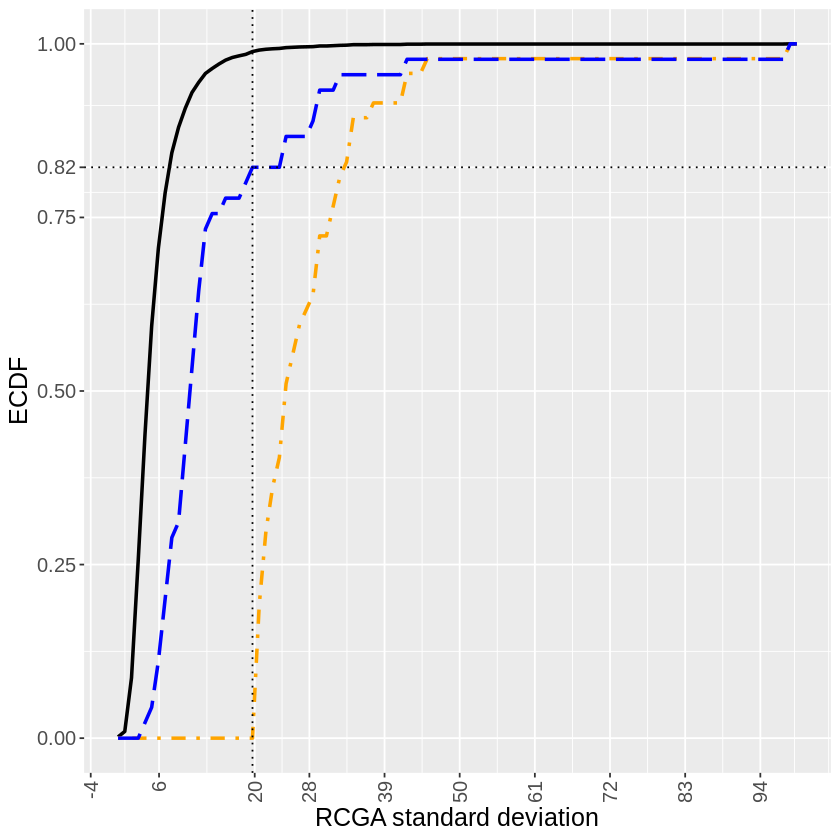

 [1] 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
[1] "mean.author.minus.venue.context.zscore"
[1] 0
[1] 4.231508
[1] 0
[1] 4.231508
[1] "val99:  3.21594640823936"
[1] "/tmp/articles/scientometrics/ecdf.mean.author.minus.venue.context.zscore.png"


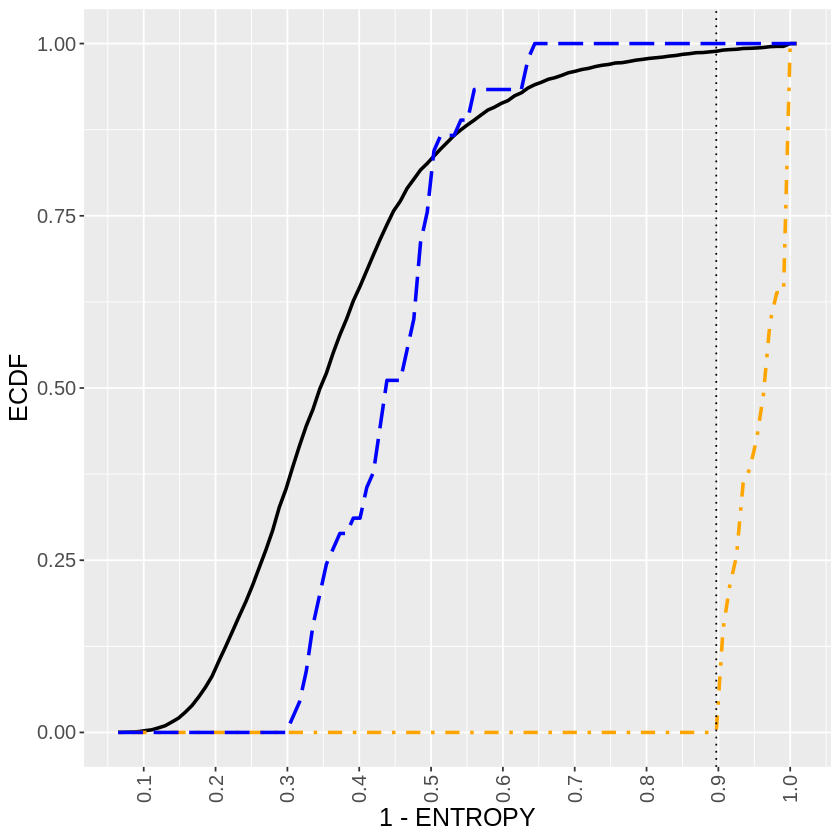

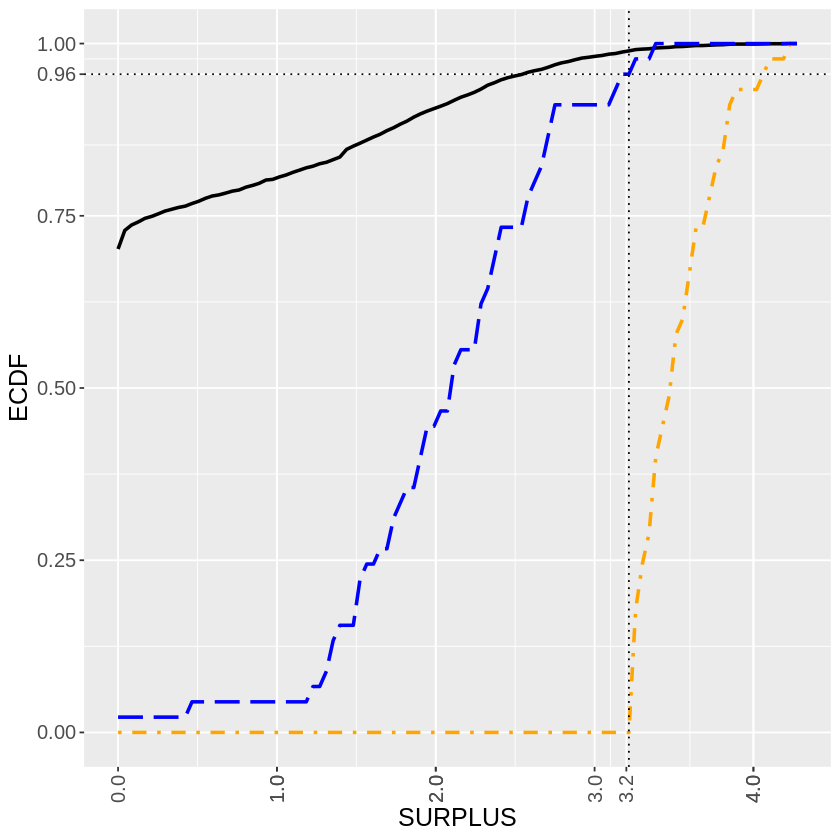

In [58]:
selected.for.plots <- sapply(outlierness, function(outlrns) {
    if (outlrns$feature1 %in% features.names) {
        print(outlrns$feature1)
        return (outlrns)
    } else {
        return (NA)
    }
})

selected.for.plots <- selected.for.plots[!is.na(selected.for.plots)]

x <- lapply (selected.for.plots, function(outlrns) {

    ecdf.data.population <- features[
        ,
        outlrns$feature1
    ]
    
    if (grepl("var.", outlrns$feature1, fixed = TRUE)) {
        ecdf.data.population <- sqrt(ecdf.data.population)
    }
    
    min.val.feature <- min(ecdf.data.population, na.rm=T)
    max.val.feature <- max(ecdf.data.population, na.rm=T)

    step <- (max.val.feature-min.val.feature)/100
    if (F) {
    if (step < 100) {
        step <- 10
    } else if (step < 1000) {
        step <- 100
    } else if (step < 10000) {
        step <- 1000
    }
    }
    
    print(outlrns$feature1)
    print(min(ecdf.data.population))
    print(max(ecdf.data.population))
    print(min.val.feature)
    print(max.val.feature)

    
    slots <- seq(min.val.feature, max.val.feature+step, by=step)

    x <- ecdf.data.population
    x <- x[!is.na(x)]
    ecdf.data <- sapply(slots, function(slt) {
        sum(x <= slt) / length(x)
    })
    
    # Index corresponding to 99% in ECDF
    THRESHOLD <- 0.99
    idx99 <- sum(ecdf.data < THRESHOLD)
    
    # Value corresponding to 99% in ECDF
    val99 <- slots[idx99]
    print(paste("val99: ", val99))
    
    # Number of occurrencies above the threshold
    ecdf.data.top.anoms <- features[
        which(ecdf.data.population >= val99)
        ,
        outlrns$feature1
    ]
    
    if (grepl("var.", outlrns$feature1, fixed = TRUE)) {
        ecdf.data.top.anoms <- sqrt(ecdf.data.top.anoms)
    }
    
    ecdf.top.anoms <- sapply(slots, function(slt) {
        sum(ecdf.data.top.anoms <= slt) / length(ecdf.data.top.anoms)
    })

    ecdf.data.prolific.2010 <- features[
        features$Node %in% baseline.authors#prolific.2010
        ,
        outlrns$feature1
    ]
    
    if (grepl("var.", outlrns$feature1, fixed = TRUE)) {
        ecdf.data.prolific.2010 <- sqrt(ecdf.data.prolific.2010)
    }
    
    ecdf.prolific.2010 <- sapply(slots, function(slt) {
        sum(ecdf.data.prolific.2010 <= slt) / length(ecdf.data.prolific.2010)
    })
    
    ecdf.val.prolific.99 <- ecdf.prolific.2010[idx99]

    data.ecdf.plot <- data.frame(x = slots, y1 = ecdf.data, y2 = ecdf.top.anoms, y3 = ecdf.prolific.2010)

    y.labels <- function(x) sprintf("%.2f", x)

    #print(data.ecdf.plot)
    #print(outlrns$feature1)
    if (!grepl("entropy", outlrns$feature1, fixed = TRUE)) {
        p <- plot(ggplot(data.ecdf.plot, aes(x=x, y=y1)) +
          geom_line(color = "black", size = 1, linetype="solid") +
          geom_line(data = data.ecdf.plot, aes(x=x, y=y2), color = "orange", size = 1, linetype="dotdash") +
          geom_line(data = data.ecdf.plot, aes(x=x, y=y3), color = "blue", size = 1, linetype="longdash") +
          #geom_line(data = data.ecdf.plot, aes(x=x, y=y3), color = "blue", size = 1, linetype="longdash") +
          scale_x_continuous(
              #trans="log10", 
              breaks=function(bob) {
                  min.val <- min(bob)
                  #min.val <- min.val %/% 10 * 10

                  max.val <- max(bob)
                  step <- (max.val - min.val) / 10
                  #print(paste("step: ",step))
                  #if (step < 10) step <- 10
                  #else if (step < 100) step <- 100
                  #else if (step < 1000) step <- 1000
                  #else if (step < 10000) step <- 10000
                  #print(paste("step: ",step))
                  brks <- seq(min.val, max.val, step)

                  pos99 <- sum(brks < val99)

                  if (abs(val99 - brks[pos99]) > 10 &&
                      abs(val99 - brks[pos99+1]) > 10) {

                      brks <- append(brks, val99, after=pos99)
                  } else {
                      if (abs(val99 - brks[pos99]) <= 10) {
                          brks[pos99] <- val99
                      } else {
                          brks[pos99+1] <- val99
                      }
                  }
                  
                  #print(paste("step: ", step))
                  #print(paste("brks: ", brks))
                  #print(paste("max: ", max.val))

                  if (max.val > 1.5) {
                      brks <- ceiling(brks)
                  } else {
                      brks <- brks[brks <= 1]
                      brks <- round(brks, 1)
                      if (!1 %in% brks) {
                          brks <- append(brks, 1)
                      }
                      print(brks)
                      brks
                  }
                  if (outlrns$feature1 == "mean.author.minus.venue.context.zscore") {
                  
                      pos99 <- sum(brks < val99)

                      if (abs(val99 - brks[pos99]) <= 10) {
                          brks[pos99] <- val99
                      } else {
                          brks[pos99+1] <- val99
                      }
                      brks <- round(brks, digits=1)
                  }
                  brks
                  
              }
          ) +
          scale_y_continuous(
              breaks=sort(c(seq(0, 1, length.out=5), ecdf.val.prolific.99)),
              labels=y.labels(sort(c(seq(0, 1, length.out=5), ecdf.val.prolific.99)))
          ) +
          geom_vline(xintercept=slots[idx99], linetype="dotted") + 
          geom_hline(yintercept=ecdf.val.prolific.99, linetype="dotted") + 
          theme(
              # axis.title.x=element_blank(),
              # axis.title.y=element_blank(),
              text = element_text(size=15),
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
          labs(
            x = features.author.article.up[[outlrns$feature1]],
            y = "ECDF"
          )
        )
    } else {
        p <- plot(ggplot(data.ecdf.plot, aes(x=x, y=y1)) +
          geom_line(color = "black", size = 1, linetype="solid") +
          geom_line(data = data.ecdf.plot, aes(x=x, y=y2), color = "orange", size = 1, linetype="dotdash") +
          geom_line(data = data.ecdf.plot, aes(x=x, y=y3), color = "blue", size = 1, linetype="longdash") +
          #geom_line(data = data.ecdf.plot, aes(x=x, y=y3), color = "blue", size = 1, linetype="longdash") +
          scale_x_continuous(
              breaks=function(bob) {
                  min.val <- min(bob)
                  #min.val <- min.val %/% 10 * 10

                  max.val <- max(bob)
                  step <- (max.val - min.val) / 10
                  #print(paste("step: ",step))
                  #if (step < 10) step <- 10
                  #else if (step < 100) step <- 100
                  #else if (step < 1000) step <- 1000
                  #else if (step < 10000) step <- 10000
                  #print(paste("step: ",step))
                  brks <- seq(min.val, max.val, step)

                  pos99 <- sum(brks < val99)
                  brks <- append(brks, val99, after=pos99)

                  #if (abs(val99 - brks[pos99]) > 10 &&
                  #    abs(val99 - brks[pos99+1]) > 10) {

                  #    brks <- append(brks, val99, after=pos99)
                  #} else {
                  #    if (abs(val99 - brks[pos99]) <= 10) {
                  #        brks[pos99] <- val99
                  #    } else {
                  #        brks[pos99+1] <- val99
                  #    }
                  #}

                  #print(paste("step: ", step))
                  #print(paste("brks: ", brks))
                  #print(paste("max: ", max.val))

                  if (max.val > 1.5) {
                      ceiling(brks)
                  } else {
                      brks <- brks[brks <= 1]
                      brks <- round(brks, 1)
                      if (!1 %in% brks) {
                          brks <- append(brks, 1)
                      }
                      print(brks)
                      brks
                  }
              }
          ) +
          # scale_y_continuous(
          #    breaks=sort(c(seq(0, 1, length.out=5), ecdf.val.prolific.99)),
          #    labels= y.labels(sort(c(seq(0, 1, length.out=5), ecdf.val.prolific.99)))
          #) +
          geom_vline(xintercept=slots[idx99], linetype="dotted") +
          #geom_hline(yintercept=ecdf.val.prolific.99, linetype="dotted") + 
          theme(
              #axis.title.x=element_blank(),
              #axis.title.y=element_blank(),
              text = element_text(size=15),
              axis.text.x = element_text(
                  angle = 90, 
                  vjust = 0.5, 
                  hjust=1)) +
          labs(
            x = "1 - ENTROPY",
            y = "ECDF"
          )
        )
    }
    save.plot(p, paste0("ecdf.", outlrns$feature1))
})

#### Prune correlated ranks

In [59]:
# Rename features
outlierness <- lapply(outlierness, function(scores) {
    scores$feature1 <- str_replace(scores$feature1, "standardized.", "")
    scores
})

In [60]:
#acceleration.up <- list()
ranks <- lapply(outlierness, function(outl) {
    outl$outlier.rank
})

cols <- lapply(outlierness, function(outl) {
    outl$feature1
})

ranks <- as.data.frame(do.call(cbind, ranks))
colnames(ranks) <- cols
#rownames(ranks) <- names(ranks[[1]])

Compute Spearman correlation and prune the hight correlated ones.

##### Code

In [61]:
spearman.correlation.acceleration.up <- corr.high(ranks, -1, method="spearman")

In [62]:
# Remove correlated classifications
remove.high.correlated.ranks <- function(rank.correlations, max.correlation) {
    included.features <- c()
    excluded.features <- c()
    rank.correlations$Var1 <- as.character(rank.correlations$Var1)
    rank.correlations$Var2 <- as.character(rank.correlations$Var2)
    correlated <- rank.correlations[rank.correlations$Freq >= max.correlation,]
    unrelated <- rank.correlations[rank.correlations$Freq < max.correlation,]
    if (nrow(correlated) > 0) {
        for (i in 1:nrow(correlated)) {
            row <- correlated[i,]
    #print(row)
            if (
                !(row[1,]$Var1 %in% included.features) && 
                !(row[1,]$Var1 %in% excluded.features) &&
                !(row[1,]$Var2 %in% included.features)
            ){
                included.features <- c(included.features, row[1,]$Var1)
    #print(paste("include: ", row[1,]$Var1))
    #print(paste("exclude: ", row[1,]$Var2))
                excluded.features <- c(excluded.features, row[1,]$Var2)
            }
        }
    }
    if (nrow(unrelated) > 0) {
        for (i in 1:nrow(unrelated)) {
            row <- unrelated[i,]
            if (
                !(row[1,]$Var1 %in% included.features) &&
                !(row[1,]$Var1 %in% excluded.features)
            ){
                included.features <- c(included.features, row[1,]$Var1)
            }
            if (
                !(row[1,]$Var2 %in% included.features) &&
                !(row[1,]$Var2 %in% excluded.features)
            ){
                included.features <- c(included.features, row[1,]$Var2)
            }
        }
    }
    included.features
}

Consider a threshold of 0.6 among all the selected features.

In [63]:
CORR.THRESHOLD <- 0.6
#spearman.correlation.acceleration.up <- corr.low(ranks, 0.35, method="spearman")
unrelated.features <- remove.high.correlated.ranks(spearman.correlation.acceleration.up, CORR.THRESHOLD)
while(max(spearman.correlation.acceleration.up$Freq) >= CORR.THRESHOLD) {
    spearman.correlation.acceleration.up <- corr.high(ranks[,colnames(ranks) %in% unrelated.features], -1, method="spearman")
    unrelated.features <- remove.high.correlated.ranks(spearman.correlation.acceleration.up, CORR.THRESHOLD)
    #print(unrelated.features)
}
#corr.high(ranks[,colnames(ranks) %in% unrelated.features], -1, method="spearman")

Selected features:

In [64]:
unrelated.features
length(unrelated.features)

[1] "var.diff.cumulative.coauthors.2.years"     
 [2] "var.diff.cumulative.coauthors.4.years"     
 [3] "mean.diff.articles"                        
 [4] "mean.diff.cumulative.coauthors"            
 [5] "var.diff.cumulative.coauthors.5.years"     
 [6] "var.diff.articles.5.years"                 
 [7] "var.diff.2.cumulative.coauthors.5.years.up"
 [8] "entropy.opposite"                          
 [9] "mean.author.minus.venue.context.zscore"    
[10] "var.diff.2.cumulative.coauthors.4.years.up"
[11] "var.diff.2.articles.5.years.up"            
[12] "var.diff.2.articles.2.years.up"            
[13] "var.diff.2.articles.4.years.up"            
[14] "var.diff.2.articles.3.years.up"            
[15] "var.diff.2.cumulative.coauthors.3.years.up"

[1] 15

In [65]:
# save.image(file="anomaliesv3.rdata")

In [66]:
#load(file="anomaliesv3.rdata")

#### Rank aggregation with Borda Count

In [67]:
borda.count <- function(ranks) {
    rowSums(ranks)
}

In [68]:
ranks <- ranks[, unrelated.features]
anoms.ranks <- borda.count(ranks)

In [69]:
ranks.means <- rowMeans(ranks)
ranks.stdev <- sqrt(rowVars(as.matrix(ranks)))
ranks.relative.stdev <- ranks.stdev / ranks.means

#### Anomalous authors

In [70]:
ranked.authors <- features[order(-anoms.ranks),]
ranked.authors$ranks.relative.stdev <- ranks.relative.stdev[order(-anoms.ranks)]
ranked.authors$rank <- 1:nrow(ranked.authors)
head(ranked.authors[,c("Node", "Node.name", "rank", "academic.birth", "ranks.relative.stdev")], n=110)

Node   Node.name     rank academic.birth ranks.relative.stdev
2546 149238 AUTHOR 149238  1   2010           0.04407780          
392    8859 AUTHOR 8859    2   2010           0.11752391          
188    3306 AUTHOR 3306    3   2010           0.05532332          
479   14190 AUTHOR 14190   4   2010           0.06926793          
206    3943 AUTHOR 3943    5   2010           0.05345278          
3738 510222 AUTHOR 510222  6   2010           0.08098966          
118    2316 AUTHOR 2316    7   2011           0.14943272          
1046  40894 AUTHOR 40894   8   2010           0.09801339          
1581  74922 AUTHOR 74922   9   2011           0.14115203          
1781  86541 AUTHOR 86541  10   2010           0.10216384          
3710 495013 AUTHOR 495013 11   2010           0.08355114          
720   25158 AUTHOR 25158  12   2010           0.10626963          
1047  40895 AUTHOR 40895  13   2010           0.12063332          
190    3354 AUTHOR 3354   14   2011           0.06954127          
1062  41329 AUTHOR 41329  15   2010           0.11315690          
1761  86097 AUTHOR 86097  16   2011           0.14623081          
2310 121866 AUTHOR 121866 17   2010           0.12341770          
1899  91117 AUTHOR 91117  18   2011           0.15768078          
1605  77424 AUTHOR 77424  19   2010           0.08416591          
3699 489213 AUTHOR 489213 20   2010           0.10693316          
1014  39623 AUTHOR 39623  21   2011           0.11160926          
45     1004 AUTHOR 1004   22   2010           0.20166160          
1512  63310 AUTHOR 63310  23   2011           0.20805409          
1316  54360 AUTHOR 54360  24   2011           0.17960694          
985   38769 AUTHOR 38769  25   2010           0.12915631          
2811 183734 AUTHOR 183734 26   2010           0.09305279          
1124  43640 AUTHOR 43640  27   2010           0.18932495          
740   26965 AUTHOR 26965  28   2010           0.17485828          
668   23277 AUTHOR 23277  29   2010           0.16584876          
2717 179282 AUTHOR 179282 30   2010           0.20695712          
...  ...    ...           ...  ...            ...                 
1683  82160 AUTHOR 82160   81  2010           0.1846760           
2889 192294 AUTHOR 192294  82  2010           0.2326841           
565   18675 AUTHOR 18675   83  2010           0.3359289           
1962  94647 AUTHOR 94647   84  2010           0.1445842           
191    3356 AUTHOR 3356    85  2010           0.3215037           
439    9906 AUTHOR 9906    86  2010           0.4226019           
2972 209723 AUTHOR 209723  87  2011           0.3418954           
820   31016 AUTHOR 31016   88  2010           0.1948029           
610   20161 AUTHOR 20161   89  2010           0.2965189           
788   29736 AUTHOR 29736   90  2010           0.1579336           
231    5168 AUTHOR 5168    91  2010           0.4292110           
3828 582070 AUTHOR 582070  92  2010           0.3098575           
2830 184813 AUTHOR 184813  93  2010           0.2451470           
357    8150 AUTHOR 8150    94  2010           0.2885668           
1760  86096 AUTHOR 86096   95  2010           0.3637987           
145    2793 AUTHOR 2793    96  2010           0.1949058           
3126 251582 AUTHOR 251582  97  2011           0.3066368           
1768  86227 AUTHOR 86227   98  2010           0.3973877           
193    3375 AUTHOR 3375    99  2010           0.2832736           
270    6123 AUTHOR 6123   100  2010           0.3431240           
3924 759702 AUTHOR 759702 101  2010           0.1568544           
3960 871795 AUTHOR 871795 102  2011           0.2231180           
2841 185198 AUTHOR 185198 103  2010           0.1710429           
1971  94953 AUTHOR 94953  104  2010           0.1639655           
3653 463918 AUTHOR 463918 105  2010           0.2109952           
189    3307 AUTHOR 3307   106  2010           0.4499063           
1117  43615 AUTHOR 43615  107  2010           0.2172048           
1751  85785 AUTHOR 85785  108  2010           0.1922

In [71]:
ecdf.data.anomalies <- sapply(anoms.ranks, function(anom) {
        sum(anoms.ranks <= anom) / length(anoms.ranks)
})
ecdf.data.anomalies <- data.frame(score=anoms.ranks, probability=ecdf.data.anomalies)
#ecdf.data.anomalies

In [72]:
val.top.anoms <- anoms.ranks[order(-anoms.ranks)]
val.top.anoms <- val.top.anoms[1:5]
val.top.anoms

[1] 61294 61079 60704 60422 60393

In [73]:
ecdf.val.top.anoms <- min(ecdf.data.anomalies[ecdf.data.anomalies$score %in% val.top.anoms,]$probability)
score.top.anoms.threshold <- min(val.top.anoms)

[1] "/tmp/articles/scientometrics/anomlay_score_ecdf.png"


png 
  2

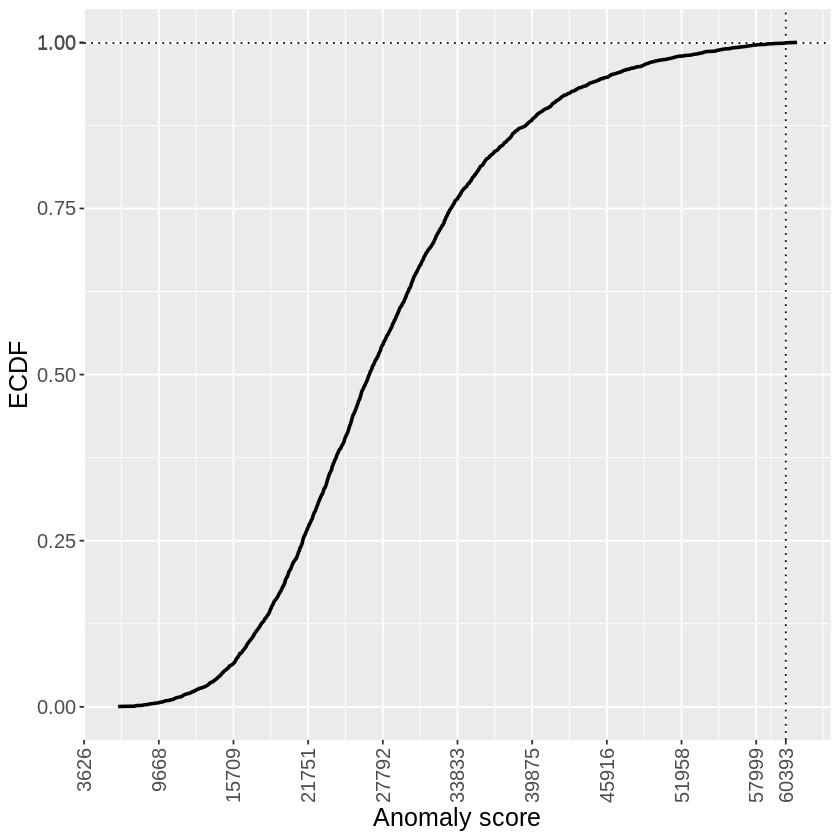

In [74]:
y.labels <- function(x) sprintf("%.2f", x)
p <- plot(ggplot(ecdf.data.anomalies, aes(x=score, y=probability)) +
      geom_line(color = "black", size = 1, linetype="solid") +
      scale_x_continuous(
          #trans="log10", 
          breaks=function(bob) {
              min.val <- min(bob)
              #min.val <- min.val %/% 10 * 10

              max.val <- max(bob)
              step <- (max.val - min.val) / 10
              brks <- seq(min.val, max.val, step)

              pos99 <- sum(brks < score.top.anoms.threshold)

              if (abs(val.top.anoms - brks[pos99]) > 10 &&
                  abs(val.top.anoms - brks[pos99+1]) > 10) {

                  brks <- append(brks, score.top.anoms.threshold, after=pos99)
              } else {
                  if (abs(val.top.anoms - brks[pos99]) <= 10) {
                      brks[pos99] <- score.top.anoms.threshold
                  } else {
                      brks[pos99+1] <- score.top.anoms.threshold
                  }
              }

              if (max.val > 1.5) {
                  ceiling(brks)
              } else {
                  brks <- brks[brks <= 1]
                  brks <- round(brks, 1)
                  if (!1 %in% brks) {
                      brks <- append(brks, 1)
                  }
                  print(brks)
                  brks
              }
          }
      ) +
      scale_y_continuous(
          breaks=sort(c(seq(0, 1, length.out=5), ecdf.val.top.anoms)),
          labels=y.labels(sort(c(seq(0, 1, length.out=5), ecdf.val.top.anoms)))
      ) +
      geom_vline(xintercept=score.top.anoms.threshold, linetype="dotted") + 
      geom_hline(yintercept=ecdf.val.top.anoms, linetype="dotted") + 
      theme(
          # axis.title.x=element_blank(),
          # axis.title.y=element_blank(),
          text = element_text(size=15),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)
      ) +
      labs(
        x = "Anomaly score",
        y = "ECDF"
      )
    )

save.plot(p, paste0("anomlay_score_ecdf", ""))

[1] "Mean: 28045.8802366864"
[1] "Sd: 9471.4856741593"
[1] "Outliers: 33"
[1] "Pos mean: 2345"


[1] 1880

[1] "Max:  61294"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



[1] "/tmp/articles/scientometrics/anomlay_score_distribution.png"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

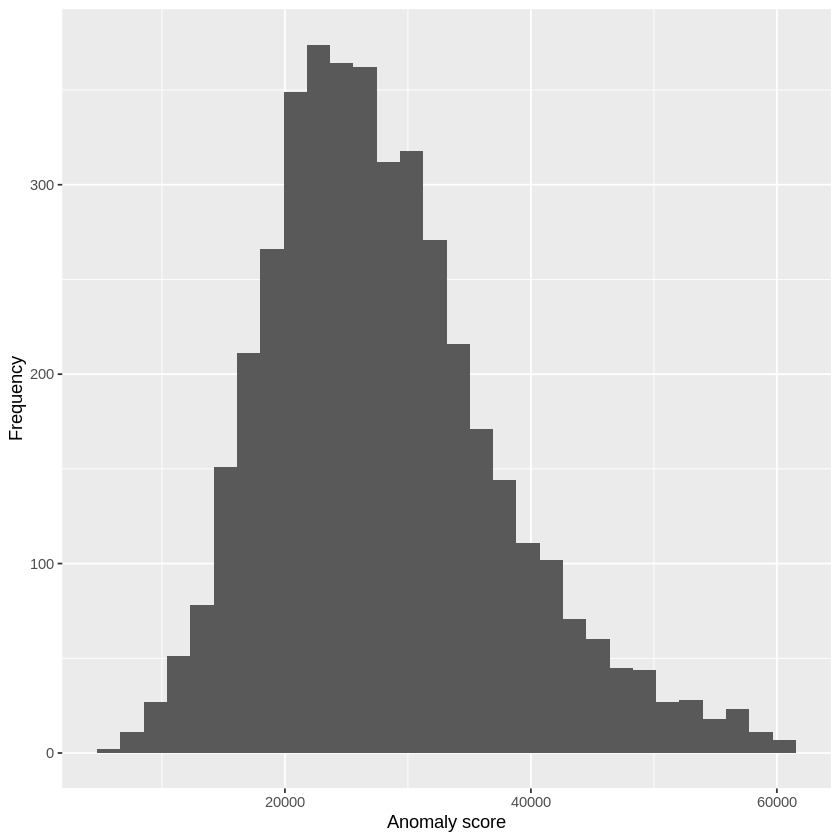

In [75]:
p <- ggplot(ecdf.data.anomalies, aes(x=score)) +
    geom_histogram() +
    labs(
      x = "Anomaly score",
      y = "Frequency"
    )
m <- mean(ecdf.data.anomalies$score)
sdev <- sd(ecdf.data.anomalies$score)
outliers_count <- sum(ecdf.data.anomalies$score >= (m + 3*sdev))
print(paste("Mean:", m))
print(paste("Sd:", sdev))
print(paste("Outliers:", outliers_count))

idx_mean <- 
    sum(
        ecdf.data.anomalies$score[
            order(ecdf.data.anomalies$score)
        ] <= m
    )

print(paste("Pos mean:", idx_mean))

    sum(
        ecdf.data.anomalies$score[
            order(ecdf.data.anomalies$score)
        ] > m
    )

print(paste("Max: ", max(ecdf.data.anomalies$score)))

p
save.plot(p, paste0("anomlay_score_distribution", ""))

In [76]:
(m + 3*sdev)

[1] 56460.34

In [77]:
save.cols <- unrelated.features
write.csv(
    ranked.authors[
    , 
    c("Node", "rank", "academic.birth", "all.publications", save.cols)
    ], paste0(base_data_dir,"authors_features.csv"),
    row.names=FALSE
)

In [78]:
names(ranks)

[1] "var.diff.cumulative.coauthors.2.years"     
 [2] "var.diff.cumulative.coauthors.4.years"     
 [3] "mean.diff.articles"                        
 [4] "mean.diff.cumulative.coauthors"            
 [5] "var.diff.cumulative.coauthors.5.years"     
 [6] "var.diff.articles.5.years"                 
 [7] "var.diff.2.cumulative.coauthors.5.years.up"
 [8] "entropy.opposite"                          
 [9] "mean.author.minus.venue.context.zscore"    
[10] "var.diff.2.cumulative.coauthors.4.years.up"
[11] "var.diff.2.articles.5.years.up"            
[12] "var.diff.2.articles.2.years.up"            
[13] "var.diff.2.articles.4.years.up"            
[14] "var.diff.2.articles.3.years.up"            
[15] "var.diff.2.cumulative.coauthors.3.years.up"

In [80]:
save.authors.ranks <- ranks[
    , 
    c(save.cols)
    ]
save.authors.ranks$Node <- rownames(ranks)
for(col in save.cols) {
    save.authors.ranks[,col] <- as.integer(nrow(save.authors.ranks) - save.authors.ranks[,col] + 1)
}
write.csv(
    save.authors.ranks, paste0(base_data_dir,"authors_ranks.csv"),row.names=FALSE
)

#### Top and middle ranked authors features

In [81]:
count.n <- 5
feats <- c(
    "rank",
    "academic.birth",
    "all.publications",
    unrelated.features
)

anoms.authors <- ranked.authors[
    1:count.n,
    c(
        "Node", 
        "Node.name", 
        feats
    )]


middle.start <- 2341

normal.authors <- ranked.authors[
    middle.start:(middle.start + count.n-1),
    c(
        "Node", 
        "Node.name", 
        feats
    )]

interested.authors <- rbind(anoms.authors, normal.authors)

interested.authors[,feats] <- round(interested.authors[,feats], 2)

interested.authors$academic.age <- 2021 - interested.authors$academic.birth
interested.authors$publications.day <- 
    (interested.authors$all.publications / (interested.authors$academic.age*261))^-1

In [82]:
anoms.authors$Node
anoms.authors

[1] 149238   8859   3306  14190   3943

Node   Node.name     rank academic.birth all.publications
2546 149238 AUTHOR 149238 1    2010           195             
392    8859 AUTHOR 8859   2    2010           480             
188    3306 AUTHOR 3306   3    2010           472             
479   14190 AUTHOR 14190  4    2010           453             
206    3943 AUTHOR 3943   5    2010           680             
     var.diff.cumulative.coauthors.2.years
2546  1930.8                              
392  18908.3                              
188   2182.5                              
479    794.0                              
206   1439.3                              
     var.diff.cumulative.coauthors.4.years mean.diff.articles
2546 2380.5                                17.72727          
392  4512.5                                43.63636          
188  1800.0                                42.90909          
479  1568.0                                41.18182          
206  1800.0                                61.81818          
     mean.diff.cumulative.coauthors var.diff.cumulative.coauthors.5.years
2546 22.00000                       10804.5                              
392  54.09091                       83232.0                              
188  42.09091                       12640.5                              
479  42.36364                        5000.0                              
206  45.00000                        3200.0                              
     var.diff.articles.5.years var.diff.2.cumulative.coauthors.5.years.up
2546  9384.5                    8320.5                                   
392  46818.0                   76440.5                                   
188  25538.0                     480.5                                   
479   2592.0                    2812.5                                   
206  23980.5                    8320.5                                   
     entropy.opposite mean.author.minus.venue.context.zscore
2546 0.6294406        1.344405                              
392  0.3667524        2.256471                              
188  0.5021327        1.924589                              
479  0.5150716        2.289086                              
206  0.6388019        1.210618                              
     var.diff.2.cumulative.coauthors.4.years.up var.diff.2.articles.5.years.up
2546 1404.5                                      8580.5                       
392  3528.0                                     38642.0                       
188   882.0                                     10952.0                       
479  3362.0                                      4704.5                       
206  3872.0                                       648.0                       
     var.diff.2.articles.2.years.up var.diff.2.articles.4.years.up
2546  208.7000                      2048.0                        
392  1924.7000                      7564.5                        
188   302.3000                      2812.5                        
479   731.5833                      4418.0                        
206   793.3000                       392.0                        
     var.diff.2.articles.3.years.up var.diff.2.cumulative.coauthors.3.years.up
2546   982.3333                      4256.333                                 
392  11653.0000                     16812.333                                 
188   1516.3333                      1836.333                                 
479   2869.0000                       420.500                                 
206    604.0000                      1058.000

In [83]:
normal.authors$Node
normal.authors

[1]  7623  8468  9755 61276 76691

Node  Node.name    rank academic.birth all.publications
324   7623 AUTHOR 7623  2341 2011            56             
372   8468 AUTHOR 8468  2342 2010            92             
435   9755 AUTHOR 9755  2343 2010            68             
1476 61276 AUTHOR 61276 2344 2010            60             
1594 76691 AUTHOR 76691 2345 2010           112             
     var.diff.cumulative.coauthors.2.years
324  272.7                                
372   17.3                                
435   33.7                                
1476 674.3                                
1594 144.2                                
     var.diff.cumulative.coauthors.4.years mean.diff.articles
324  1152.0                                 5.600000         
372     4.5                                 8.363636         
435   200.0                                 6.181818         
1476 2244.5                                 5.454545         
1594  128.0                                10.181818         
     mean.diff.cumulative.coauthors var.diff.cumulative.coauthors.5.years
324  4.800000                        800.0                               
372  4.909091                         12.5                               
435  5.545455                        162.0                               
1476 7.363636                       2048.0                               
1594 7.181818                         72.0                               
     var.diff.articles.5.years var.diff.2.cumulative.coauthors.5.years.up
324   18                        0.0                                      
372  578                       60.5                                      
435   72                        0.0                                      
1476   2                        0.0                                      
1594 512                        0.0                                      
     entropy.opposite mean.author.minus.venue.context.zscore
324  0.2532328        0                                     
372  0.2854088        0                                     
435  0.3628761        0                                     
1476 0.1565515        0                                     
1594 0.3333119        0                                     
     var.diff.2.cumulative.coauthors.4.years.up var.diff.2.articles.5.years.up
324  0                                          180.5                         
372  0                                           84.5                         
435  0                                           72.0                         
1476 0                                            0.0                         
1594 0                                            0.5                         
     var.diff.2.articles.2.years.up var.diff.2.articles.4.years.up
324  17.33333                        98.0                         
372  17.33333                       144.5                         
435  22.33333                        98.0                         
1476 36.33333                         0.0                         
1594  7.00000                         8.0                         
     var.diff.2.articles.3.years.up var.diff.2.cumulative.coauthors.3.years.up
324  128.0000000                       0                                      
372   57.3333333                      18                                      
435   58.3333333                     200                                      
1476  98.0000000                    2738                                      
1594   0.3333333                     882

#### DBLP-like plot

[1] "/tmp/articles/scientometrics/simulate.dblp.1.png"
[1] "/tmp/articles/scientometrics/simulate.dblp.2.png"


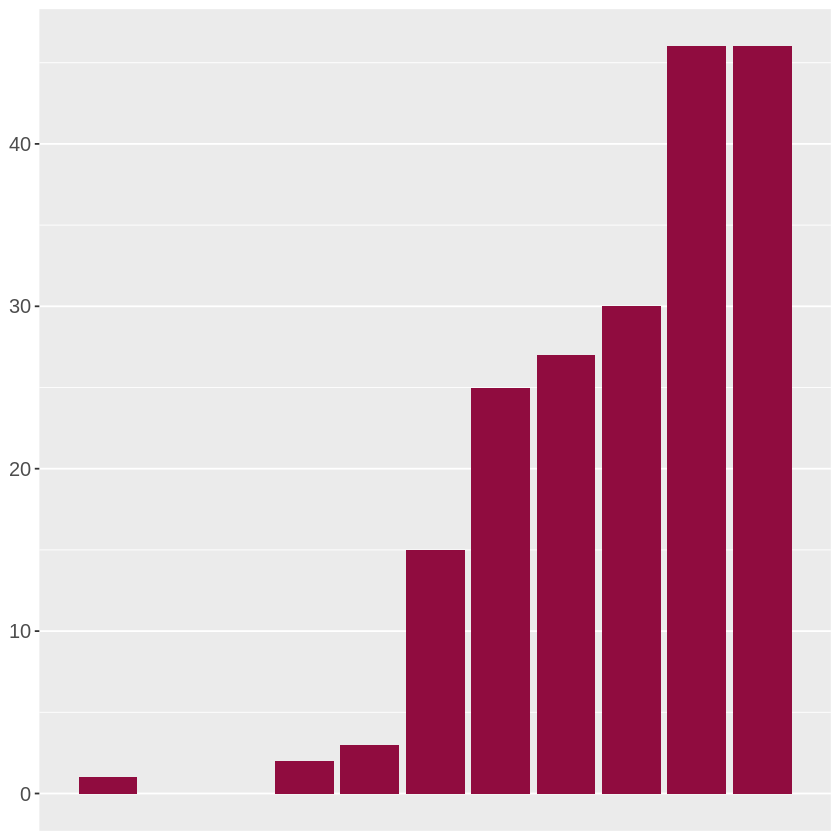

[1] "/tmp/articles/scientometrics/simulate.dblp.3.png"


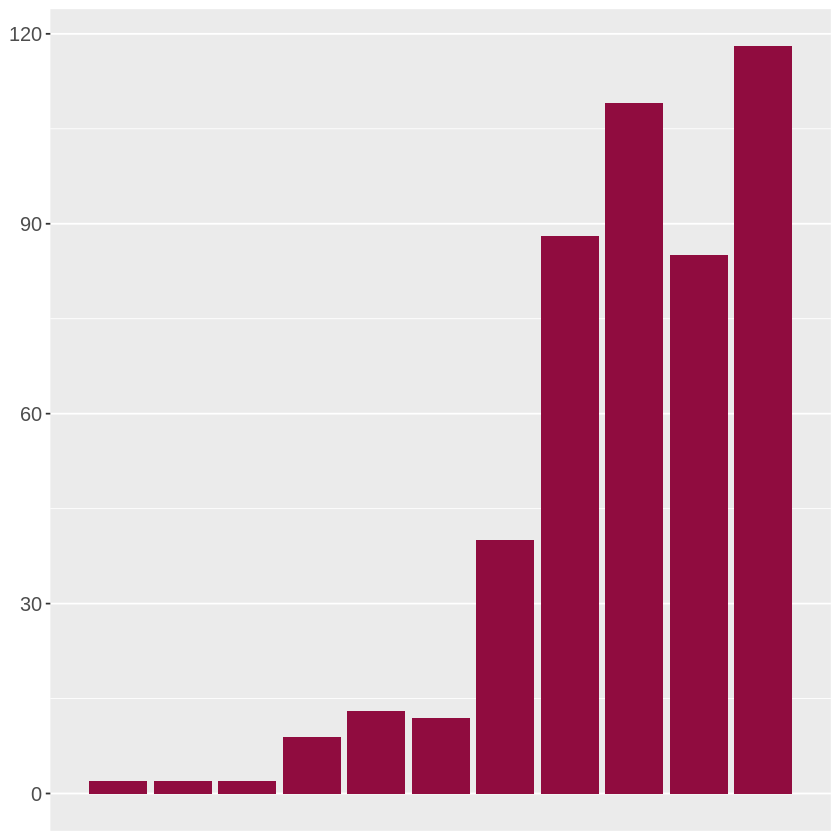

[1] "/tmp/articles/scientometrics/simulate.dblp.4.png"


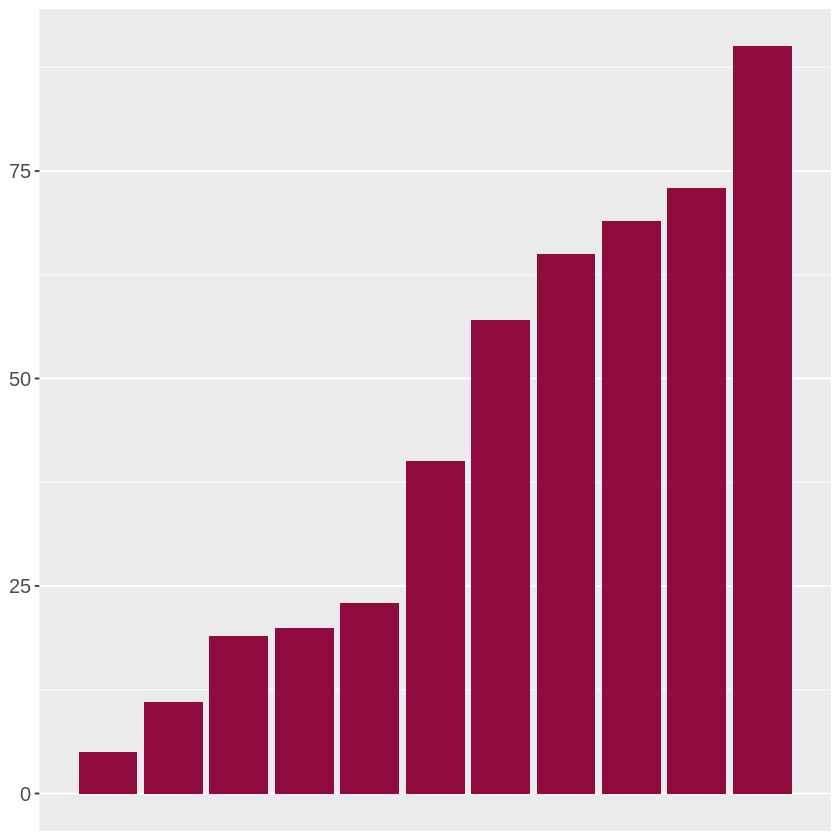

[1] "/tmp/articles/scientometrics/simulate.dblp.5.png"


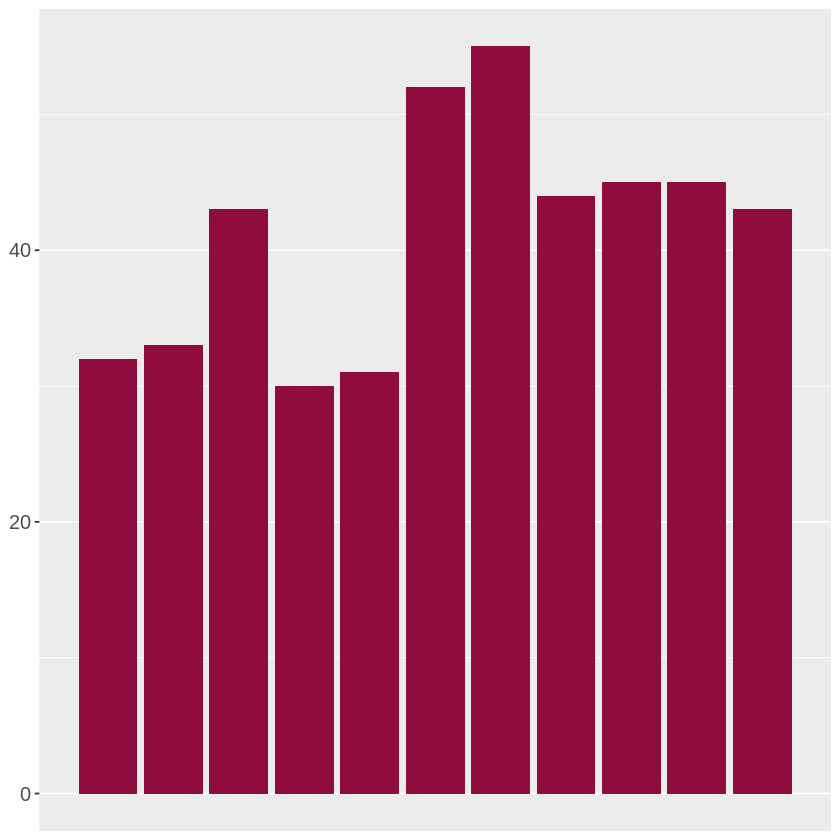

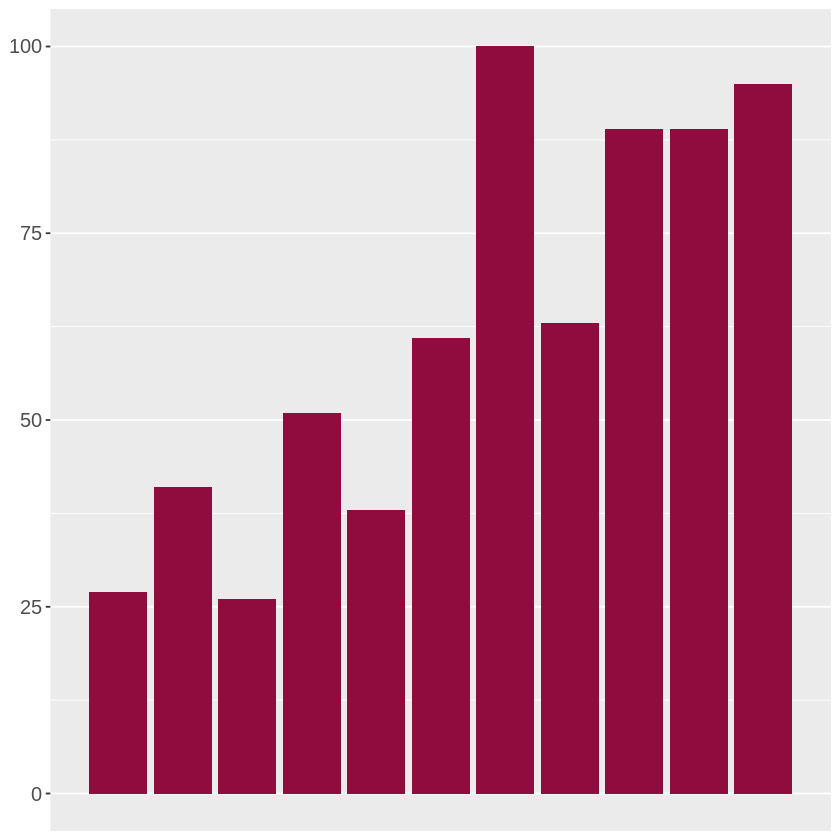

In [84]:
rownames(interested.authors) <- as.character(interested.authors$Node)
x <- lapply(interested.authors$Node[1:count.n], function(author) {
    y <- ggplot(
            all.t[all.t$Node == author,], 
            aes(x=Time, y=diff.articles)
       ) +
       geom_bar(stat="identity", fill="#900c3f") +
       scale_x_discrete(
           breaks=seq(10,20),
       ) +
       theme(
           axis.title.x=element_blank(),
           axis.title.y=element_blank(),
           text = element_text(size=15),
       ) 
    plot(y)
    save.plot(
        y, 
        paste0("simulate.dblp.", interested.authors[as.character(author),"rank"]),
        h = 400
    )
})

In [85]:
interested.authors$rank

[1]    1    2    3    4    5 2341 2342 2343 2344 2345

#### Prepare latex tables

###### Features table

In [86]:
latex.table <- interested.authors
the.column.names.latex <- colnames(latex.table)

get.t <- function(val) {
    year <- str_match(val, ".*(\\d+)\\.years.*")
    #print(year)
    year <- year[1, 2]
    #print(year)
    if (is.na(year)) {
        year <- 1
    }
    year
}

get.var.mean <- function(val) {
    varmean <- ""
    if (grepl("var.", val, fixed=T)) {
        varmean <- "SD"
    } else if (grepl("mean.", val, fixed=T)) {
        varmean <- "MEAN"
    }
    varmean
}

compute.latex.columns <- function(columns.names) {
    
    columns.names <- sapply(columns.names, function (col) {

        feat <- ""
        year <- ""
        varmean <- ""

        if (grepl("diff.cumulative.coauthors", col, fixed=T)) {
            feat <- "RCGS"
            year <- get.t(col)
            varmean <- get.var.mean(col)
        } else if (grepl("diff.articles", col, fixed=T)) {
            feat <- "RAGS"
            year <- get.t(col)
            varmean <- get.var.mean(col)
        } else if (grepl("diff.2.cumulative.coauthors.", col, fixed=T)) {
            feat <- "RCGA"
            year <- get.t(col)
            varmean <- get.var.mean(col)
        } else if (grepl("diff.2.articles.", col, fixed=T)) {
            feat <- "RAGA"
            year <- get.t(col)
            varmean <- get.var.mean(col)
        }

        if (feat == "" && grepl("entropy", col, fixed=T)) {
            feat <- "entropy"
        }

        if (feat == "") {
            feat <- col
        } else if (feat != "entropy") {
            feat <- paste0("T_", year, " ", feat, " ", varmean)
        }
        feat
    })
}

colnames(latex.table) <- compute.latex.columns(the.column.names.latex)

# colnames(latex.table)

latex.table$Node <- NULL
latex.table$Node.name <- NULL
latex.table$academic.birth <- NULL
latex.table$all.publications <- NULL
latex.table$academic.age <- NULL
latex.table$publications.day <- NULL

latex.table$Author <- paste("$A_{", latex.table$rank, "}$", sep="")

latex.table$rank <- NULL

the.column.names.latex <- sort(colnames(latex.table))

# the.column.names.latex

the.column.names.latex <- c(
    "Author",
    the.column.names.latex[
        (the.column.names.latex != "Author")
    ]
)


the.column.names.latex <- c(
    the.column.names.latex[
        (the.column.names.latex != "mean.author.minus.venue.context.zscore")
    ],
    "mean.author.minus.venue.context.zscore"
)

the.column.names.latex <- c(
    the.column.names.latex[
        (the.column.names.latex != "entropy")
    ],
    "entropy"
)

col_names_map <- data.frame(
    col_id=the.column.names.latex, 
    col_name=the.column.names.latex
)
col_names_map$col_id <- as.character(col_names_map$col_id)
col_names_map$col_name <- as.character(col_names_map$col_name)

rownames(col_names_map) <- the.column.names.latex

col_names_map["mean.author.minus.venue.context.zscore","col_name"] <- "Z-SCORE"
col_names_map["entropy",]$col_name <- "1 - E"

for (col in names(latex.table)) {
    if (grepl("SD", col, fixed=T)) {
        latex.table[,col] <- sqrt(latex.table[,col])
    }
}

latex.table <- latex.table[,the.column.names.latex]

names(latex.table) <- col_names_map$col_name

names(latex.table)

latex.table <- latex.table[
    ,
    c(
        "Author", 
        "T_1 RCGS MEAN",
        "T_1 RAGS MEAN",
        "T_2 RCGS SD",
        "T_2 RAGA SD",
        'T_3 RCGA SD',
        "1 - E",
        "Z-SCORE"
    )
]

#latex.table <- latex.table[,c(the.column.names.latex[1:7], "entropy")]
rownames(latex.table) <- NULL

#print(paste(colnames(latex.table), sep = " & "))
#x <- apply(latex.table, 1, function(row) {
#    values <- row[-1]
#    values <- sprintf("%0.2f", as.numeric(values))
#    values <- c(row[1], values)
#    paste(values, sep = " & ")
#})

#latex.table <- t(x)
#colnames(latex.table) <- colnames(latex.table)


print(xtable(latex.table, type = "latex"))

[1] "Author"        "T_1 RAGS MEAN" "T_1 RCGS MEAN" "T_2 RAGA SD"  
 [5] "T_2 RCGS SD"   "T_3 RAGA SD"   "T_3 RCGA SD"   "T_4 RAGA SD"  
 [9] "T_4 RCGA SD"   "T_4 RCGS SD"   "T_5 RAGA SD"   "T_5 RAGS SD"  
[13] "T_5 RCGA SD"   "T_5 RCGS SD"   "Z-SCORE"       "1 - E"

% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Thu Mar  2 21:59:31 2023
\begin{table}[ht]
\centering
\begin{tabular}{rlrrrrrrr}
  \hline
 & Author & T\_1 RCGS MEAN & T\_1 RAGS MEAN & T\_2 RCGS SD & T\_2 RAGA SD & T\_3 RCGA SD & 1 - E & Z-SCORE \\ 
  \hline
1 & \$A\_\{1\}\$ & 22.00 & 17.73 & 43.94 & 14.45 & 65.24 & 0.63 & 1.34 \\ 
  2 & \$A\_\{2\}\$ & 54.09 & 43.64 & 137.51 & 43.87 & 129.66 & 0.37 & 2.26 \\ 
  3 & \$A\_\{3\}\$ & 42.09 & 42.91 & 46.72 & 17.39 & 42.85 & 0.50 & 1.92 \\ 
  4 & \$A\_\{4\}\$ & 42.36 & 41.18 & 28.18 & 27.05 & 20.51 & 0.52 & 2.29 \\ 
  5 & \$A\_\{5\}\$ & 45.00 & 61.82 & 37.94 & 28.17 & 32.53 & 0.64 & 1.21 \\ 
  6 & \$A\_\{2341\}\$ & 4.80 & 5.60 & 16.51 & 4.16 & 0.00 & 0.25 & 0.00 \\ 
  7 & \$A\_\{2342\}\$ & 4.91 & 8.36 & 4.16 & 4.16 & 4.24 & 0.29 & 0.00 \\ 
  8 & \$A\_\{2343\}\$ & 5.55 & 6.18 & 5.81 & 4.73 & 14.14 & 0.36 & 0.00 \\ 
  9 & \$A\_\{2344\}\$ & 7.36 & 5.45 & 25.97 & 6.03 & 52.33 & 0.16 & 0.00 \\ 
  10 & \$A\_\{2345\}\$ & 7.18 & 10.18 & 

##### Ranks table

In [87]:
latex.table <- ranks
for(col in colnames(latex.table)) {
    latex.table[,col] <- as.integer(nrow(latex.table) - latex.table[,col] + 1)
}

latex.table$Node <- features$Node
latex.table <- latex.table[order(-anoms.ranks),]
latex.table$Author <- paste("$A_{", 1:nrow(latex.table), "}$", sep="")
latex.table <- latex.table[
    latex.table$Node %in% interested.authors$Node,
]
the.column.names.latex <- colnames(latex.table)
colnames(latex.table) <- compute.latex.columns(the.column.names.latex)
latex.table$Node <- NULL
latex.table$Node.name <- NULL
latex.table$academic.birth <- NULL
latex.table$all.publications <- NULL


latex.table <- latex.table[,col_names_map$col_id]

names(latex.table) <- col_names_map$col_name

latex.table <- latex.table[
    ,
    c(
        "Author", 
        "T_1 RCGS MEAN",
        "T_1 RAGS MEAN",
        "T_2 RCGS SD",
        "T_2 RAGA SD",
        'T_3 RCGA SD',
        "1 - E",
        "Z-SCORE"
    )
]

print(xtable(latex.table, type = "latex"))

% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Thu Mar  2 21:59:31 2023
\begin{table}[ht]
\centering
\begin{tabular}{rlrrrrrrr}
  \hline
 & Author & T\_1 RCGS MEAN & T\_1 RAGS MEAN & T\_2 RCGS SD & T\_2 RAGA SD & T\_3 RCGA SD & 1 - E & Z-SCORE \\ 
  \hline
2546 & \$A\_\{1\}\$ & 132 & 158 &  84 & 185 &  71 & 292 & 717 \\ 
  392 & \$A\_\{2\}\$ &   6 &  12 &   3 &   3 &  11 & 1862 & 296 \\ 
  188 & \$A\_\{3\}\$ &  15 &  13 &  73 & 101 & 241 & 703 & 420 \\ 
  479 & \$A\_\{4\}\$ &  14 &  14 & 323 &  22 & 966 & 633 & 278 \\ 
  206 & \$A\_\{5\}\$ &  12 &   1 & 145 &  16 & 442 & 263 & 758 \\ 
  324 & \$A\_\{2341\}\$ & 3245 & 3142 & 1056 & 2578 & 4225 & 3300 & 4225 \\ 
  372 & \$A\_\{2342\}\$ & 3196 & 1290 & 3800 & 2578 & 2754 & 2896 & 4225 \\ 
  435 & \$A\_\{2343\}\$ & 2884 & 2618 & 3413 & 2230 & 1505 & 1912 & 4225 \\ 
  1476 & \$A\_\{2344\}\$ & 2037 & 3298 & 400 & 1555 & 141 & 4107 & 4225 \\ 
  1594 & \$A\_\{2345\}\$ & 2111 & 789 & 1819 & 3549 & 524 & 2271 & 4225 \\ 
   \hline
\

In [88]:
mean.pubs.anoms <- mean(interested.authors[
    interested.authors$Node %in% anoms.authors$Node,
    "publications.day"
])

mean.pubs.normal <- mean(interested.authors[
    interested.authors$Node %in% normal.authors$Node,
    "publications.day"
])

if (F) {
print (
    paste0("Coauthors A ",
        sum(
            features[
                features$Node %in% interested.authors$Node[1:count.n],
            ]$all.coauthors
        )
    )
)

print (
    paste0("Coauthors B ",
        sum(
            features[
                features$Node %in% interested.authors$Node[count.n:nrow(interested.authors)],
            ]$all.coauthors
        )
    )
)
}
    
print (
    paste0("Mean Coauthors A ",
        sum(
            features[
                features$Node %in% interested.authors$Node[1:count.n],
            ]$all.coauthors
        ) / 5
    )
)

print (
    paste0("Mean Coauthors B ",
        sum(
            features[
                features$Node %in% interested.authors$Node[count.n:nrow(interested.authors)],
            ]$all.coauthors
        ) / 5
    )
)

if(F){
print(
    paste0("Publications A ", sum(interested.authors$all.publications[1:count.n]))
)
print(
    paste0("Publications B ", sum(interested.authors$all.publications[count.n:nrow(interested.authors)]))
)
}

print(
    paste0("Mean Publications A ", sum(interested.authors$all.publications[1:count.n]) / 5)
)
print(
    paste0("Mean Publications B ", sum(interested.authors$all.publications[count.n:nrow(interested.authors)]) / 5)
)


print(paste0("Days per article anomalous: ", mean.pubs.anoms))
print(paste0("Days per article normal: ", mean.pubs.normal))

[1] "Mean Coauthors A 494.6"
[1] "Mean Coauthors B 212"
[1] "Mean Publications A 456"
[1] "Mean Publications B 213.6"
[1] "Days per article anomalous: 7.46935224192425"
[1] "Days per article normal: 38.7036362805992"


In [89]:
ranks$Node <- features$Node

#### Top and middle-ranked plots

[1] "/tmp/articles/scientometrics/anomalous.midrank.behavior.diff.articles.png"
[1] "/tmp/articles/scientometrics/anomalous.midrank.behavior.diff.2.articles.png"
[1] "/tmp/articles/scientometrics/anomalous.midrank.behavior.diff.cumulative.coauthors.png"


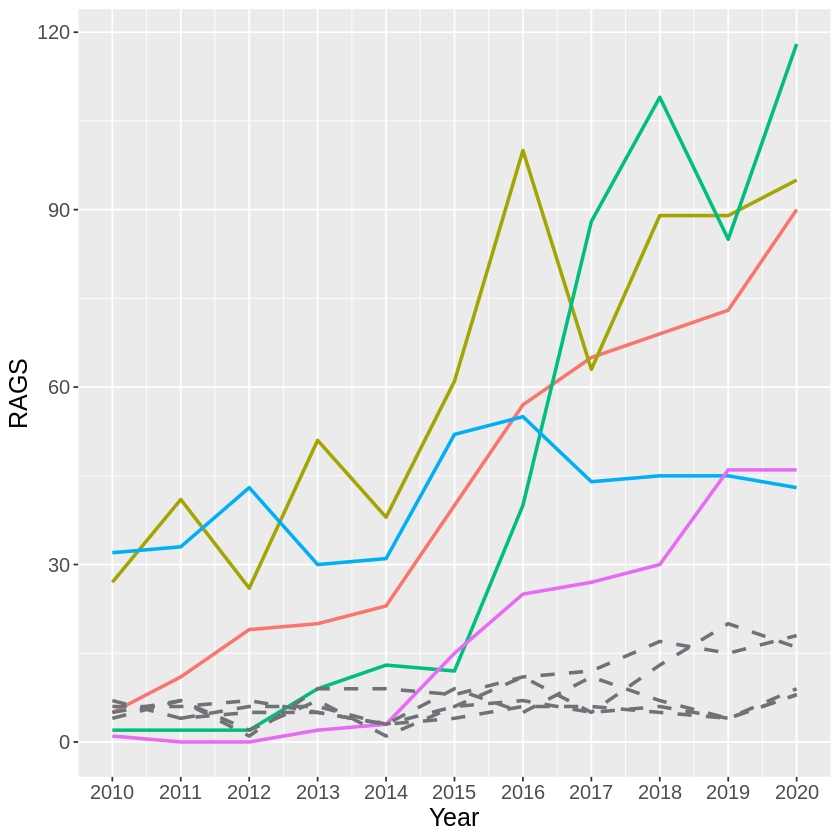

[1] "/tmp/articles/scientometrics/anomalous.midrank.behavior.diff.2.cumulative.coauthors.png"


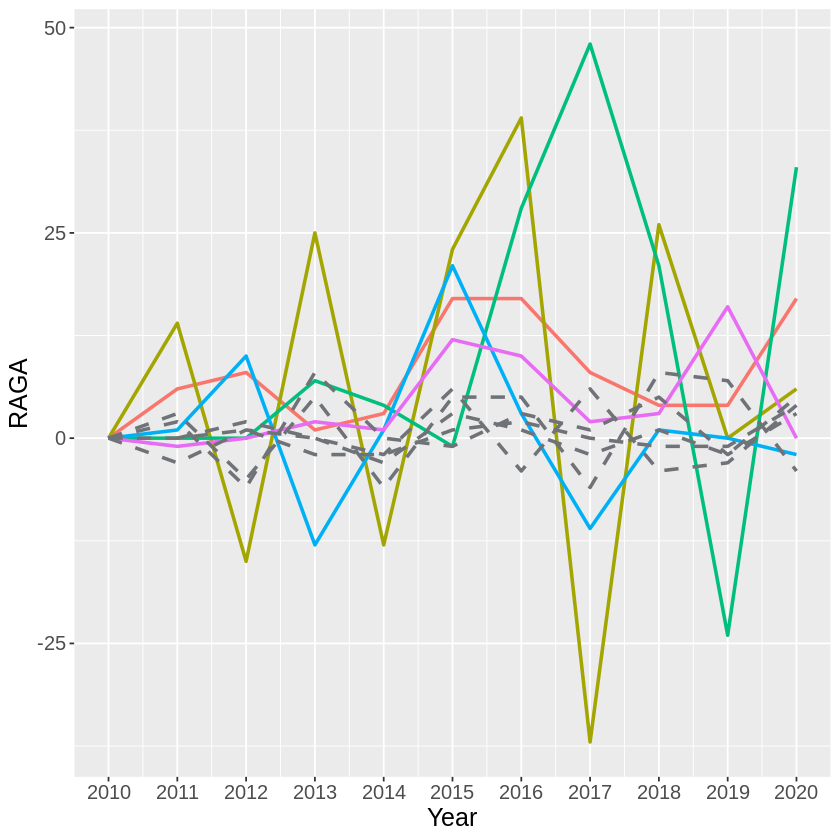

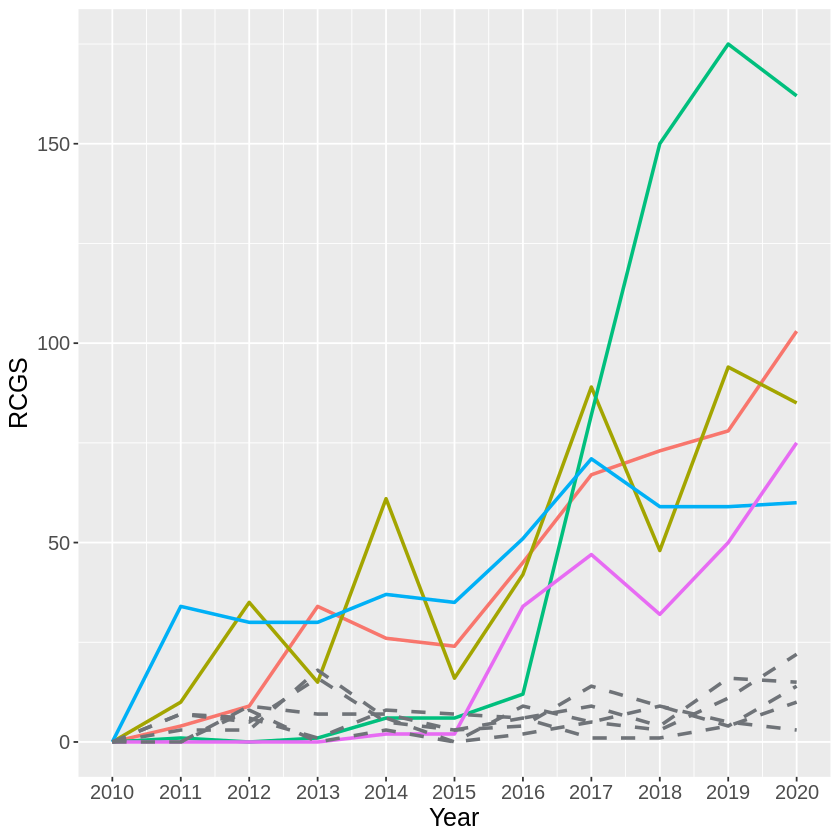

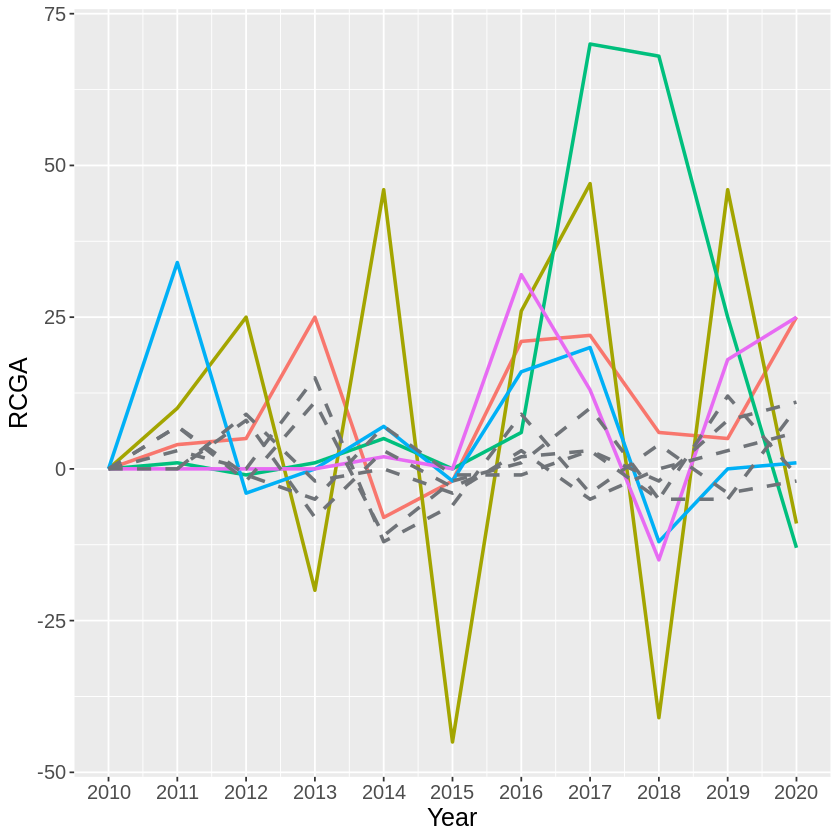

In [90]:
plot.author.behavior.3 (
    anoms.authors$Node, 
    normal.authors$Node,
    all.t,
    c(names(features.names.1)),
    features.names.1 
)

#### Top 10 anomalous authors' behavior

[1] "/tmp/articles/scientometrics/anomalies.cummulative.publications.png"
[1] "/tmp/articles/scientometrics/anomalies.cummulative.coauthors.png"
[1] "/tmp/articles/scientometrics/anomalies.publications.speed.png"


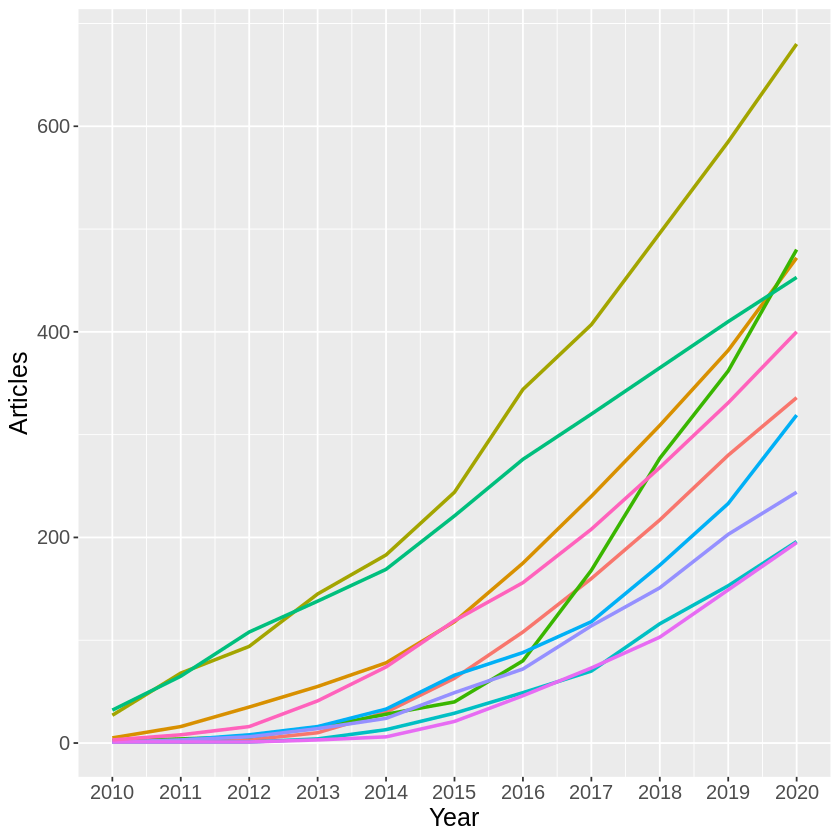

[1] "/tmp/articles/scientometrics/anomalies.coauthors.speed.png"


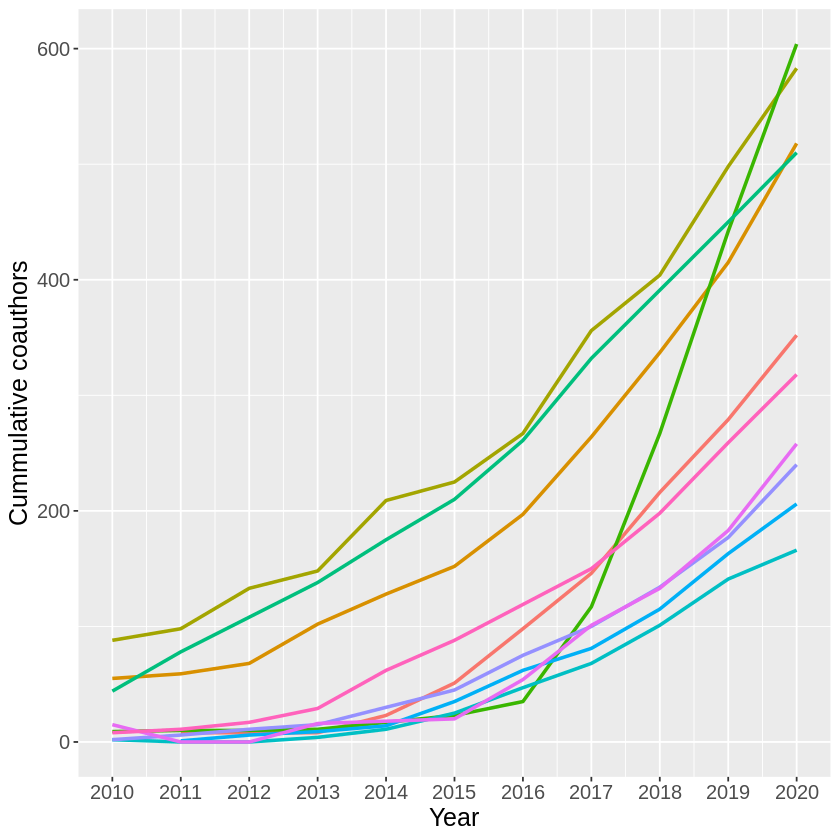

[1] "/tmp/articles/scientometrics/anomalies.publications.acceleration.png"


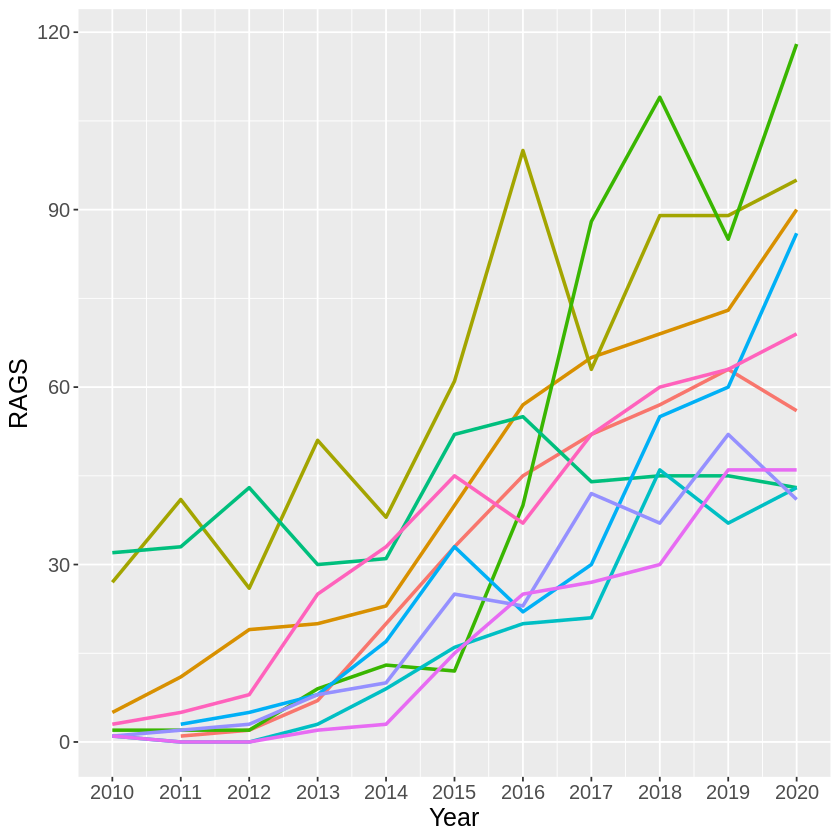

[1] "/tmp/articles/scientometrics/anomalies.coauthors.acceleration.png"


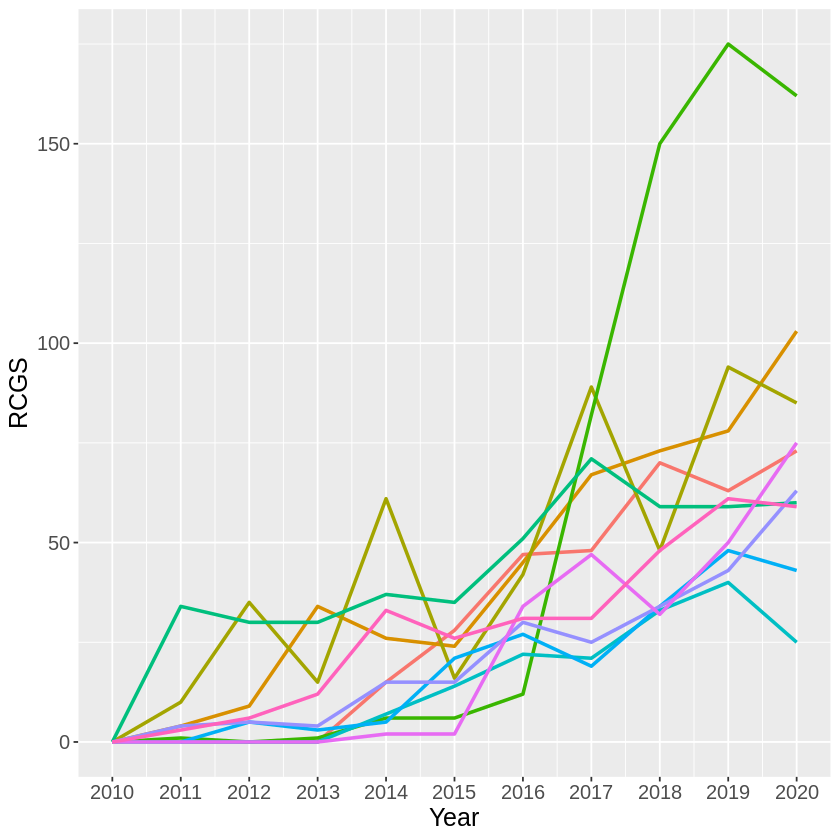

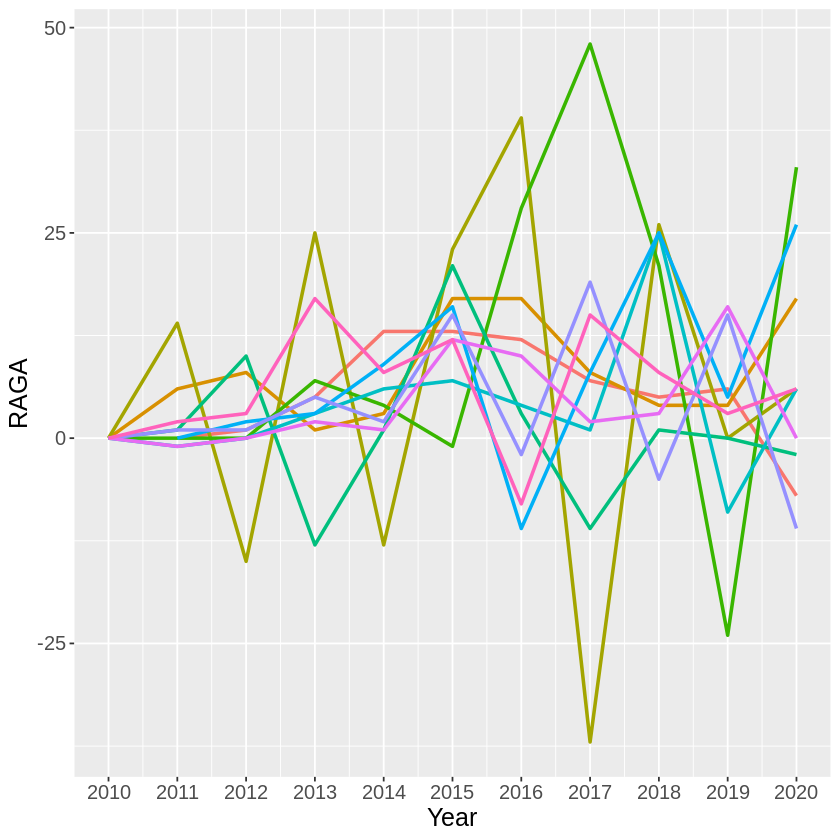

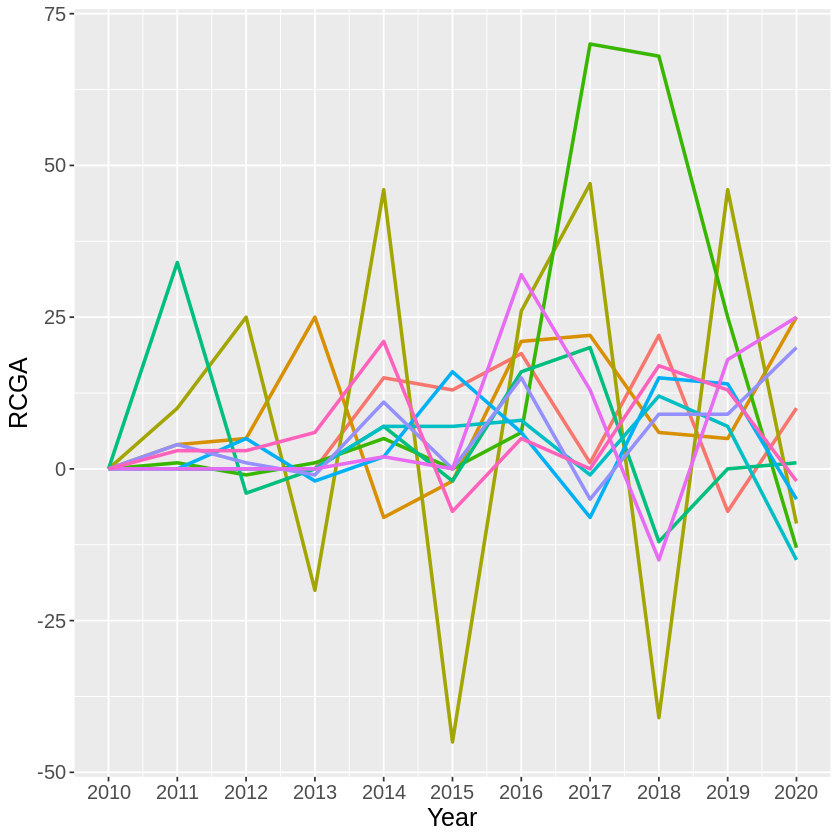

In [91]:
plot.authors.behavior(features[order(-anoms.ranks),]$Node[1:10], all.t, "anomalies")